In [34]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Giant component size change

In [2]:
cpcc = pd.read_csv('../data/interim/costanzo_pcc_ALL')

In [22]:
def get_giant_component(G):
    Gc = max([G.subgraph(c).copy() for c in nx.connected_components(G)], key=len)
    return Gc

In [355]:
ne_ratio_list = []
nv_ratio_list = []

In [401]:
thr_list =  [0.05,0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5]

In [357]:
for i in np.arange(0.2,0.75,0.05):
    df = cpcc.loc[cpcc.pcc>=i]
    nw = nx.from_pandas_edgelist(df,source='gene1',target='gene2')
    nw_g = get_giant_component(nw)
    n_e = len(nw_g.edges)
    ne_ratio_list.append(n_e/len(nw.edges))
    n_v = len(nw_g.nodes)
    nv_ratio_list.append(n_v/len(nw.nodes))

    print(f"{i} : ne = {n_e}, ne_ratio: {n_e/len(nw.edges)}, nv = {n_v}, nv_ratio = {n_v/len(nw.nodes)}")

0.2 : ne = 39816, ne_ratio: 0.9987457984247228, nv = 5183, nv_ratio = 0.9831183611532626
0.25 : ne = 20810, ne_ratio: 0.9893505752591043, nv = 3924, nv_ratio = 0.932287954383464
0.3 : ne = 10973, ne_ratio: 0.9426166136929817, nv = 2615, nv_ratio = 0.7960426179604262
0.35 : ne = 5857, ne_ratio: 0.8150570553854718, nv = 1686, nv_ratio = 0.646968534151957
0.39999999999999997 : ne = 862, ne_ratio: 0.21034651049292338, nv = 280, nv_ratio = 0.1423487544483986
0.44999999999999996 : ne = 246, ne_ratio: 0.10967454302273741, nv = 105, nv_ratio = 0.07553956834532374
0.49999999999999994 : ne = 93, ne_ratio: 0.07795473595976529, nv = 57, nv_ratio = 0.06168831168831169
0.5499999999999999 : ne = 26, ne_ratio: 0.044905008635578586, nv = 18, nv_ratio = 0.03180212014134275
0.5999999999999999 : ne = 20, ne_ratio: 0.07662835249042145, nv = 9, nv_ratio = 0.030303030303030304
0.6499999999999999 : ne = 10, ne_ratio: 0.08333333333333333, nv = 6, nv_ratio = 0.0379746835443038
0.7 : ne = 6, ne_ratio: 0.12, nv =

In [358]:
xlab = "Pearson's Correlation Coefficient threshold"

Text(0.5, 0, "Pearson's Correlation Coefficient threshold")

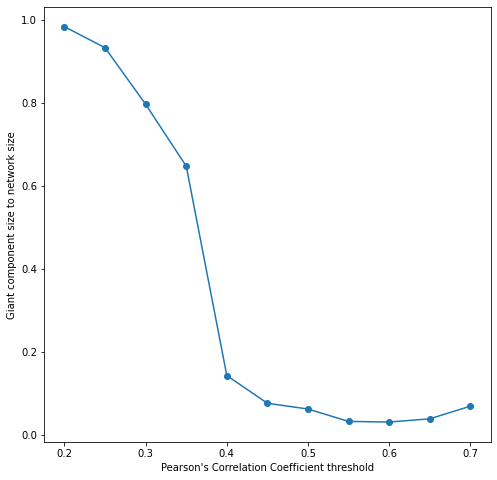

In [359]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(np.arange(0.2,0.75,0.05),nv_ratio_list,'o-')
ax.set_ylabel('Giant component size to network size')
ax.set_xlabel(xlab)

# Effector and sensor clusters with GO enrichments

In [76]:
sensor_df_names = [ ]

In [285]:
def get_result_dfs(fname, thr_list, default_thr):
    dfs = {thr: pd.read_csv(f"../data/interim_{thr}/{fname}.csv") for thr in thr_list if thr!=default_thr}
    dfs[default_thr] = pd.read_csv(f"../data/interim/{fname}.csv")
    if default_thr not in thr_list:
        thr_list.insert(0, default_thr)                               
    return dfs

In [286]:
effector_dfs = get_result_dfs('effectors_df', thr_list, 0.2)

In [287]:
sensor_dfs =  get_result_dfs('sensors_df', thr_list, 0.2)

In [294]:
sensor_dfs[0.2].dropna(subset=['sensor_cluster']).loc[:,'sensor_cluster'].nunique()

9

In [360]:
def plot_go_thr_comparison(dfs, col, yaxis):
    n_goterms = []
    rat_goterms = []
    n_clusters = []
    n_go_clusters = []
    for i in thr_list:
        df = dfs[i]
        n_goterms.append(df.dropna(subset=['go_group']).shape[0])
        rat_goterms.append(n_goterms[-1]/df.shape[0])
        n_clusters.append(df.dropna(subset=[col]).loc[:,col].nunique())
        n_go_clusters.append(df.dropna(subset=[col]).loc[:,'go_group'].nunique())
        
    fig, axs = plt.subplots(1,3,figsize=(15,5))
    axs[0].plot(thr_list, n_clusters, 'o-')
    axs[0].set_ylabel(f'Number of {yaxis} clusters')
    axs[0].set_xlabel(xlab)
    
    axs[1].plot(thr_list, n_go_clusters, 'o-')
    axs[1].set_ylabel(f'Number of go enriched {yaxis} clusters')
    axs[1].set_xlabel(xlab)
    
    axs[2].plot(thr_list, [i/j if i!=0 else 0 for i,j in zip(n_go_clusters,n_clusters) ], 'o-')
    axs[2].set_ylabel(f'% of go enriched {yaxis} clusters')
    axs[2].set_xlabel(xlab)

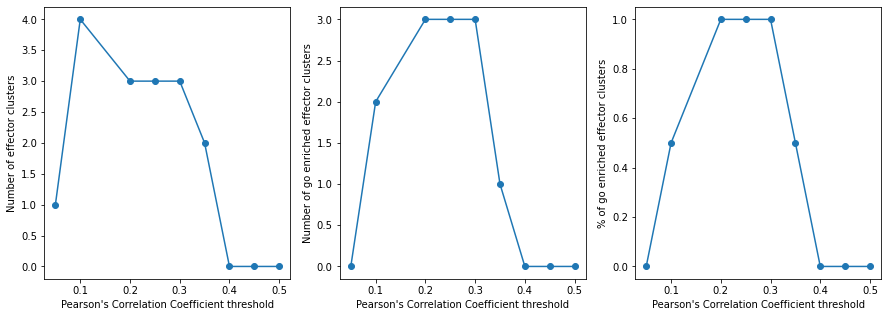

In [361]:
plot_go_thr_comparison(effector_dfs,'effector_cluster', 'effector')

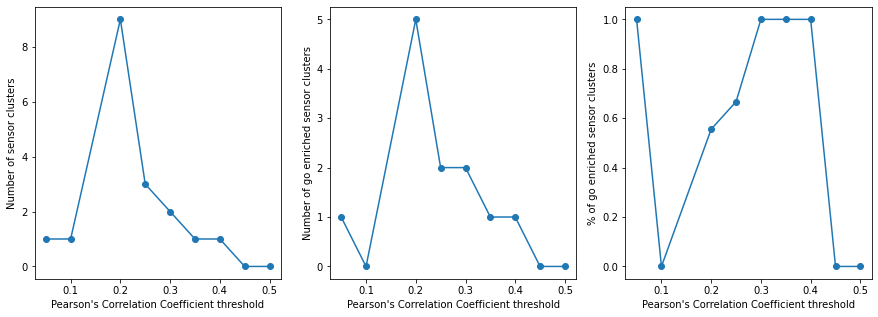

In [362]:
plot_go_thr_comparison(sensor_dfs,'sensor_cluster', 'sensor')

In [561]:

sensor_overlap = pd.DataFrame({thr : [len(np.intersect1d(sensor_dfs[thr].orf_name, sensor_dfs[i].orf_name)) for i in thr_list] for thr in sorted(thr_list)})
sensor_overlap.index = thr_list

# Sensor overlap between thresholds

<AxesSubplot:>

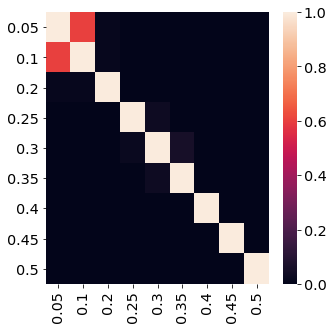

In [579]:
sns.heatmap(sensor_overlap / np.diag(sensor_overlap))

# Effector overlap between thresholds

<AxesSubplot:>

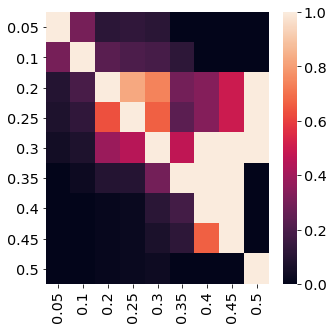

In [580]:

effector_overlap = pd.DataFrame({thr : [len(np.intersect1d(effector_dfs[thr].orf_name, effector_dfs[i].orf_name)) for i in thr_list] for thr in sorted(thr_list)})
effector_overlap.index = thr_list
sns.heatmap(effector_overlap / np.diag(effector_overlap))

In [175]:
import itertools as itr

In [218]:
def get_pairwise_intersect(dfs, thr_list):
    pairs = itr.combinations(thr_list,2)
    nt = lambda a, b: [len(np.intersect1d(dfs[a].orf_name,effector_dfs[b].orf_name)) , len(dfs[b].orf_name)]
    res = dict([ (t, nt(*t)) for t in pairs ])

    return res

0.05 0.1
0.1 0.2
0.2 0.25
0.25 0.3
0.3 0.35
0.35 0.4
0.4 0.45
0.45 0.5


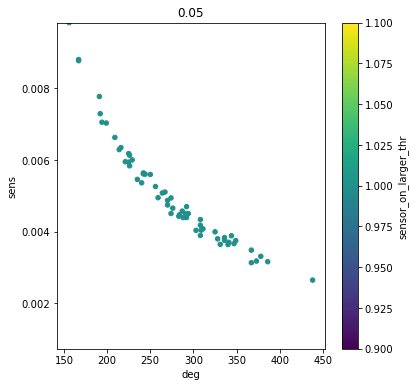

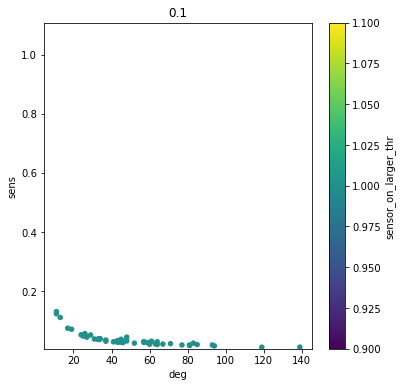

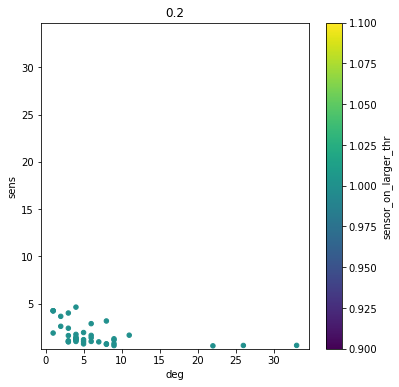

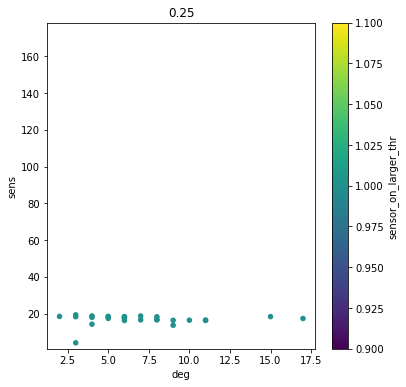

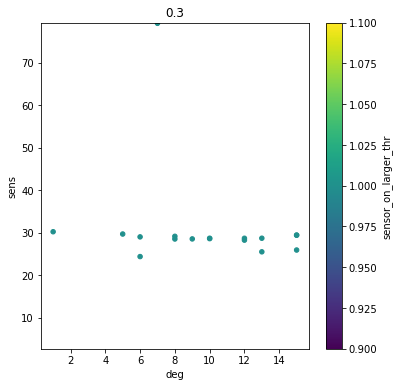

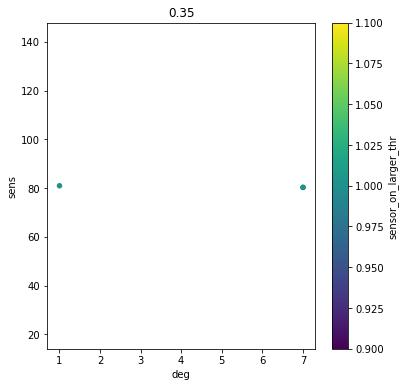

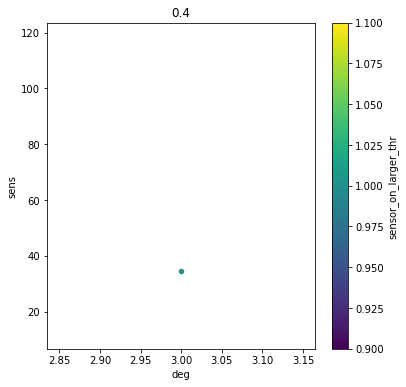

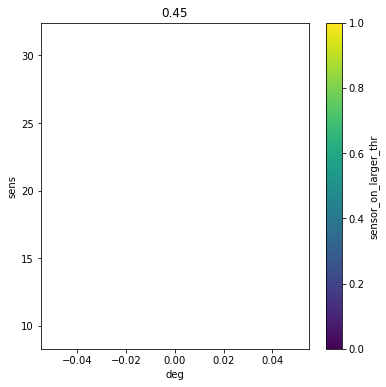

In [337]:
for i in range(1,len(thr_list)):
    prev = thr_list[i-1]
    curr = thr_list[i]
    print(prev,curr)
    curr_sensors = sensor_dfs[curr].orf_name.tolist()
    pcc_dfs[prev]['sensor_on_larger_thr'] = pd.Categorical([1 if i else 0 for i in pcc_dfs[prev].orf_name.isin(curr_sensors)])
    
    fig, ax = plt.subplots(figsize=(6,6))
    pcc_dfs[prev].loc[pcc_dfs[prev].sensor_on_larger_thr==1].plot.scatter('deg','sens',c='sensor_on_larger_thr',cmap='viridis',ax=ax)
    ax.set_title(prev)
    ax.set_ylim(pcc_dfs[prev].sens.min(),pcc_dfs[prev].sens.max())

In [220]:
get_pairwise_intersect(effector_dfs, thr_list)

{(0.2, 0.25): [33, 40],
 (0.2, 0.3): [20, 27],
 (0.2, 0.35): [5, 17],
 (0.2, 0.4): [1, 3],
 (0.2, 0.45): [1, 2],
 (0.2, 0.5): [1, 1],
 (0.25, 0.3): [18, 27],
 (0.25, 0.35): [4, 17],
 (0.25, 0.4): [1, 3],
 (0.25, 0.45): [1, 2],
 (0.25, 0.5): [1, 1],
 (0.3, 0.35): [8, 17],
 (0.3, 0.4): [3, 3],
 (0.3, 0.45): [2, 2],
 (0.3, 0.5): [1, 1],
 (0.35, 0.4): [3, 3],
 (0.35, 0.45): [2, 2],
 (0.35, 0.5): [0, 1],
 (0.4, 0.45): [2, 2],
 (0.4, 0.5): [0, 1],
 (0.45, 0.5): [0, 1]}

In [221]:
get_pairwise_intersect(sensor_dfs, thr_list)

{(0.2, 0.25): [0, 40],
 (0.2, 0.3): [0, 27],
 (0.2, 0.35): [0, 17],
 (0.2, 0.4): [0, 3],
 (0.2, 0.45): [0, 1],
 (0.2, 0.5): [0, 1],
 (0.25, 0.3): [0, 27],
 (0.25, 0.35): [0, 17],
 (0.25, 0.4): [0, 3],
 (0.25, 0.45): [0, 1],
 (0.25, 0.5): [0, 1],
 (0.3, 0.35): [0, 17],
 (0.3, 0.4): [0, 3],
 (0.3, 0.45): [0, 1],
 (0.3, 0.5): [0, 1],
 (0.35, 0.4): [0, 3],
 (0.35, 0.45): [0, 1],
 (0.35, 0.5): [0, 1],
 (0.4, 0.45): [0, 1],
 (0.4, 0.5): [0, 1],
 (0.45, 0.5): [0, 1]}

In [308]:
pcc_dfs = get_result_dfs('pcc_df', thr_list,0.2)

In [233]:
pcc_dfs[i].corr().loc['deg','eff']

0.9203905376819284

In [236]:
[pcc_dfs[i].corr('pearson').loc['deg','sens'] for i in thr_list]

[0.13913489431379195,
 0.1224190391634265,
 0.3374750698590764,
 0.1836172611995399,
 -0.08122530817819895,
 -0.23685738216798707,
 -0.07267183919021618]

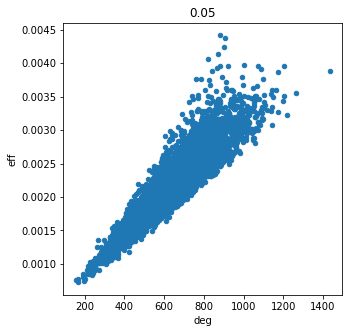

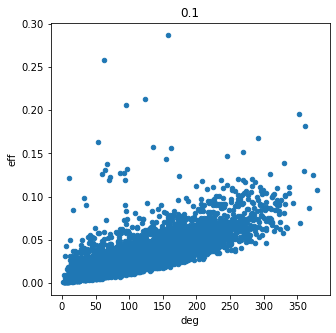

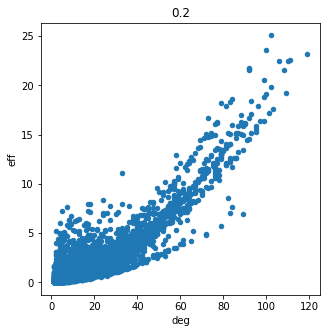

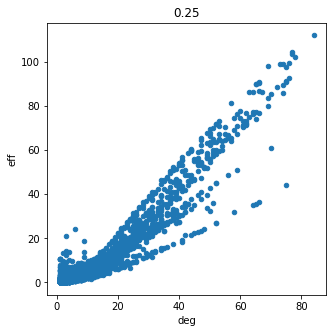

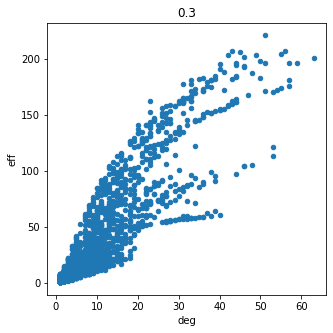

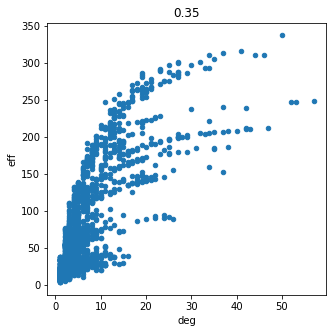

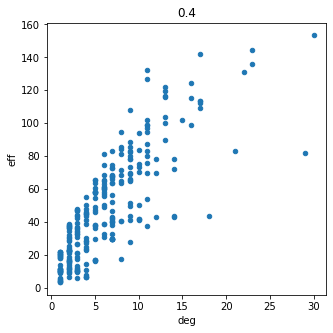

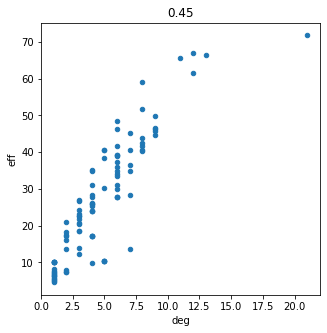

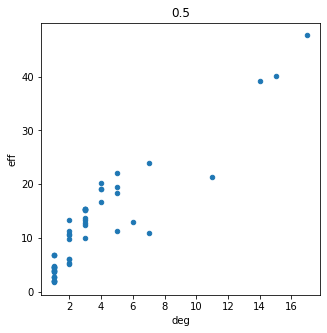

In [312]:
for i in thr_list:
    fig, ax = plt.subplots(figsize=(5,5))
    pcc_dfs[i].plot.scatter('deg','eff',ax=ax)
    ax.set_title(i)

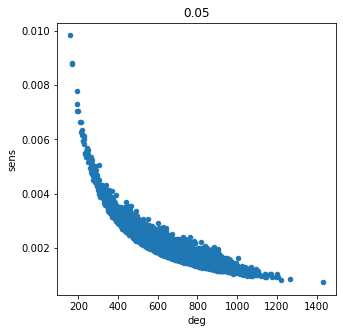

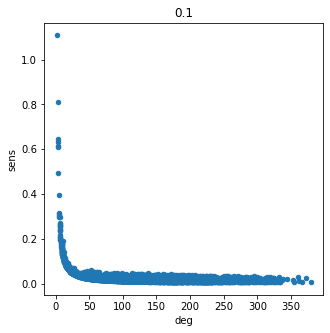

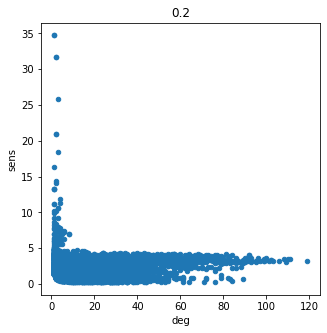

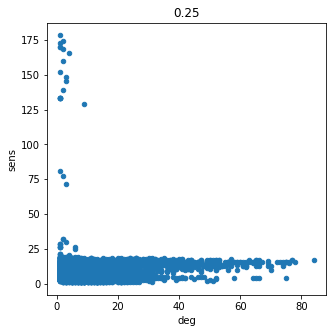

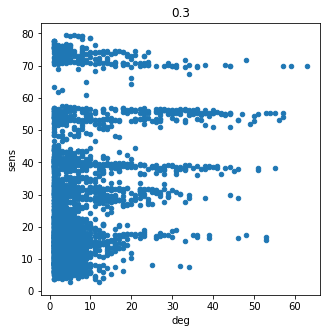

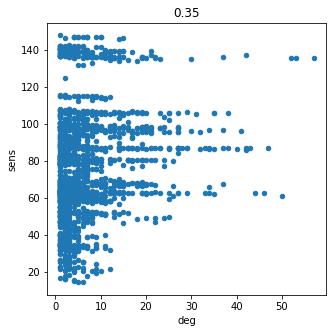

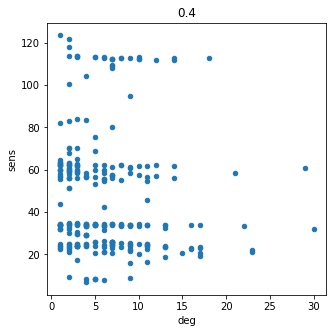

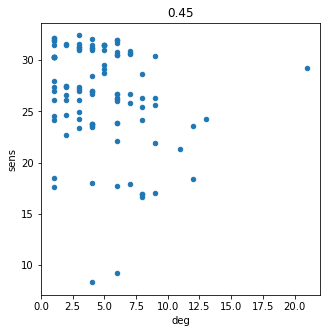

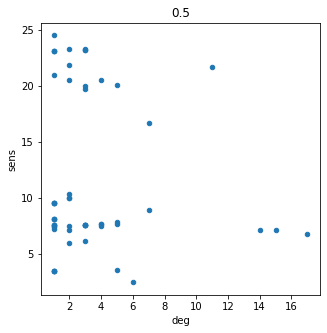

In [313]:
for i in thr_list:
    fig, ax = plt.subplots(figsize=(5,5))
    pcc_dfs[i].plot.scatter('deg','sens',ax=ax)
    ax.set_title(i)

In [159]:
sensor_dfs[0.3]

,orf_name,deg,eff,sens,trans,eigenvec_centr,closeness_centr,smallest_eigenvec,neighbor_degree,gene1,Systematic gene name,sensor_cluster,go_group
0,cem1,8,19.024903,78.248422,0.750000,7.988143e-11,0.113984,-0.002448,8.625000,cem1,YER061C,1.0,fatty acid metabolic process
1,aim22,10,19.812154,78.439643,0.622222,8.017645e-11,0.113994,-0.002453,7.700000,aim22,YJL046W,1.0,fatty acid metabolic process
2,etr1,7,15.270061,79.220229,0.809524,7.782998e-12,0.102357,-0.002468,7.857143,etr1,YBR026C,1.0,fatty acid metabolic process
3,htd2,8,16.001813,79.218922,0.821429,8.004045e-12,0.102361,-0.002468,7.625000,htd2,YHR067W,1.0,fatty acid metabolic process
4,lip2,10,19.812154,78.439643,0.622222,8.017645e-11,0.113994,-0.002453,7.700000,lip2,YLR239C,1.0,fatty acid metabolic process
5,lip5,8,16.001813,79.218922,0.821429,8.004042e-12,0.102361,-0.002468,7.625000,lip5,YOR196C,1.0,fatty acid metabolic process
6,lpd1,4,11.344847,79.383812,0.833333,5.021902e-12,0.102345,-0.002473,8.250000,lpd1,YFL018C,1.0,fatty acid metabolic process
7,lpd1-supp1,5,13.286361,79.167241,1.000000,7.412230e-12,0.102349,-0.002467,8.800000,lpd1-supp1,YFL018C,1.0,fatty acid metabolic process
8,mct1,7,15.259172,79.223154,0.904762,7.795662e-12,0.102357,-0.002468,8.142857,mct1,YOR221C,1.0,fatty acid metabolic process
9,oar1,6,13.971691,79.367389,0.800000,5.472296e-12,0.102353,-0.002471,7.833333,oar1,YKL055C,1.0,fatty acid metabolic process


In [257]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns



# Redefine sensors/effectors

In [416]:
%load_ext rpy2.ipython

/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [430]:
thr = 0.2
dff = pcc_dfs[thr].drop('sensor_on_larger_thr',axis=1)

In [482]:
#Import the SignatureTranslatedAnonymousPackage 
from rpy2.robjects.packages import STAP
import rpy2.robjects as ro
#Read the file with the R code snippet
with open('../R/compare_clustering.R', 'r') as f:
    string = f.read()
#Parse using STAP
r_func = STAP(string, "compare_clustering")

In [431]:
%%R

library(Ckmeans.1d.dp)
library(tidyverse)
library(glue)
compare_clustering <- function(filename, number_of_clusters, column_name){
    df <- readr::read_csv(filename)
    res <- Ckmeans.1d.dp(pull(df[column_name]),number_of_clusters)
  #  plotBIC(res)
    df$ck = res$cluster
  #  df$color = df$ck#>quantile(unique(df$ck),quantile_threshold)
#     ggplot(df, aes_string(x='deg',y=column_name,color="color"))+
#         geom_point()
    return(df)
}

In [479]:
from enm.utils import *
#goea, geneid2name = create_goea()

In [451]:
def get_go_enrichment_by_cluster(clustered_df, cluster_column_name, goea, geneid2name):
    go_res = {}
    for i in sorted(clustered_df[cluster_column_name].unique()):
        orf_list = clustered_df.loc[clustered_df[cluster_column_name]==i]
        go_df = query_goatools(orf_list, goea, geneid2name)
        go_res[i] = go_df
    return go_res

In [493]:
def go_for_a_threshold(thr, column_name,goea, geneid2name):
    #%%R -i dff -i thr -o clustered_df
    clustered_df= convert_rpy2_to_pandas(r_func.compare_clustering(f'../data/interim_{thr}/pcc_df.csv',ro.IntVector((2,50)), column_name))
    go_res = get_go_enrichment_by_cluster(clustered_df, 'ck', goea, geneid2name)
    return clustered_df, go_res

In [ ]:
clustered_dfs_sens = {}
clustered_dfs_eff = {}

go_res_all_sens = {}
go_res_all_eff = {}

for i in thr_list:
    clustered_df_sens, go_res_sensor = go_for_a_threshold(i, 'sens',goea, geneid2name)
    clustered_df_eff, go_res_eff = go_for_a_threshold(i, 'eff',goea, geneid2name)
    clustered_dfs_sens[i] = clustered_df_sens
    clustered_dfs_eff[i] = clustered_df_eff
    go_res_all_sens[i] = go_res_sensor
    go_res_all_eff[i] = go_res_eff

R[write to console]: Parsed with column specification:
cols(
  orf_name_id = col_double(),
  orf_name = col_character(),
  deg = col_double(),
  eff = col_double(),
  sens = col_double(),
  trans = col_double(),
  eigenvec_centr = col_double(),
  closeness_centr = col_double(),
  smallest_eigenvec = col_double(),
  neighbor_degree = col_double(),
  gene1 = col_character(),
  `Systematic gene name` = col_character()
)




Run BP Gene Ontology Analysis: current study set of 3300 IDs ... 86%  2,826 of  3,300 study items found in association
100%  3,300 of  3,300 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   4,444 GO terms are associated with  2,811 of  3,300 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008871994398930844
Sample 10 / 500: p-value 0.0007063697333222938
Sample 20 / 500: p-value 0.0004367429397704225
Sample 30 / 500: p-value 0.0008231865229444503
Sample 40 / 500: p-value 0.0003414876681957894
Sample 50 / 500: p-value 0.0006841167563604107
Sample 60 / 500: p-value 0.001279754202872231
Sample 70 / 500: p-value 0.004918643069566806
Sample 80 / 500: p-value 0.00020073766288178932
Sample 90 / 500: p-value 0.0003295177999662638
Sample 100 / 500: p-value 0.0005805665261955397
Sample 110 / 500: p-value 0.001509077465294875
Sample 120 / 500: p-value 0.0007363664783726948
Sample 130 / 500: p-value 0.001986323545214827
Sample 140 / 500: p-value 8.532055379368631e-05
Sample 150 / 500: p-value 0.001509077465294875
Sample 160 / 500: p-value 0.0010778013991226316
Sample 170 / 500: p-value 0.0019931847588718966
Sample 180 / 500: p-value 0.001986323545214827
Sample 190 / 500: p-

  METHOD fdr:
     118 GO terms found significant (< 0.1=alpha) (118 enriched +   0 purified): local fdr
   2,811 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 3300 IDs ... 91%  3,014 of  3,300 study items found in association
100%  3,300 of  3,300 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     940 GO terms are associated with  3,014 of  3,300 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.006255452855942264
Sample 10 / 500: p-value 0.0031999394537317208
Sample 20 / 500: p-value 0.00672109311640727
Sample 30 / 500: p-value 0.0003459883272907417
Sample 40 / 500: p-value 0.03933313666174078
Sample 50 / 500: p-value 0.0016885954043519764
Sample 60 / 500: p-value 0.009719559646196278
Sample 70 / 500: p-value 0.004071775134768441
Sample 80 / 500: p-value 0.0016812449252460722
Sample 90 / 500: p-value 0.0031999394537317208
Sample 100 / 500: p-value 0.0010778013991226316
Sample 110 / 500: p-value 0.0018517151856173005
Sample 120 / 500: p-value 0.0055635213692299575
Sample 130 / 500: p-value 0.0071459847634885824
Sample 140 / 500: p-value 0.004071775134768441
Sample 150 / 500: p-value 0.004691353706472303
Sample 160 / 500: p-value 0.0044253785301498795
Sample 170 / 500: p-value 0.006618079373681447
Sample 180 / 500: p-value 0.00016361756135009752
Sample 190 / 500: p-valu

  METHOD fdr:
      38 GO terms found significant (< 0.1=alpha) ( 34 enriched +   4 purified): local fdr
   3,014 study items associated with significant GO IDs (enriched)
      28 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 3300 IDs ... 75%  2,472 of  3,300 study items found in association
100%  3,300 of  3,300 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
   1,868 GO terms are associated with  2,472 of  3,300 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009238071233449742
Sample 10 / 500: p-value 0.003968705778989673
Sample 20 / 500: p-value 0.011723219666859052
Sample 30 / 500: p-value 0.001509077465294875
Sample 40 / 500: p-value 0.0031999394537317208
Sample 50 / 500: p-value 0.003414021303106747
Sample 60 / 500: p-value 0.00293566675987503
Sample 70 / 500: p-value 0.0015099165903186599
Sample 80 / 500: p-value 0.0023907568642448115
Sample 90 / 500: p-value 0.0072223923673799826
Sample 100 / 500: p-value 0.0007063697333222938
Sample 110 / 500: p-value 0.000609066915727526
Sample 120 / 500: p-value 0.00039351353865256907
Sample 130 / 500: p-value 0.0007728947787040566
Sample 140 / 500: p-value 0.005499663262482667
Sample 150 / 500: p-value 0.011524941068600275
Sample 160 / 500: p-value 0.011166381850965015
Sample 170 / 500: p-value 0.00934436066787038
Sample 180 / 500: p-value 0.005940150457211184
Sample 190 / 500: p-value 0

  METHOD fdr:
       5 GO terms found significant (< 0.1=alpha) (  5 enriched +   0 purified): local fdr
   2,472 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 2149 IDs ... 80%  1,720 of  2,149 study items found in association
100%  2,149 of  2,149 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   3,784 GO terms are associated with  1,711 of  2,149 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00034416817375692676
Sample 10 / 500: p-value 0.0003238860780119129
Sample 20 / 500: p-value 4.225938345329131e-05
Sample 30 / 500: p-value 0.0025415789889122547
Sample 40 / 500: p-value 0.002632865003739447
Sample 50 / 500: p-value 0.0014301427274423237
Sample 60 / 500: p-value 0.0013961681587545288
Sample 70 / 500: p-value 0.0003456865916276779
Sample 80 / 500: p-value 0.00038188216111660416
Sample 90 / 500: p-value 0.0014451492478691327
Sample 100 / 500: p-value 0.0008256855965790021
Sample 110 / 500: p-value 0.0020933004899070214
Sample 120 / 500: p-value 0.0003460321025102539
Sample 130 / 500: p-value 8.725501711828752e-05
Sample 140 / 500: p-value 0.001092589542055111
Sample 150 / 500: p-value 0.0002579215888002141
Sample 160 / 500: p-value 0.0025415789889122547
Sample 170 / 500: p-value 0.000892155670965027
Sample 180 / 500: p-value 0.0006899144521659271
Sample 190 / 500

  METHOD fdr:
      38 GO terms found significant (< 0.1=alpha) (  0 enriched +  38 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
     768 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 2149 IDs ... 85%  1,832 of  2,149 study items found in association
100%  2,149 of  2,149 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     815 GO terms are associated with  1,831 of  2,149 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 6.480908423579634e-05
Sample 10 / 500: p-value 0.0044849771753563885
Sample 20 / 500: p-value 0.0015962058276596637
Sample 30 / 500: p-value 0.0012254881206967409
Sample 40 / 500: p-value 0.005081276261632419
Sample 50 / 500: p-value 0.0031412549085001137
Sample 60 / 500: p-value 0.0025415789889122547
Sample 70 / 500: p-value 0.015539191462603841
Sample 80 / 500: p-value 0.003107000038211372
Sample 90 / 500: p-value 0.0011034779434318043
Sample 100 / 500: p-value 0.0038854659760717662
Sample 110 / 500: p-value 0.0025619618834913835
Sample 120 / 500: p-value 0.00234724520472673
Sample 130 / 500: p-value 0.005722007960047079
Sample 140 / 500: p-value 0.0053418609997453095
Sample 150 / 500: p-value 0.006440092177832902
Sample 160 / 500: p-value 0.005301040965253818
Sample 170 / 500: p-value 0.0016742172566635417
Sample 180 / 500: p-value 0.0008527293982584425
Sample 190 / 500: p-val

  METHOD fdr:
       6 GO terms found significant (< 0.1=alpha) (  1 enriched +   5 purified): local fdr
      49 study items associated with significant GO IDs (enriched)
   1,831 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 2149 IDs ... 69%  1,485 of  2,149 study items found in association
100%  2,149 of  2,149 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
   1,540 GO terms are associated with  1,484 of  2,149 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00012762355408683834
Sample 10 / 500: p-value 0.006885023678969681
Sample 20 / 500: p-value 0.0024410327660015856
Sample 30 / 500: p-value 0.0038854659760717662
Sample 40 / 500: p-value 0.0018654654497260832
Sample 50 / 500: p-value 0.0016366556959503406
Sample 60 / 500: p-value 0.005081276261632419
Sample 70 / 500: p-value 0.0020933004899070214
Sample 80 / 500: p-value 0.001945915929954433
Sample 90 / 500: p-value 0.005478505601227136
Sample 100 / 500: p-value 0.00012762355408683834
Sample 110 / 500: p-value 0.0010970499522665457
Sample 120 / 500: p-value 0.0020933004899070214
Sample 130 / 500: p-value 0.005081276261632419
Sample 140 / 500: p-value 0.0027668346529723985
Sample 150 / 500: p-value 0.00033198495450271993
Sample 160 / 500: p-value 0.005309654294765231
Sample 170 / 500: p-value 0.001524627383539279
Sample 180 / 500: p-value 0.0031412549085001137
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 376 IDs ... 68%    256 of    376 study items found in association
100%    376 of    376 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   1,755 GO terms are associated with    253 of    376 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0015506597219317692
Sample 10 / 500: p-value 0.002434009572457789
Sample 20 / 500: p-value 0.002162568811458062
Sample 30 / 500: p-value 0.001672324893166671
Sample 40 / 500: p-value 0.0005974287896257941
Sample 50 / 500: p-value 0.01177238991208144
Sample 60 / 500: p-value 0.0005658485908138325
Sample 70 / 500: p-value 0.0010226865261989692
Sample 80 / 500: p-value 0.0023732470011231317
Sample 90 / 500: p-value 0.00021345375430320025
Sample 100 / 500: p-value 0.0010226865261989692
Sample 110 / 500: p-value 0.0005464973314555747
Sample 120 / 500: p-value 0.0001354018138677217
Sample 130 / 500: p-value 0.0003542206220822601
Sample 140 / 500: p-value 0.0010053886347896116
Sample 150 / 500: p-value 0.000757552472222427
Sample 160 / 500: p-value 0.0005974287896257941
Sample 170 / 500: p-value 0.00011185369155208892
Sample 180 / 500: p-value 0.0018146184534433105
Sample 190 / 500: p

  METHOD fdr:
      21 GO terms found significant (< 0.1=alpha) (  0 enriched +  21 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
     253 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 376 IDs ... 72%    270 of    376 study items found in association
100%    376 of    376 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     327 GO terms are associated with    270 of    376 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004635151892279599
Sample 10 / 500: p-value 0.004173430485293859
Sample 20 / 500: p-value 0.004173430485293859
Sample 30 / 500: p-value 0.0031703968942088396
Sample 40 / 500: p-value 0.004635151892279599
Sample 50 / 500: p-value 0.002434009572457789
Sample 60 / 500: p-value 0.011983081680641236
Sample 70 / 500: p-value 0.007724786996345362
Sample 80 / 500: p-value 0.006063543747359856
Sample 90 / 500: p-value 0.004173430485293859
Sample 100 / 500: p-value 0.0014238731685531638
Sample 110 / 500: p-value 0.004173430485293859
Sample 120 / 500: p-value 0.0007582618473464214
Sample 130 / 500: p-value 0.0031652105471138806
Sample 140 / 500: p-value 0.017586368996179644
Sample 150 / 500: p-value 0.002434009572457789
Sample 160 / 500: p-value 0.0035647003118662213
Sample 170 / 500: p-value 0.00032459169765121224
Sample 180 / 500: p-value 0.004173430485293859
Sample 190 / 500: p-value 0

  METHOD fdr:
      12 GO terms found significant (< 0.1=alpha) (  0 enriched +  12 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
     270 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 376 IDs ... 58%    218 of    376 study items found in association
100%    376 of    376 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     588 GO terms are associated with    218 of    376 study items


Sample 10 / 500: p-value 0.0016172916685179852
Sample 20 / 500: p-value 1.1341309420076265e-05
Sample 30 / 500: p-value 0.0009918106094900705
Sample 40 / 500: p-value 0.0003692114468294751
Sample 50 / 500: p-value 0.004173430485293859
Sample 60 / 500: p-value 0.0010226865261989692
Sample 70 / 500: p-value 0.0010226865261989692
Sample 80 / 500: p-value 0.001672324893166671
Sample 90 / 500: p-value 0.0002686048875396
Sample 100 / 500: p-value 0.002434009572457789
Sample 110 / 500: p-value 0.0021595785452373853
Sample 120 / 500: p-value 0.003947706807447164
Sample 130 / 500: p-value 0.004173430485293859
Sample 140 / 500: p-value 0.0024948940037821934
Sample 150 / 500: p-value 0.0023585533971968776
Sample 160 / 500: p-value 5.774598832646682e-05
Sample 170 / 500: p-value 0.0003538827067766787
Sample 180 / 500: p-value 0.002645961415886929
Sample 190 / 500: p-value 0.004173430485293859
Sample 200 / 500: p-value 0.004173430485293859
Sample 210 / 500: p-value 0.0029656653846764757
Sample 220 

  METHOD fdr:
       3 GO terms found significant (< 0.1=alpha) (  0 enriched +   3 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
     218 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 3420 IDs ... 81%  2,758 of  3,420 study items found in association
100%  3,420 of  3,420 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   4,378 GO terms are associated with  2,738 of  3,420 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0023714613962181616
Sample 10 / 500: p-value 0.0007055635361028291
Sample 20 / 500: p-value 0.000840863059477867
Sample 30 / 500: p-value 0.00022635516383244435
Sample 40 / 500: p-value 0.0006717242971213297
Sample 50 / 500: p-value 0.002131119104999798
Sample 60 / 500: p-value 0.002121264614134098
Sample 70 / 500: p-value 0.0009529056492914754
Sample 80 / 500: p-value 0.005824758662776793
Sample 90 / 500: p-value 0.0005471270293321395
Sample 100 / 500: p-value 0.00017966208773864247
Sample 110 / 500: p-value 0.0007392766682049456
Sample 120 / 500: p-value 0.0008963658988505721
Sample 130 / 500: p-value 0.002357956560869332
Sample 140 / 500: p-value 0.002209441476750024
Sample 150 / 500: p-value 0.0045850532959187265
Sample 160 / 500: p-value 0.0014130374927485893
Sample 170 / 500: p-value 0.0012389350367448854
Sample 180 / 500: p-value 0.002121264614134098
Sample 190 / 500: p-

  METHOD fdr:
      81 GO terms found significant (< 0.1=alpha) (  1 enriched +  80 purified): local fdr
      85 study items associated with significant GO IDs (enriched)
   2,738 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 3420 IDs ... 86%  2,944 of  3,420 study items found in association
100%  3,420 of  3,420 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     925 GO terms are associated with  2,943 of  3,420 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016845773322055123
Sample 10 / 500: p-value 0.0038569534695531444
Sample 20 / 500: p-value 0.002430957705568808
Sample 30 / 500: p-value 0.009936267543014734
Sample 40 / 500: p-value 0.00017966208773864247
Sample 50 / 500: p-value 0.003764442952749128
Sample 60 / 500: p-value 0.0010019005154148564
Sample 70 / 500: p-value 0.003067483761143438
Sample 80 / 500: p-value 0.0033105750100136983
Sample 90 / 500: p-value 0.0038569534695531444
Sample 100 / 500: p-value 9.664389323715902e-05
Sample 110 / 500: p-value 0.010429120754406707
Sample 120 / 500: p-value 0.0015025070156854978
Sample 130 / 500: p-value 0.008222249697128129
Sample 140 / 500: p-value 3.674095521808714e-05
Sample 150 / 500: p-value 0.0036602569553310124
Sample 160 / 500: p-value 0.0056993602323492125
Sample 170 / 500: p-value 0.00022581999473774217
Sample 180 / 500: p-value 0.0045850532959187265
Sample 190 / 500: p

  METHOD fdr:
      32 GO terms found significant (< 0.1=alpha) (  0 enriched +  32 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
   2,943 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 3420 IDs ... 69%  2,374 of  3,420 study items found in association
100%  3,420 of  3,420 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
   1,941 GO terms are associated with  2,374 of  3,420 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003764442952749128
Sample 10 / 500: p-value 0.002121264614134098
Sample 20 / 500: p-value 0.003764442952749128
Sample 30 / 500: p-value 0.0013868590707785335
Sample 40 / 500: p-value 0.0014805807031270338
Sample 50 / 500: p-value 0.0038569534695531444
Sample 60 / 500: p-value 0.004679750302075248
Sample 70 / 500: p-value 0.002131119104999798
Sample 80 / 500: p-value 0.0038516882537311795
Sample 90 / 500: p-value 0.0010481234478129794
Sample 100 / 500: p-value 0.002041448061373821
Sample 110 / 500: p-value 0.0009529056492914754
Sample 120 / 500: p-value 0.0010481234478129794
Sample 130 / 500: p-value 0.00035673856559673026
Sample 140 / 500: p-value 0.00824256752984924
Sample 150 / 500: p-value 0.0027288256330841327
Sample 160 / 500: p-value 0.006554032714562029
Sample 170 / 500: p-value 0.0027159378493414894
Sample 180 / 500: p-value 0.0011905980263052355
Sample 190 / 500: p-val

  METHOD fdr:
       6 GO terms found significant (< 0.1=alpha) (  0 enriched +   6 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
   2,374 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 2410 IDs ... 85%  2,049 of  2,410 study items found in association
100%  2,410 of  2,410 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   4,098 GO terms are associated with  2,042 of  2,410 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002790012447570423
Sample 10 / 500: p-value 0.0011229894425097793
Sample 20 / 500: p-value 0.00035871237068080513
Sample 30 / 500: p-value 0.0008669131189873267
Sample 40 / 500: p-value 0.0003318367383700562
Sample 50 / 500: p-value 0.0008375963575336241
Sample 60 / 500: p-value 0.0004122118675507359
Sample 70 / 500: p-value 0.0005077949808247913
Sample 80 / 500: p-value 5.076122524502065e-05
Sample 90 / 500: p-value 0.010549014354961214
Sample 100 / 500: p-value 0.00017864141506999639
Sample 110 / 500: p-value 0.0004350486921302316
Sample 120 / 500: p-value 0.0010185950379064037
Sample 130 / 500: p-value 0.0015308283938372251
Sample 140 / 500: p-value 0.00035871237068080513
Sample 150 / 500: p-value 0.003069940451972975
Sample 160 / 500: p-value 0.0015308283938372251
Sample 170 / 500: p-value 0.0007461739980194574
Sample 180 / 500: p-value 0.00018740782529828555
Sample 190 / 5

  METHOD fdr:
     118 GO terms found significant (< 0.1=alpha) (116 enriched +   2 purified): local fdr
   2,042 study items associated with significant GO IDs (enriched)
      33 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 2410 IDs ... 90%  2,177 of  2,410 study items found in association
100%  2,410 of  2,410 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     887 GO terms are associated with  2,177 of  2,410 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00507827576690232
Sample 10 / 500: p-value 0.002094589083996899
Sample 20 / 500: p-value 0.0002138877101165302
Sample 30 / 500: p-value 0.00505960017083677
Sample 40 / 500: p-value 0.011345541559225956
Sample 50 / 500: p-value 2.5517942920428305e-05
Sample 60 / 500: p-value 0.012218776628938116
Sample 70 / 500: p-value 0.01913401510455098
Sample 80 / 500: p-value 0.0008669131189873267
Sample 90 / 500: p-value 0.0016593272130853152
Sample 100 / 500: p-value 0.0060459664571353225
Sample 110 / 500: p-value 0.0008834600288501936
Sample 120 / 500: p-value 0.002401347689732763
Sample 130 / 500: p-value 0.00509837890505043
Sample 140 / 500: p-value 0.0006836459538261372
Sample 150 / 500: p-value 0.0009003122734523199
Sample 160 / 500: p-value 7.145798509197e-05
Sample 170 / 500: p-value 0.0006565775764923239
Sample 180 / 500: p-value 0.0058420142504941736
Sample 190 / 500: p-value 0.0

  METHOD fdr:
      27 GO terms found significant (< 0.1=alpha) ( 27 enriched +   0 purified): local fdr
   2,177 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 2410 IDs ... 75%  1,804 of  2,410 study items found in association
100%  2,410 of  2,410 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
   1,569 GO terms are associated with  1,803 of  2,410 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0031403138824209345
Sample 10 / 500: p-value 0.002094589083996899
Sample 20 / 500: p-value 0.002790012447570423
Sample 30 / 500: p-value 0.002251593793277626
Sample 40 / 500: p-value 0.005939880506440679
Sample 50 / 500: p-value 0.002094589083996899
Sample 60 / 500: p-value 0.0008375963575336241
Sample 70 / 500: p-value 0.004320434206132759
Sample 80 / 500: p-value 0.0020067211012788737
Sample 90 / 500: p-value 0.002094589083996899
Sample 100 / 500: p-value 0.00145780020761639
Sample 110 / 500: p-value 0.012218776628938116
Sample 120 / 500: p-value 0.002333072483581049
Sample 130 / 500: p-value 0.00505960017083677
Sample 140 / 500: p-value 0.006918039045255044
Sample 150 / 500: p-value 0.0003593089818444362
Sample 160 / 500: p-value 0.0020046037234621402
Sample 170 / 500: p-value 0.00035871237068080513
Sample 180 / 500: p-value 0.0015069583137753818
Sample 190 / 500: p-value 0.

  METHOD fdr:
       5 GO terms found significant (< 0.1=alpha) (  5 enriched +   0 purified): local fdr
   1,803 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 3302 IDs ... 82%  2,722 of  3,302 study items found in association
100%  3,302 of  3,302 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   4,424 GO terms are associated with  2,706 of  3,302 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003178666292980365
Sample 10 / 500: p-value 0.0005102981914308772
Sample 20 / 500: p-value 0.006603173333609838
Sample 30 / 500: p-value 0.0007703124109542099
Sample 40 / 500: p-value 0.005408253681780356
Sample 50 / 500: p-value 0.001078221149951797
Sample 60 / 500: p-value 0.0012320983032855705
Sample 70 / 500: p-value 0.003178666292980365
Sample 80 / 500: p-value 0.0017144163749158823
Sample 90 / 500: p-value 0.0014597106814585922
Sample 100 / 500: p-value 0.00012643233221633043
Sample 110 / 500: p-value 0.002644311827183991
Sample 120 / 500: p-value 0.0005768727332997706
Sample 130 / 500: p-value 0.005722911194727189
Sample 140 / 500: p-value 0.00011352210669304565
Sample 150 / 500: p-value 0.000868885322863426
Sample 160 / 500: p-value 0.0015470956206898663
Sample 170 / 500: p-value 0.0005102981914308772
Sample 180 / 500: p-value 0.0009144987291555989
Sample 190 / 500: p-v

  METHOD fdr:
      52 GO terms found significant (< 0.1=alpha) ( 43 enriched +   9 purified): local fdr
   1,618 study items associated with significant GO IDs (enriched)
      43 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 3302 IDs ... 89%  2,927 of  3,302 study items found in association
100%  3,302 of  3,302 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     926 GO terms are associated with  2,927 of  3,302 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.012814132926443848
Sample 10 / 500: p-value 0.005581973373129303
Sample 20 / 500: p-value 0.002467229403763516
Sample 30 / 500: p-value 0.0009601121514187824
Sample 40 / 500: p-value 0.0034058588705395956
Sample 50 / 500: p-value 0.0010150905143117396
Sample 60 / 500: p-value 0.0065208753554351385
Sample 70 / 500: p-value 0.0007005640265327392
Sample 80 / 500: p-value 0.004512904903642533
Sample 90 / 500: p-value 0.0011172600196563747
Sample 100 / 500: p-value 0.00149786044907081
Sample 110 / 500: p-value 0.0008826986447878078
Sample 120 / 500: p-value 0.0004921421995164046
Sample 130 / 500: p-value 0.005477042145311938
Sample 140 / 500: p-value 0.0003141636321541929
Sample 150 / 500: p-value 0.0017360184495294518
Sample 160 / 500: p-value 3.7388197392348977e-06
Sample 170 / 500: p-value 0.0006942507368555004
Sample 180 / 500: p-value 0.0034108047002145638
Sample 190 / 500: p-v

  METHOD fdr:
      16 GO terms found significant (< 0.1=alpha) ( 13 enriched +   3 purified): local fdr
   1,179 study items associated with significant GO IDs (enriched)
       8 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 3302 IDs ... 72%  2,391 of  3,302 study items found in association
100%  3,302 of  3,302 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
   1,833 GO terms are associated with  2,390 of  3,302 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009762858100200401
Sample 10 / 500: p-value 0.0010743115157393567
Sample 20 / 500: p-value 0.0014603026135207985
Sample 30 / 500: p-value 0.006647705008501689
Sample 40 / 500: p-value 0.00041095318415467993
Sample 50 / 500: p-value 0.009522881314791457
Sample 60 / 500: p-value 8.421538537612784e-05
Sample 70 / 500: p-value 0.014247522993434313
Sample 80 / 500: p-value 0.009439332262186633
Sample 90 / 500: p-value 0.0017369308319660497
Sample 100 / 500: p-value 0.0028984987388584395
Sample 110 / 500: p-value 0.0007005640265327392
Sample 120 / 500: p-value 0.0013455376033640728
Sample 130 / 500: p-value 0.003178666292980365
Sample 140 / 500: p-value 0.003399805718808524
Sample 150 / 500: p-value 0.006603173333609838
Sample 160 / 500: p-value 0.006655684691031999
Sample 170 / 500: p-value 4.9700739798594586e-05
Sample 180 / 500: p-value 2.5964616549698005e-05
Sample 190 / 500: p-

  METHOD fdr:
       4 GO terms found significant (< 0.1=alpha) (  3 enriched +   1 purified): local fdr
      78 study items associated with significant GO IDs (enriched)
      13 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 2010 IDs ... 85%  1,714 of  2,010 study items found in association
100%  2,010 of  2,010 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   3,777 GO terms are associated with  1,708 of  2,010 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004341307740928739
Sample 10 / 500: p-value 0.0011347208032233957
Sample 20 / 500: p-value 0.00027390182477449003
Sample 30 / 500: p-value 0.004392063338114159
Sample 40 / 500: p-value 0.0015724061409112806
Sample 50 / 500: p-value 0.0012637331902275687
Sample 60 / 500: p-value 0.00042962831226677476
Sample 70 / 500: p-value 0.000181857588547821
Sample 80 / 500: p-value 0.00014020094502564698
Sample 90 / 500: p-value 0.0005869449243174646
Sample 100 / 500: p-value 0.0004816506532494944
Sample 110 / 500: p-value 0.0005191097523999965
Sample 120 / 500: p-value 0.0004816506532494944
Sample 130 / 500: p-value 6.81253385110792e-05
Sample 140 / 500: p-value 0.0021288902002002128
Sample 150 / 500: p-value 0.0008063443932867856
Sample 160 / 500: p-value 0.004926785912329477
Sample 170 / 500: p-value 0.00032214373858840435
Sample 180 / 500: p-value 0.002567352316868279
Sample 190 / 500:

  METHOD fdr:
      90 GO terms found significant (< 0.1=alpha) ( 58 enriched +  32 purified): local fdr
   1,708 study items associated with significant GO IDs (enriched)
     435 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 2010 IDs ... 89%  1,796 of  2,010 study items found in association
100%  2,010 of  2,010 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     834 GO terms are associated with  1,796 of  2,010 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0020013339561510335
Sample 10 / 500: p-value 0.0014929849063783126
Sample 20 / 500: p-value 0.013124090476100905
Sample 30 / 500: p-value 9.573270186694195e-05
Sample 40 / 500: p-value 0.003052530649556171
Sample 50 / 500: p-value 0.004926785912329477
Sample 60 / 500: p-value 0.006629864608811945
Sample 70 / 500: p-value 0.0017007930017474149
Sample 80 / 500: p-value 0.008193804490371957
Sample 90 / 500: p-value 0.003548688453948943
Sample 100 / 500: p-value 0.0017007930017474149
Sample 110 / 500: p-value 0.0017007930017474149
Sample 120 / 500: p-value 0.009986507144140198
Sample 130 / 500: p-value 0.0070078089371483345
Sample 140 / 500: p-value 0.009939330078909481
Sample 150 / 500: p-value 0.004926785912329477
Sample 160 / 500: p-value 0.0012637331902275687
Sample 170 / 500: p-value 0.00578183664096986
Sample 180 / 500: p-value 8.523360996871401e-05
Sample 190 / 500: p-value 

  METHOD fdr:
      30 GO terms found significant (< 0.1=alpha) ( 29 enriched +   1 purified): local fdr
   1,724 study items associated with significant GO IDs (enriched)
      15 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 2010 IDs ... 73%  1,471 of  2,010 study items found in association
100%  2,010 of  2,010 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
   1,522 GO terms are associated with  1,471 of  2,010 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012637331902275687
Sample 10 / 500: p-value 0.0033020879060522224
Sample 20 / 500: p-value 0.003364462840894965
Sample 30 / 500: p-value 0.0017007930017474149
Sample 40 / 500: p-value 0.007630895741263191
Sample 50 / 500: p-value 0.004926785912329477
Sample 60 / 500: p-value 0.004926785912329477
Sample 70 / 500: p-value 0.0015070161447713556
Sample 80 / 500: p-value 0.012191173067781363
Sample 90 / 500: p-value 0.002842706966253962
Sample 100 / 500: p-value 0.007041307776123507
Sample 110 / 500: p-value 0.00035047359236413747
Sample 120 / 500: p-value 0.0007341129713120703
Sample 130 / 500: p-value 0.003278136937769551
Sample 140 / 500: p-value 0.0007056722185597944
Sample 150 / 500: p-value 0.004392063338114159
Sample 160 / 500: p-value 0.006629864608811945
Sample 170 / 500: p-value 0.00898040416484932
Sample 180 / 500: p-value 0.014267048536764406
Sample 190 / 500: p-value 0

  METHOD fdr:
       5 GO terms found significant (< 0.1=alpha) (  4 enriched +   1 purified): local fdr
     158 study items associated with significant GO IDs (enriched)
       9 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 379 IDs ... 72%    272 of    379 study items found in association
100%    379 of    379 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   1,919 GO terms are associated with    268 of    379 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.006701943645216374
Sample 10 / 500: p-value 0.0017787319568859311
Sample 20 / 500: p-value 0.0010470018505823091
Sample 30 / 500: p-value 0.0036310824753221825
Sample 40 / 500: p-value 0.0006993255218970475
Sample 50 / 500: p-value 0.0001859476903413242
Sample 60 / 500: p-value 0.0006198214389865631
Sample 70 / 500: p-value 0.0005316686885635593
Sample 80 / 500: p-value 0.000602539558182664
Sample 90 / 500: p-value 0.0010087774307932507
Sample 100 / 500: p-value 0.004741537012846322
Sample 110 / 500: p-value 0.0031750883081112587
Sample 120 / 500: p-value 0.0008276400752756176
Sample 130 / 500: p-value 0.0002751031454359621
Sample 140 / 500: p-value 0.004063500570610627
Sample 150 / 500: p-value 1.5506623836893087e-05
Sample 160 / 500: p-value 0.00014137167212424295
Sample 170 / 500: p-value 0.0006198214389865631
Sample 180 / 500: p-value 0.00030424330630874643
Sample 190 / 500

  METHOD fdr:
      30 GO terms found significant (< 0.1=alpha) (  0 enriched +  30 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
     268 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 379 IDs ... 78%    294 of    379 study items found in association
100%    379 of    379 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     307 GO terms are associated with    294 of    379 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0021439117833384497
Sample 10 / 500: p-value 0.0006198214389865631
Sample 20 / 500: p-value 0.0033393609846516124
Sample 30 / 500: p-value 0.00211538075072506
Sample 40 / 500: p-value 0.0010470018505823091
Sample 50 / 500: p-value 0.0002466740313321457
Sample 60 / 500: p-value 0.0014049682649899002
Sample 70 / 500: p-value 0.0005878726072582003
Sample 80 / 500: p-value 0.004240382965849203
Sample 90 / 500: p-value 0.005095741532365499
Sample 100 / 500: p-value 0.0017228378532722262
Sample 110 / 500: p-value 0.0011395558114888624
Sample 120 / 500: p-value 0.0010470018505823091
Sample 130 / 500: p-value 0.0003902785190404442
Sample 140 / 500: p-value 0.0041636954571439315
Sample 150 / 500: p-value 0.00578534013645343
Sample 160 / 500: p-value 0.01217094260662244
Sample 170 / 500: p-value 0.004215460989611094
Sample 180 / 500: p-value 0.0005316686885635593
Sample 190 / 500: p-valu

  METHOD fdr:
      16 GO terms found significant (< 0.1=alpha) (  0 enriched +  16 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
     294 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 379 IDs ... 61%    232 of    379 study items found in association
100%    379 of    379 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     608 GO terms are associated with    232 of    379 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006578778509962615
Sample 10 / 500: p-value 0.007898938256109154
Sample 20 / 500: p-value 4.501988347048838e-06
Sample 30 / 500: p-value 0.004240382965849203
Sample 40 / 500: p-value 0.004240382965849203
Sample 50 / 500: p-value 0.0033290660025076606
Sample 60 / 500: p-value 0.004240382965849203
Sample 70 / 500: p-value 0.002249178033729226
Sample 80 / 500: p-value 0.004240382965849203
Sample 90 / 500: p-value 0.004063500570610627
Sample 100 / 500: p-value 0.0027498369658617698
Sample 110 / 500: p-value 0.002490873658167294
Sample 120 / 500: p-value 0.0005792752521886723
Sample 130 / 500: p-value 0.004240382965849203
Sample 140 / 500: p-value 0.0014098229177859653
Sample 150 / 500: p-value 5.124662830853838e-07
Sample 160 / 500: p-value 0.0020213517505481954
Sample 170 / 500: p-value 0.0028786149091120333
Sample 180 / 500: p-value 0.0005316686885635593
Sample 190 / 500: p-valu

  METHOD fdr:
       3 GO terms found significant (< 0.1=alpha) (  0 enriched +   3 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
     232 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 81 IDs ... 59%     48 of     81 study items found in association
100%     81 of     81 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     759 GO terms are associated with     48 of     81 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0035434167289779012
Sample 10 / 500: p-value 0.00802680045839363
Sample 20 / 500: p-value 0.0033163302019400646
Sample 30 / 500: p-value 0.0031106560364551894
Sample 40 / 500: p-value 0.00019180020953784397
Sample 50 / 500: p-value 0.0028577848355983274
Sample 60 / 500: p-value 0.0010529478893634037
Sample 70 / 500: p-value 0.0010511293596042989
Sample 80 / 500: p-value 0.00020838128340579755
Sample 90 / 500: p-value 0.0015396593278575721
Sample 100 / 500: p-value 0.000138823265293615
Sample 110 / 500: p-value 0.006479747534821489
Sample 120 / 500: p-value 0.0005701856168895823
Sample 130 / 500: p-value 0.0003909693122142343
Sample 140 / 500: p-value 0.0008595352306173031
Sample 150 / 500: p-value 0.01055024838114293
Sample 160 / 500: p-value 0.00019180020953784397
Sample 170 / 500: p-value 0.000291535840275256
Sample 180 / 500: p-value 0.0038489158655290955
Sample 190 / 500: p

  METHOD fdr:
       2 GO terms found significant (< 0.1=alpha) (  0 enriched +   2 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
      48 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 81 IDs ... 65%     53 of     81 study items found in association
100%     81 of     81 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     124 GO terms are associated with     52 of     81 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000291535840275256
Sample 10 / 500: p-value 0.020278882434289974
Sample 20 / 500: p-value 0.00047096445649949466
Sample 30 / 500: p-value 0.00019180020953784397
Sample 40 / 500: p-value 0.000106564195242511
Sample 50 / 500: p-value 0.0027742670772306004
Sample 60 / 500: p-value 0.00019180020953784397
Sample 70 / 500: p-value 0.0017646193921670844
Sample 80 / 500: p-value 0.0038489158655290955
Sample 90 / 500: p-value 0.013934285222866756
Sample 100 / 500: p-value 0.005085613398969786
Sample 110 / 500: p-value 0.001829132258960562
Sample 120 / 500: p-value 0.02767677023625149
Sample 130 / 500: p-value 0.004451148040038386
Sample 140 / 500: p-value 0.007637675364229492
Sample 150 / 500: p-value 0.0268873003869058
Sample 160 / 500: p-value 0.0027742670772306004
Sample 170 / 500: p-value 0.0031106560364551894
Sample 180 / 500: p-value 0.00802680045839363
Sample 190 / 500: p-value 0

  METHOD fdr:
      12 GO terms found significant (< 0.1=alpha) (  0 enriched +  12 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
      52 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 81 IDs ... 56%     45 of     81 study items found in association
100%     81 of     81 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     244 GO terms are associated with     45 of     81 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00972234700225552
Sample 10 / 500: p-value 0.0011808047136760771
Sample 20 / 500: p-value 0.0008269450905015332
Sample 30 / 500: p-value 0.0022967090580837245
Sample 40 / 500: p-value 0.0018663752136511443
Sample 50 / 500: p-value 0.006479747534821489
Sample 60 / 500: p-value 0.0038489158655290955
Sample 70 / 500: p-value 0.00019180020953784397
Sample 80 / 500: p-value 0.0005701856168895823
Sample 90 / 500: p-value 0.0042750670984632345
Sample 100 / 500: p-value 0.0011300462286574792
Sample 110 / 500: p-value 0.002223916179166664
Sample 120 / 500: p-value 0.0038489158655290955
Sample 130 / 500: p-value 0.003046512275497949
Sample 140 / 500: p-value 0.00019180020953784397
Sample 150 / 500: p-value 0.00802680045839363
Sample 160 / 500: p-value 0.000138823265293615
Sample 170 / 500: p-value 0.008847615155183378
Sample 180 / 500: p-value 0.0018663752136511443
Sample 190 / 500: p-va

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 18 IDs ... 72%     13 of     18 study items found in association
100%     18 of     18 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     238 GO terms are associated with     12 of     18 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008062452424281077
Sample 10 / 500: p-value 5.414408048426668e-05
Sample 20 / 500: p-value 0.0026942656410414755
Sample 30 / 500: p-value 0.0030965078273222256
Sample 40 / 500: p-value 0.0028167691498305718
Sample 50 / 500: p-value 0.0030965078273222256
Sample 60 / 500: p-value 0.0005868996449753497
Sample 70 / 500: p-value 0.006183958422495848
Sample 80 / 500: p-value 0.00019657870331415446
Sample 90 / 500: p-value 0.0030965078273222256
Sample 100 / 500: p-value 0.0030965078273222256
Sample 110 / 500: p-value 0.005657067624260052
Sample 120 / 500: p-value 0.0030965078273222256
Sample 130 / 500: p-value 9.007452288648681e-05
Sample 140 / 500: p-value 0.00016702518854532056
Sample 150 / 500: p-value 0.0008815792057359664
Sample 160 / 500: p-value 0.00032189500260962193
Sample 170 / 500: p-value 0.0030965078273222256
Sample 180 / 500: p-value 0.0008815792057359664
Sample 190 / 5

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 18 IDs ... 72%     13 of     18 study items found in association
100%     18 of     18 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
      62 GO terms are associated with     13 of     18 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.006183958422495848
Sample 10 / 500: p-value 0.0030965078273222256
Sample 20 / 500: p-value 0.0006797081911076652
Sample 30 / 500: p-value 0.006255075080722925
Sample 40 / 500: p-value 0.009262376723775192
Sample 50 / 500: p-value 0.006183958422495848
Sample 60 / 500: p-value 0.006183958422495848
Sample 70 / 500: p-value 0.01233178760484489
Sample 80 / 500: p-value 0.015392215875309695
Sample 90 / 500: p-value 0.006183958422495848
Sample 100 / 500: p-value 0.006183958422495848
Sample 110 / 500: p-value 0.0006923367794977059
Sample 120 / 500: p-value 5.414408048426668e-05
Sample 130 / 500: p-value 0.006063172435563742
Sample 140 / 500: p-value 0.006183958422495848
Sample 150 / 500: p-value 0.006063172435563742
Sample 160 / 500: p-value 0.01844368628065018
Sample 170 / 500: p-value 0.0030965078273222256
Sample 180 / 500: p-value 0.039555224130999135
Sample 190 / 500: p-value 0.006

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 18 IDs ... 56%     10 of     18 study items found in association
100%     18 of     18 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
      82 GO terms are associated with     10 of     18 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0030965078273222256
Sample 10 / 500: p-value 0.0030965078273222256
Sample 20 / 500: p-value 0.0030965078273222256
Sample 30 / 500: p-value 0.001501198005741967
Sample 40 / 500: p-value 0.006183958422495848
Sample 50 / 500: p-value 0.0030965078273222256
Sample 60 / 500: p-value 0.0030965078273222256
Sample 70 / 500: p-value 0.0005868996449753497
Sample 80 / 500: p-value 0.009262376723775192
Sample 90 / 500: p-value 0.0030965078273222256
Sample 100 / 500: p-value 0.0030965078273222256
Sample 110 / 500: p-value 0.0030965078273222256
Sample 120 / 500: p-value 0.0022048383795762213
Sample 130 / 500: p-value 0.00018846294978747696
Sample 140 / 500: p-value 0.0030965078273222256
Sample 150 / 500: p-value 0.0030965078273222256
Sample 160 / 500: p-value 0.0030965078273222256
Sample 170 / 500: p-value 0.0030965078273222256
Sample 180 / 500: p-value 0.0030965078273222256
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 6 IDs ... 67%      4 of      6 study items found in association
100%      6 of      6 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     114 GO terms are associated with      4 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0030938445467221906
Sample 10 / 500: p-value 0.019459965466351436
Sample 20 / 500: p-value 0.004123351764069798
Sample 30 / 500: p-value 0.0020634505876001353
Sample 40 / 500: p-value 0.0010321692757667435
Sample 50 / 500: p-value 0.0030938445467221906
Sample 60 / 500: p-value 0.011305124765739066
Sample 70 / 500: p-value 0.0030938445467221906
Sample 80 / 500: p-value 0.0010321692757667435
Sample 90 / 500: p-value 5.643355708233732e-05
Sample 100 / 500: p-value 0.0010321692757667435
Sample 110 / 500: p-value 0.0010321692757667435
Sample 120 / 500: p-value 0.006179708415449407
Sample 130 / 500: p-value 8.422685321460829e-05
Sample 140 / 500: p-value 0.0010321692757667435
Sample 150 / 500: p-value 0.0010321692757667435
Sample 160 / 500: p-value 0.0010321692757667435
Sample 170 / 500: p-value 0.0020634505876001353
Sample 180 / 500: p-value 0.0020634505876001353
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 6 IDs ... 67%      4 of      6 study items found in association
100%      6 of      6 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
      32 GO terms are associated with      4 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004123351764069798
Sample 10 / 500: p-value 0.0030938445467221906
Sample 20 / 500: p-value 2.0910533606535153e-05
Sample 30 / 500: p-value 0.007206559069721427
Sample 40 / 500: p-value 0.0020634505876001353
Sample 50 / 500: p-value 0.0013297559607567233
Sample 60 / 500: p-value 0.004123351764069798
Sample 70 / 500: p-value 0.0030938445467221906
Sample 80 / 500: p-value 0.0020634505876001353
Sample 90 / 500: p-value 0.0020634505876001353
Sample 100 / 500: p-value 0.0030938445467221906
Sample 110 / 500: p-value 0.0030938445467221906
Sample 120 / 500: p-value 0.006179708415449407
Sample 130 / 500: p-value 0.0020634505876001353
Sample 140 / 500: p-value 0.010281807661855163
Sample 150 / 500: p-value 0.0020634505876001353
Sample 160 / 500: p-value 0.0010321692757667435
Sample 170 / 500: p-value 0.0020634505876001353
Sample 180 / 500: p-value 0.00022249826903313142
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 6 IDs ... 67%      4 of      6 study items found in association
100%      6 of      6 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
      33 GO terms are associated with      4 of      6 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0010321692757667435
Sample 10 / 500: p-value 8.867419470312651e-06
Sample 20 / 500: p-value 0.00925760808380631
Sample 30 / 500: p-value 0.0020634505876001353
Sample 40 / 500: p-value 0.0010321692757667435
Sample 50 / 500: p-value 0.0020634505876001353
Sample 60 / 500: p-value 0.00016732412422360403
Sample 70 / 500: p-value 0.0020634505876001353
Sample 80 / 500: p-value 0.0010321692757667435
Sample 90 / 500: p-value 0.0020634505876001353
Sample 100 / 500: p-value 0.0010321692757667435
Sample 110 / 500: p-value 0.005151972850257293
Sample 120 / 500: p-value 0.0026630601256245065
Sample 130 / 500: p-value 0.0010321692757667435
Sample 140 / 500: p-value 0.0010321692757667435
Sample 150 / 500: p-value 0.0010321692757667435
Sample 160 / 500: p-value 0.004123351764069798
Sample 170 / 500: p-value 0.006179708415449407
Sample 180 / 500: p-value 0.0020634505876001353
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 1 IDs ...100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     122 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.009289523481917547
Sample 10 / 500: p-value 0.0032685360399339735
Sample 20 / 500: p-value 0.00034405642525620723
Sample 30 / 500: p-value 0.002064338551537246
Sample 40 / 500: p-value 0.002064338551537246
Sample 50 / 500: p-value 0.0001720282126281036
Sample 60 / 500: p-value 0.01909513160172002
Sample 70 / 500: p-value 0.0001720282126281036
Sample 80 / 500: p-value 0.001032169275768622
Sample 90 / 500: p-value 0.010837777395570573
Sample 100 / 500: p-value 0.0015482539136529333
Sample 110 / 500: p-value 0.0017202821262810378
Sample 120 / 500: p-value 1
Sample 130 / 500: p-value 0.0013762257010248291
Sample 140 / 500: p-value 0.0027524514020496583
Sample 150 / 500: p-value 0.00034405642525620723
Sample 160 / 500: p-value 0.01909513160172002
Sample 170 / 500: p-value 0.0006881128505124145
Sample 180 / 500: p-value 0.001032169275768622
Sample 190 / 500: p-value 1
Sample 200 / 50

  METHOD fdr:
       5 GO terms found significant (< 0.1=alpha) (  5 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 1 IDs ...100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
      14 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 1
Sample 10 / 500: p-value 0.001032169275768622
Sample 20 / 500: p-value 0.04197488388126173
Sample 30 / 500: p-value 0.06347841045977495
Sample 40 / 500: p-value 0.15138482711273407
Sample 50 / 500: p-value 0.00034405642525620723
Sample 60 / 500: p-value 0.0013762257010248291
Sample 70 / 500: p-value 0.37037674178855556
Sample 80 / 500: p-value 0.00946155169454581
Sample 90 / 500: p-value 1
Sample 100 / 500: p-value 0.004300705315702583
Sample 110 / 500: p-value 0.0024083949767934507
Sample 120 / 500: p-value 0.0
Sample 130 / 500: p-value 0.01909513160172002
Sample 140 / 500: p-value 0.0012041974883967254
Sample 150 / 500: p-value 0.014794426286016824
Sample 160 / 500: p-value 0.00034405642525620723
Sample 170 / 500: p-value 0.006193015654611723
Sample 180 / 500: p-value 0.0012041974883967254
Sample 190 / 500: p-value 0.001032169275768622
Sample 200 / 500: p-value 0.0
Sample 210

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 1 IDs ...100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
      30 GO terms are associated with      1 of      1 study items


Sample 20 / 500: p-value 0.05384483055259894
Sample 30 / 500: p-value 0.001032169275768622
Sample 40 / 500: p-value 0.0012041974883967254
Sample 50 / 500: p-value 0.008085325993520904
Sample 60 / 500: p-value 0.0001720282126281036
Sample 70 / 500: p-value 0.007913297780892836
Sample 80 / 500: p-value 1
Sample 90 / 500: p-value 1
Sample 100 / 500: p-value 1
Sample 110 / 500: p-value 1
Sample 120 / 500: p-value 0.0005160846378843105
Sample 130 / 500: p-value 1
Sample 140 / 500: p-value 0.0037846206778182935
Sample 150 / 500: p-value 0.010149664545058178
Sample 160 / 500: p-value 0.034233614312992426
Sample 170 / 500: p-value 0.0012041974883967254
Sample 180 / 500: p-value 0.0001720282126281036
Sample 190 / 500: p-value 1
Sample 200 / 500: p-value 0.0024083949767934507
Sample 210 / 500: p-value 0.0005160846378843105
Sample 220 / 500: p-value 0.006709100292496069
Sample 230 / 500: p-value 0.0017202821262810378
Sample 240 / 500: p-value 0.0006881128505124145
Sample 250 / 500: p-value 1
Samp

  METHOD fdr:
       1 GO terms found significant (< 0.1=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 2378 IDs ... 83%  1,979 of  2,378 study items found in association
100%  2,378 of  2,378 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   4,051 GO terms are associated with  1,965 of  2,378 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004893563024668871
Sample 10 / 500: p-value 0.010380515764700827
Sample 20 / 500: p-value 0.00035744238660547753
Sample 30 / 500: p-value 6.84870356754392e-05
Sample 40 / 500: p-value 0.002036493280473001
Sample 50 / 500: p-value 0.002314431046290939
Sample 60 / 500: p-value 0.0014084425112482308
Sample 70 / 500: p-value 0.0019072669061382186
Sample 80 / 500: p-value 0.0019072669061382186
Sample 90 / 500: p-value 0.0013533661233697332
Sample 100 / 500: p-value 0.0020940673846599677
Sample 110 / 500: p-value 0.0019072669061382186
Sample 120 / 500: p-value 0.0010374372067329057
Sample 130 / 500: p-value 0.004669265988151153
Sample 140 / 500: p-value 0.0033896726575510334
Sample 150 / 500: p-value 0.00021501830852605248
Sample 160 / 500: p-value 0.0014690115403515425
Sample 170 / 500: p-value 0.0038908123477852576
Sample 180 / 500: p-value 0.0033896726575510334
Sample 190 / 500: p

  METHOD fdr:
      57 GO terms found significant (< 0.1=alpha) (  8 enriched +  49 purified): local fdr
     579 study items associated with significant GO IDs (enriched)
   1,393 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 2378 IDs ... 89%  2,116 of  2,378 study items found in association
100%  2,378 of  2,378 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     832 GO terms are associated with  2,115 of  2,378 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004036616101465847
Sample 10 / 500: p-value 0.00038636227859243364
Sample 20 / 500: p-value 0.00935942293942143
Sample 30 / 500: p-value 0.015113180508635839
Sample 40 / 500: p-value 0.000447504646917652
Sample 50 / 500: p-value 0.0019072669061382186
Sample 60 / 500: p-value 0.004669265988151153
Sample 70 / 500: p-value 0.0012478306664149268
Sample 80 / 500: p-value 3.427012451166529e-05
Sample 90 / 500: p-value 0.0019072669061382186
Sample 100 / 500: p-value 0.001509068485150669
Sample 110 / 500: p-value 0.011700261699100569
Sample 120 / 500: p-value 4.6409073653243046e-05
Sample 130 / 500: p-value 0.0018023752918481057
Sample 140 / 500: p-value 0.0014883957645893788
Sample 150 / 500: p-value 0.009806032451786626
Sample 160 / 500: p-value 0.010070785963742827
Sample 170 / 500: p-value 0.004465934332654881
Sample 180 / 500: p-value 0.0020146110533329474
Sample 190 / 500: p-valu

  METHOD fdr:
      32 GO terms found significant (< 0.1=alpha) (  3 enriched +  29 purified): local fdr
   1,799 study items associated with significant GO IDs (enriched)
     940 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 2378 IDs ... 72%  1,713 of  2,378 study items found in association
100%  2,378 of  2,378 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
   1,755 GO terms are associated with  1,713 of  2,378 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005253463508883153
Sample 10 / 500: p-value 0.0021758491867309966
Sample 20 / 500: p-value 0.0007788718281828463
Sample 30 / 500: p-value 0.004669265988151153
Sample 40 / 500: p-value 0.004893563024668871
Sample 50 / 500: p-value 0.0006324041407029591
Sample 60 / 500: p-value 0.005335343721263708
Sample 70 / 500: p-value 0.003190372824833521
Sample 80 / 500: p-value 0.002684189274883838
Sample 90 / 500: p-value 0.0003359569899667429
Sample 100 / 500: p-value 0.0019072669061382186
Sample 110 / 500: p-value 0.004669265988151153
Sample 120 / 500: p-value 0.0018082477540869606
Sample 130 / 500: p-value 0.002469968368740361
Sample 140 / 500: p-value 0.00039788553983873866
Sample 150 / 500: p-value 0.0005195241875324229
Sample 160 / 500: p-value 0.011428190838354084
Sample 170 / 500: p-value 0.0055131997236520045
Sample 180 / 500: p-value 0.002684189274883838
Sample 190 / 500: p-valu

  METHOD fdr:
       3 GO terms found significant (< 0.1=alpha) (  1 enriched +   2 purified): local fdr
     121 study items associated with significant GO IDs (enriched)
      78 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 1819 IDs ... 83%  1,501 of  1,819 study items found in association
100%  1,819 of  1,819 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   3,819 GO terms are associated with  1,492 of  1,819 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008161186074298147
Sample 10 / 500: p-value 0.00029145822723717073
Sample 20 / 500: p-value 9.403379579171724e-05
Sample 30 / 500: p-value 0.0018561181695786867
Sample 40 / 500: p-value 1.0219428169051555e-05
Sample 50 / 500: p-value 0.004049771196170211
Sample 60 / 500: p-value 0.000933534432185953
Sample 70 / 500: p-value 0.0002041280952687248
Sample 80 / 500: p-value 6.07612651304071e-05
Sample 90 / 500: p-value 0.001627592428007107
Sample 100 / 500: p-value 0.001262715957917081
Sample 110 / 500: p-value 0.0006092444669077937
Sample 120 / 500: p-value 0.0021416549805565975
Sample 130 / 500: p-value 0.0029889569912902657
Sample 140 / 500: p-value 0.005614290499773783
Sample 150 / 500: p-value 0.00026772946254255403
Sample 160 / 500: p-value 0.0002041280952687248
Sample 170 / 500: p-value 0.0016949355123055865
Sample 180 / 500: p-value 6.638997836970768e-05
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 1819 IDs ... 88%  1,599 of  1,819 study items found in association
100%  1,819 of  1,819 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     805 GO terms are associated with  1,599 of  1,819 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016949355123055865
Sample 10 / 500: p-value 0.003125137230096677
Sample 20 / 500: p-value 0.0029889569912902657
Sample 30 / 500: p-value 0.004570275268821779
Sample 40 / 500: p-value 0.00040541214816970173
Sample 50 / 500: p-value 0.009566309180351812
Sample 60 / 500: p-value 0.0004383979413579728
Sample 70 / 500: p-value 0.004919477659681428
Sample 80 / 500: p-value 0.0010868418161802038
Sample 90 / 500: p-value 0.004223427797058675
Sample 100 / 500: p-value 0.0008087914054959719
Sample 110 / 500: p-value 2.8377472214178353e-05
Sample 120 / 500: p-value 0.0020147994455065417
Sample 130 / 500: p-value 0.0004884284493695909
Sample 140 / 500: p-value 0.0010399230977838842
Sample 150 / 500: p-value 0.002266668220962094
Sample 160 / 500: p-value 8.434331991081884e-05
Sample 170 / 500: p-value 0.0026193707881181764
Sample 180 / 500: p-value 0.001007979889821126
Sample 190 / 500: p-

  METHOD fdr:
       3 GO terms found significant (< 0.1=alpha) (  1 enriched +   2 purified): local fdr
     680 study items associated with significant GO IDs (enriched)
     328 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 1819 IDs ... 73%  1,330 of  1,819 study items found in association
100%  1,819 of  1,819 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
   1,388 GO terms are associated with  1,330 of  1,819 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0013034535471819172
Sample 10 / 500: p-value 0.00968892413011211
Sample 20 / 500: p-value 0.00555649265215717
Sample 30 / 500: p-value 0.009566309180351812
Sample 40 / 500: p-value 0.004785991661925924
Sample 50 / 500: p-value 0.00555649265215717
Sample 60 / 500: p-value 0.0029889569912902657
Sample 70 / 500: p-value 0.0037803525416589953
Sample 80 / 500: p-value 0.0029889569912902657
Sample 90 / 500: p-value 0.004785991661925924
Sample 100 / 500: p-value 0.004693421734233775
Sample 110 / 500: p-value 0.0029889569912902657
Sample 120 / 500: p-value 0.0023848250521084544
Sample 130 / 500: p-value 0.0029889569912902657
Sample 140 / 500: p-value 0.0015774768532940502
Sample 150 / 500: p-value 0.0020336090847079533
Sample 160 / 500: p-value 0.0017350848024854889
Sample 170 / 500: p-value 0.004785991661925924
Sample 180 / 500: p-value 0.006363011238884818
Sample 190 / 500: p-value 0

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 1042 IDs ... 82%    858 of  1,042 study items found in association
100%  1,042 of  1,042 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   2,942 GO terms are associated with    856 of  1,042 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0014843651871789903
Sample 10 / 500: p-value 0.0006209604051082621
Sample 20 / 500: p-value 0.000334438721704541
Sample 30 / 500: p-value 0.001543290610077096
Sample 40 / 500: p-value 0.0003543696922379573
Sample 50 / 500: p-value 0.0004000593879587012
Sample 60 / 500: p-value 0.0010275770566089886
Sample 70 / 500: p-value 0.0014672649563125528
Sample 80 / 500: p-value 0.0002077531415662428
Sample 90 / 500: p-value 0.0009825698004821708
Sample 100 / 500: p-value 0.003558934145106911
Sample 110 / 500: p-value 0.0008048022160945877
Sample 120 / 500: p-value 0.001120337505445037
Sample 130 / 500: p-value 0.0009573155571543522
Sample 140 / 500: p-value 0.0012412994608619232
Sample 150 / 500: p-value 0.0011284677545529132
Sample 160 / 500: p-value 0.001120337505445037
Sample 170 / 500: p-value 0.0009377754086655606
Sample 180 / 500: p-value 0.0010275770566089886
Sample 190 / 500: p-

  METHOD fdr:
      21 GO terms found significant (< 0.1=alpha) ( 19 enriched +   2 purified): local fdr
     470 study items associated with significant GO IDs (enriched)
      83 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 1042 IDs ... 87%    902 of  1,042 study items found in association
100%  1,042 of  1,042 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     689 GO terms are associated with    902 of  1,042 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001860506788996302
Sample 10 / 500: p-value 0.0006591038618634938
Sample 20 / 500: p-value 0.001543290610077096
Sample 30 / 500: p-value 0.01990176430224719
Sample 40 / 500: p-value 0.00018822698115198333
Sample 50 / 500: p-value 0.00019439521076765432
Sample 60 / 500: p-value 0.001120337505445037
Sample 70 / 500: p-value 0.0016771667075043775
Sample 80 / 500: p-value 0.003657646644990986
Sample 90 / 500: p-value 0.0006312687755509973
Sample 100 / 500: p-value 0.002055186834978021
Sample 110 / 500: p-value 0.0010275770566089886
Sample 120 / 500: p-value 0.004516701839368158
Sample 130 / 500: p-value 0.0031423335325735835
Sample 140 / 500: p-value 0.009102463257834181
Sample 150 / 500: p-value 0.00012718566470173374
Sample 160 / 500: p-value 0.0006091839668441298
Sample 170 / 500: p-value 0.0008510599501475833
Sample 180 / 500: p-value 0.0006091839668441298
Sample 190 / 500: p-v

  METHOD fdr:
      16 GO terms found significant (< 0.1=alpha) ( 16 enriched +   0 purified): local fdr
     515 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 1042 IDs ... 70%    733 of  1,042 study items found in association
100%  1,042 of  1,042 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
   1,004 GO terms are associated with    732 of  1,042 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0026286597453387024
Sample 10 / 500: p-value 0.00020110616101021392
Sample 20 / 500: p-value 0.0017718581681504804
Sample 30 / 500: p-value 0.0010690063366289183
Sample 40 / 500: p-value 0.00031097339044279195
Sample 50 / 500: p-value 0.0009627788703043727
Sample 60 / 500: p-value 0.009842747868725599
Sample 70 / 500: p-value 0.0006091839668441298
Sample 80 / 500: p-value 0.0057461238680182195
Sample 90 / 500: p-value 0.00305143689271932
Sample 100 / 500: p-value 9.149912835592516e-05
Sample 110 / 500: p-value 0.0032089093447808643
Sample 120 / 500: p-value 0.004666120658401538
Sample 130 / 500: p-value 0.0036201178669330223
Sample 140 / 500: p-value 0.0014843651871789903
Sample 150 / 500: p-value 0.0027962259034171443
Sample 160 / 500: p-value 0.0008884206880451265
Sample 170 / 500: p-value 0.0057461238680182195
Sample 180 / 500: p-value 0.004403421530416685
Sample 190 / 500: 

  METHOD fdr:
       2 GO terms found significant (< 0.1=alpha) (  2 enriched +   0 purified): local fdr
      13 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 532 IDs ... 84%    445 of    532 study items found in association
100%    532 of    532 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   2,366 GO terms are associated with    444 of    532 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0035990055164717896
Sample 10 / 500: p-value 0.0007626147817824733
Sample 20 / 500: p-value 0.002842151096372269
Sample 30 / 500: p-value 0.0013041921344062958
Sample 40 / 500: p-value 0.0010754169964543312
Sample 50 / 500: p-value 0.0014467775134531424
Sample 60 / 500: p-value 0.0005259097972606241
Sample 70 / 500: p-value 0.00021038972275571417
Sample 80 / 500: p-value 0.00011657426626209158
Sample 90 / 500: p-value 0.0022448521804012624
Sample 100 / 500: p-value 3.7065930145906666e-05
Sample 110 / 500: p-value 0.0007626147817824733
Sample 120 / 500: p-value 3.9727639009329474e-05
Sample 130 / 500: p-value 0.0007626147817824733
Sample 140 / 500: p-value 0.0007626147817824733
Sample 150 / 500: p-value 2.7235422353361072e-05
Sample 160 / 500: p-value 0.003262856180102065
Sample 170 / 500: p-value 0.002842151096372269
Sample 180 / 500: p-value 0.00033106036898951846
Sample 190 /

  METHOD fdr:
      23 GO terms found significant (< 0.1=alpha) ( 23 enriched +   0 purified): local fdr
     269 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 532 IDs ... 88%    470 of    532 study items found in association
100%    532 of    532 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     537 GO terms are associated with    470 of    532 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.010290490843754127
Sample 10 / 500: p-value 0.002842151096372269
Sample 20 / 500: p-value 0.0008957961426508902
Sample 30 / 500: p-value 0.0007626147817824733
Sample 40 / 500: p-value 0.0007626147817824733
Sample 50 / 500: p-value 0.002842151096372269
Sample 60 / 500: p-value 0.0018242103049449345
Sample 70 / 500: p-value 0.0012388520442038631
Sample 80 / 500: p-value 0.008361423579179128
Sample 90 / 500: p-value 0.002842151096372269
Sample 100 / 500: p-value 0.0001768650262604767
Sample 110 / 500: p-value 0.0007626147817824733
Sample 120 / 500: p-value 0.01892272569939819
Sample 130 / 500: p-value 0.00662247533159753
Sample 140 / 500: p-value 0.00662247533159753
Sample 150 / 500: p-value 8.711201483239152e-05
Sample 160 / 500: p-value 0.008361423579179128
Sample 170 / 500: p-value 0.003592077728028577
Sample 180 / 500: p-value 0.008361423579179128
Sample 190 / 500: p-value 0.0

  METHOD fdr:
      25 GO terms found significant (< 0.1=alpha) ( 25 enriched +   0 purified): local fdr
     271 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 532 IDs ... 75%    399 of    532 study items found in association
100%    532 of    532 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     723 GO terms are associated with    399 of    532 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 2.815393922592564e-05
Sample 10 / 500: p-value 0.0003219349395972057
Sample 20 / 500: p-value 0.0028081518207054993
Sample 30 / 500: p-value 0.0044905197237887886
Sample 40 / 500: p-value 0.0035990055164717896
Sample 50 / 500: p-value 0.002056813928625377
Sample 60 / 500: p-value 0.0007626147817824733
Sample 70 / 500: p-value 0.0007626147817824733
Sample 80 / 500: p-value 0.0017386085618831106
Sample 90 / 500: p-value 3.7762315636634656e-05
Sample 100 / 500: p-value 0.0009224972624437722
Sample 110 / 500: p-value 0.0044905197237887886
Sample 120 / 500: p-value 0.002056813928625377
Sample 130 / 500: p-value 1.627624721667268e-05
Sample 140 / 500: p-value 0.008361423579179128
Sample 150 / 500: p-value 0.0008448718183191417
Sample 160 / 500: p-value 0.008361423579179128
Sample 170 / 500: p-value 0.0025997510607195045
Sample 180 / 500: p-value 0.0019391621805062344
Sample 190 / 500: 

  METHOD fdr:
       3 GO terms found significant (< 0.1=alpha) (  3 enriched +   0 purified): local fdr
      60 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 148 IDs ... 78%    115 of    148 study items found in association
100%    148 of    148 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   1,148 GO terms are associated with    113 of    148 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006439514442450931
Sample 10 / 500: p-value 3.0482865011779592e-05
Sample 20 / 500: p-value 0.0002859383091950139
Sample 30 / 500: p-value 0.00023225738059826198
Sample 40 / 500: p-value 0.001160663330062701
Sample 50 / 500: p-value 0.001590122626276503
Sample 60 / 500: p-value 0.0006439514442450931
Sample 70 / 500: p-value 0.006121948581823514
Sample 80 / 500: p-value 0.00045072906711932125
Sample 90 / 500: p-value 0.00046210870852364804
Sample 100 / 500: p-value 0.0002874099834545641
Sample 110 / 500: p-value 0.0002029231369072511
Sample 120 / 500: p-value 0.001213780443084851
Sample 130 / 500: p-value 0.00011698843598429451
Sample 140 / 500: p-value 0.0018994960774038306
Sample 150 / 500: p-value 0.0016048507093584798
Sample 160 / 500: p-value 0.00015579460281866663
Sample 170 / 500: p-value 0.0018994960774038306
Sample 180 / 500: p-value 0.003735486990215368
Sample 190 / 5

  METHOD fdr:
      35 GO terms found significant (< 0.1=alpha) ( 24 enriched +  11 purified): local fdr
      47 study items associated with significant GO IDs (enriched)
      15 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 148 IDs ... 84%    124 of    148 study items found in association
100%    148 of    148 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     260 GO terms are associated with    124 of    148 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018994960774038306
Sample 10 / 500: p-value 0.0019402951926947673
Sample 20 / 500: p-value 0.0066050329214186266
Sample 30 / 500: p-value 0.0005251163804741709
Sample 40 / 500: p-value 0.003735486990215368
Sample 50 / 500: p-value 0.0022964486879146675
Sample 60 / 500: p-value 0.00709924853807805
Sample 70 / 500: p-value 0.006121948581823514
Sample 80 / 500: p-value 0.004334200151212943
Sample 90 / 500: p-value 0.0018994960774038306
Sample 100 / 500: p-value 0.003735486990215368
Sample 110 / 500: p-value 0.0006439514442450931
Sample 120 / 500: p-value 0.01630116447176023
Sample 130 / 500: p-value 0.004672946210888843
Sample 140 / 500: p-value 0.00709924853807805
Sample 150 / 500: p-value 0.0005132852441213232
Sample 160 / 500: p-value 0.006121948581823514
Sample 170 / 500: p-value 0.0016791751330476072
Sample 180 / 500: p-value 0.00441411236448023
Sample 190 / 500: p-value 0.0

  METHOD fdr:
      13 GO terms found significant (< 0.1=alpha) ( 12 enriched +   1 purified): local fdr
      51 study items associated with significant GO IDs (enriched)
      33 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 148 IDs ... 63%     93 of    148 study items found in association
100%    148 of    148 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     268 GO terms are associated with     93 of    148 study items


Sample 30 / 500: p-value 0.0002874099834545641
Sample 40 / 500: p-value 0.01746698754522829
Sample 50 / 500: p-value 0.0038983927773808833
Sample 60 / 500: p-value 0.0003514143150318537
Sample 70 / 500: p-value 0.003735486990215368
Sample 80 / 500: p-value 0.0008245318005320886
Sample 90 / 500: p-value 0.0022964486879146675
Sample 100 / 500: p-value 0.0018994960774038306
Sample 110 / 500: p-value 0.01550985527250107
Sample 120 / 500: p-value 0.0017017400427007587
Sample 130 / 500: p-value 0.006121948581823514
Sample 140 / 500: p-value 0.0006439514442450931
Sample 150 / 500: p-value 0.0006439514442450931
Sample 160 / 500: p-value 0.003735486990215368
Sample 170 / 500: p-value 0.006121948581823514
Sample 180 / 500: p-value 0.012432006303913305
Sample 190 / 500: p-value 0.0012446315258818298
Sample 200 / 500: p-value 0.0018994960774038306
Sample 210 / 500: p-value 0.008299190611744075
Sample 220 / 500: p-value 0.0017017400427007587
Sample 230 / 500: p-value 0.00617739577977901
Sample 240 

  METHOD fdr:
       3 GO terms found significant (< 0.1=alpha) (  3 enriched +   0 purified): local fdr
       8 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 13 IDs ... 69%      9 of     13 study items found in association
100%     13 of     13 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     265 GO terms are associated with      9 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004468116115896035
Sample 10 / 500: p-value 0.0002444532838537384
Sample 20 / 500: p-value 0.0022363667641622153
Sample 30 / 500: p-value 1.3834756186260512e-05
Sample 40 / 500: p-value 0.004468116115896035
Sample 50 / 500: p-value 0.0022363667641622153
Sample 60 / 500: p-value 0.0022363667641622153
Sample 70 / 500: p-value 0.0022363667641622153
Sample 80 / 500: p-value 0.0022363667641622153
Sample 90 / 500: p-value 0.0004138663786061616
Sample 100 / 500: p-value 0.0001751412444093359
Sample 110 / 500: p-value 0.0022363667641622153
Sample 120 / 500: p-value 0.0006161877378973307
Sample 130 / 500: p-value 0.004468116115896035
Sample 140 / 500: p-value 0.0022363667641622153
Sample 150 / 500: p-value 0.00025210726466446363
Sample 160 / 500: p-value 6.891223981584013e-05
Sample 170 / 500: p-value 0.0022363667641622153
Sample 180 / 500: p-value 0.0011376427235137722
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 13 IDs ... 85%     11 of     13 study items found in association
100%     13 of     13 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
      80 GO terms are associated with     11 of     13 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004468116115896035
Sample 10 / 500: p-value 0.006187896630206251
Sample 20 / 500: p-value 0.002371266752670337
Sample 30 / 500: p-value 0.0022363667641622153
Sample 40 / 500: p-value 0.004468116115896035
Sample 50 / 500: p-value 0.004468116115896035
Sample 60 / 500: p-value 0.003403466237071259
Sample 70 / 500: p-value 0.0019388245238474977
Sample 80 / 500: p-value 0.004468116115896035
Sample 90 / 500: p-value 0.0013665376447578078
Sample 100 / 500: p-value 0.0022363667641622153
Sample 110 / 500: p-value 0.0008438311678705677
Sample 120 / 500: p-value 0.0037798814620881114
Sample 130 / 500: p-value 0.005945641548391479
Sample 140 / 500: p-value 0.004468116115896035
Sample 150 / 500: p-value 0.00025108814253182934
Sample 160 / 500: p-value 0.008917797529203506
Sample 170 / 500: p-value 0.008917797529203506
Sample 180 / 500: p-value 0.004468116115896035
Sample 190 / 500: p-value 

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 13 IDs ... 69%      9 of     13 study items found in association
100%     13 of     13 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
      93 GO terms are associated with      9 of     13 study items


Sample 260 / 500: p-value 0.0022363667641622153
Sample 270 / 500: p-value 0.004329792385023904
Sample 280 / 500: p-value 0.004468116115896035
Sample 290 / 500: p-value 0.0022363667641622153
Sample 300 / 500: p-value 0.0022363667641622153
Sample 310 / 500: p-value 0.0038150424711539442
Sample 320 / 500: p-value 0.0022363667641622153
Sample 330 / 500: p-value 0.0022363667641622153
Sample 340 / 500: p-value 0.0003551907066002551
Sample 350 / 500: p-value 0.0022363667641622153
Sample 360 / 500: p-value 0.0022363667641622153
Sample 370 / 500: p-value 0.0022363667641622153
Sample 380 / 500: p-value 0.0022363667641622153
Sample 390 / 500: p-value 0.0022363667641622153
Sample 400 / 500: p-value 0.0022363667641622153
Sample 410 / 500: p-value 0.0022363667641622153
Sample 420 / 500: p-value 0.004468116115896035
Sample 430 / 500: p-value 0.0022363667641622153
Sample 440 / 500: p-value 4.617412451817989e-06
Sample 450 / 500: p-value 0.0005425108066362243
Sample 460 / 500: p-value 0.002236366764162

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 632 IDs ... 76%    480 of    632 study items found in association
100%    632 of    632 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   2,405 GO terms are associated with    475 of    632 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012797059315973376
Sample 10 / 500: p-value 0.0008376546467253274
Sample 20 / 500: p-value 0.0017348515375595352
Sample 30 / 500: p-value 0.0002948165312098655
Sample 40 / 500: p-value 0.00032685954596980895
Sample 50 / 500: p-value 6.777492880370928e-05
Sample 60 / 500: p-value 0.0027092639014013827
Sample 70 / 500: p-value 0.0008215564267595789
Sample 80 / 500: p-value 8.178123847750118e-05
Sample 90 / 500: p-value 0.003407444809354011
Sample 100 / 500: p-value 0.0017396027446151745
Sample 110 / 500: p-value 0.0015735688865433847
Sample 120 / 500: p-value 0.0017348515375595352
Sample 130 / 500: p-value 0.00026055309103830776
Sample 140 / 500: p-value 0.0012797059315973376
Sample 150 / 500: p-value 0.00023868797255207708
Sample 160 / 500: p-value 0.0012797059315973376
Sample 170 / 500: p-value 0.003946532410911793
Sample 180 / 500: p-value 0.0003003166430091761
Sample 190 / 5

  METHOD fdr:
      13 GO terms found significant (< 0.1=alpha) (  0 enriched +  13 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
     475 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 632 IDs ... 84%    529 of    632 study items found in association
100%    632 of    632 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     475 GO terms are associated with    529 of    632 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00019606985143869748
Sample 10 / 500: p-value 0.0037005827996145543
Sample 20 / 500: p-value 0.00042134341319850354
Sample 30 / 500: p-value 0.001296436343340577
Sample 40 / 500: p-value 0.0006848014137169934
Sample 50 / 500: p-value 4.3659233275037596e-05
Sample 60 / 500: p-value 0.0012797059315973376
Sample 70 / 500: p-value 0.00034933757632236
Sample 80 / 500: p-value 5.835323894025336e-05
Sample 90 / 500: p-value 0.0108087795492818
Sample 100 / 500: p-value 0.0008376546467253274
Sample 110 / 500: p-value 0.0002099771730133899
Sample 120 / 500: p-value 0.0017348515375595352
Sample 130 / 500: p-value 0.0005464841416293883
Sample 140 / 500: p-value 0.00011617834654028183
Sample 150 / 500: p-value 0.0037005827996145543
Sample 160 / 500: p-value 0.0019404495628669324
Sample 170 / 500: p-value 0.007483222668831793
Sample 180 / 500: p-value 0.0037005827996145543
Sample 190 / 500: 

  METHOD fdr:
      10 GO terms found significant (< 0.1=alpha) (  0 enriched +  10 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
     487 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 632 IDs ... 69%    434 of    632 study items found in association
100%    632 of    632 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     856 GO terms are associated with    434 of    632 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012797059315973376
Sample 10 / 500: p-value 0.001296436343340577
Sample 20 / 500: p-value 0.00046098481905645146
Sample 30 / 500: p-value 0.0037005827996145543
Sample 40 / 500: p-value 0.008327921714670283
Sample 50 / 500: p-value 0.010065189397335658
Sample 60 / 500: p-value 0.004703194622649497
Sample 70 / 500: p-value 0.003946532410911793
Sample 80 / 500: p-value 0.002362192596436928
Sample 90 / 500: p-value 0.0012797059315973376
Sample 100 / 500: p-value 0.0008234089632902587
Sample 110 / 500: p-value 0.0012797059315973376
Sample 120 / 500: p-value 0.0108087795492818
Sample 130 / 500: p-value 0.0006012345574705963
Sample 140 / 500: p-value 0.0017348515375595352
Sample 150 / 500: p-value 0.0006292819301801586
Sample 160 / 500: p-value 0.00803462140350471
Sample 170 / 500: p-value 0.00010160356507828856
Sample 180 / 500: p-value 0.00010160356507828856
Sample 190 / 500: p-val

  METHOD fdr:
       1 GO terms found significant (< 0.1=alpha) (  1 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 726 IDs ... 81%    588 of    726 study items found in association
100%    726 of    726 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   2,728 GO terms are associated with    582 of    726 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00024154527940553714
Sample 10 / 500: p-value 0.0003052830566859122
Sample 20 / 500: p-value 8.566223743512932e-05
Sample 30 / 500: p-value 0.005751261859854481
Sample 40 / 500: p-value 0.0028839972727249742
Sample 50 / 500: p-value 0.0016841907405497321
Sample 60 / 500: p-value 0.0010876398473851597
Sample 70 / 500: p-value 0.0007584314934611903
Sample 80 / 500: p-value 0.00043340338205834894
Sample 90 / 500: p-value 0.0029399284891735446
Sample 100 / 500: p-value 7.594822891919629e-05
Sample 110 / 500: p-value 0.0010754547180400623
Sample 120 / 500: p-value 0.0017623736172314055
Sample 130 / 500: p-value 0.0012128989568128132
Sample 140 / 500: p-value 8.33735919884079e-05
Sample 150 / 500: p-value 0.0003997939130725283
Sample 160 / 500: p-value 0.0012128989568128132
Sample 170 / 500: p-value 0.0029399284891735446
Sample 180 / 500: p-value 0.001941048510855605
Sample 190 / 500

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 726 IDs ... 87%    632 of    726 study items found in association
100%    726 of    726 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     522 GO terms are associated with    632 of    726 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011093496475272243
Sample 10 / 500: p-value 0.0029399284891735446
Sample 20 / 500: p-value 0.0016121011967669184
Sample 30 / 500: p-value 0.004071704864052821
Sample 40 / 500: p-value 0.002449442228727462
Sample 50 / 500: p-value 0.015579327205278751
Sample 60 / 500: p-value 0.0029399284891735446
Sample 70 / 500: p-value 0.007039558205246384
Sample 80 / 500: p-value 0.0005805168372704314
Sample 90 / 500: p-value 0.001941048510855605
Sample 100 / 500: p-value 0.001941048510855605
Sample 110 / 500: p-value 0.004124031438930375
Sample 120 / 500: p-value 0.007039558205246384
Sample 130 / 500: p-value 0.011022058545368224
Sample 140 / 500: p-value 0.0010876398473851597
Sample 150 / 500: p-value 0.0010754547180400623
Sample 160 / 500: p-value 0.006183905669735048
Sample 170 / 500: p-value 0.00010757617875167712
Sample 180 / 500: p-value 0.0007139255887099913
Sample 190 / 500: p-valu

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 726 IDs ... 70%    510 of    726 study items found in association
100%    726 of    726 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     945 GO terms are associated with    510 of    726 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0029302990779340094
Sample 10 / 500: p-value 0.011159232975879231
Sample 20 / 500: p-value 0.001941048510855605
Sample 30 / 500: p-value 0.0009845420029897633
Sample 40 / 500: p-value 0.002612207375890932
Sample 50 / 500: p-value 0.005862732358069476
Sample 60 / 500: p-value 0.00459257919484054
Sample 70 / 500: p-value 0.0029302990779340094
Sample 80 / 500: p-value 0.0029399284891735446
Sample 90 / 500: p-value 0.0005069456037964258
Sample 100 / 500: p-value 0.007039558205246384
Sample 110 / 500: p-value 0.011159232975879231
Sample 120 / 500: p-value 0.007243874909707885
Sample 130 / 500: p-value 0.0009439779504073941
Sample 140 / 500: p-value 0.0007930392312996884
Sample 150 / 500: p-value 0.0004453165277802466
Sample 160 / 500: p-value 0.007243874909707885
Sample 170 / 500: p-value 0.011154912382659348
Sample 180 / 500: p-value 0.0017623736172314055
Sample 190 / 500: p-value 

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 631 IDs ... 82%    519 of    631 study items found in association
100%    631 of    631 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   2,435 GO terms are associated with    516 of    631 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00010068786018307495
Sample 10 / 500: p-value 0.0009345798964884552
Sample 20 / 500: p-value 0.00027920109085341347
Sample 30 / 500: p-value 0.0012736313781255984
Sample 40 / 500: p-value 0.00010068786018307495
Sample 50 / 500: p-value 0.0004569763506788683
Sample 60 / 500: p-value 0.002154694785928026
Sample 70 / 500: p-value 0.00204751646266263
Sample 80 / 500: p-value 0.00027133168805150405
Sample 90 / 500: p-value 0.0013171316703473113
Sample 100 / 500: p-value 0.0022302280114797264
Sample 110 / 500: p-value 0.002157091736694625
Sample 120 / 500: p-value 0.002037062264188809
Sample 130 / 500: p-value 0.00022863774014701704
Sample 140 / 500: p-value 0.0012736313781255984
Sample 150 / 500: p-value 0.0007068100837928416
Sample 160 / 500: p-value 0.0012736313781255984
Sample 170 / 500: p-value 0.0015473588609890834
Sample 180 / 500: p-value 0.002784169157389483
Sample 190 / 500

  METHOD fdr:
      23 GO terms found significant (< 0.1=alpha) ( 21 enriched +   2 purified): local fdr
     155 study items associated with significant GO IDs (enriched)
      38 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 631 IDs ... 91%    572 of    631 study items found in association
100%    631 of    631 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     475 GO terms are associated with    572 of    631 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 2.622362009691819e-05
Sample 10 / 500: p-value 0.0002585730230549759
Sample 20 / 500: p-value 0.006124995582112058
Sample 30 / 500: p-value 0.002037062264188809
Sample 40 / 500: p-value 0.007420958029763354
Sample 50 / 500: p-value 0.0012736313781255984
Sample 60 / 500: p-value 0.0017243890673256127
Sample 70 / 500: p-value 0.0006288943737514353
Sample 80 / 500: p-value 0.0033799435614657496
Sample 90 / 500: p-value 0.0012736313781255984
Sample 100 / 500: p-value 0.00013766617994143645
Sample 110 / 500: p-value 0.011083856110881966
Sample 120 / 500: p-value 0.003372455495802432
Sample 130 / 500: p-value 0.006183072109685265
Sample 140 / 500: p-value 0.0006757866715116176
Sample 150 / 500: p-value 0.0033799435614657496
Sample 160 / 500: p-value 0.019796562674650946
Sample 170 / 500: p-value 0.0028958824240711105
Sample 180 / 500: p-value 0.011766410076826796
Sample 190 / 500: p-va

  METHOD fdr:
      11 GO terms found significant (< 0.1=alpha) ( 10 enriched +   1 purified): local fdr
      54 study items associated with significant GO IDs (enriched)
       7 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 631 IDs ... 73%    458 of    631 study items found in association
100%    631 of    631 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     878 GO terms are associated with    458 of    631 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.01076047587118703
Sample 10 / 500: p-value 0.0006207758571854372
Sample 20 / 500: p-value 0.0006288943737514353
Sample 30 / 500: p-value 0.0007929602333960075
Sample 40 / 500: p-value 0.0012736313781255984
Sample 50 / 500: p-value 0.00011299953993542986
Sample 60 / 500: p-value 0.007958992246975508
Sample 70 / 500: p-value 0.00047223041176912056
Sample 80 / 500: p-value 0.0021565769927019566
Sample 90 / 500: p-value 0.0001778754578867511
Sample 100 / 500: p-value 0.004681526972688991
Sample 110 / 500: p-value 0.0017243890673256127
Sample 120 / 500: p-value 0.00013766617994143645
Sample 130 / 500: p-value 0.008882803485495428
Sample 140 / 500: p-value 0.006802498739465261
Sample 150 / 500: p-value 3.816445081820746e-06
Sample 160 / 500: p-value 0.0006198482512203311
Sample 170 / 500: p-value 0.0017243890673256127
Sample 180 / 500: p-value 0.005036790377599262
Sample 190 / 500: p

  METHOD fdr:
       4 GO terms found significant (< 0.1=alpha) (  3 enriched +   1 purified): local fdr
      47 study items associated with significant GO IDs (enriched)
       6 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 490 IDs ... 88%    431 of    490 study items found in association
100%    490 of    490 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   2,332 GO terms are associated with    429 of    490 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005955907677499251
Sample 10 / 500: p-value 0.0002660761551581539
Sample 20 / 500: p-value 0.0001934553856767874
Sample 30 / 500: p-value 0.002003014815398589
Sample 40 / 500: p-value 0.0014202938671713712
Sample 50 / 500: p-value 0.002654952493390585
Sample 60 / 500: p-value 0.0022325940328414297
Sample 70 / 500: p-value 0.0005807481623634246
Sample 80 / 500: p-value 0.00035709455848044236
Sample 90 / 500: p-value 0.00026659256494426553
Sample 100 / 500: p-value 0.0030317149759993465
Sample 110 / 500: p-value 7.705278228110691e-06
Sample 120 / 500: p-value 0.00011136131925709965
Sample 130 / 500: p-value 0.0006520916315064301
Sample 140 / 500: p-value 0.0008757561991662967
Sample 150 / 500: p-value 0.0005955907677499251
Sample 160 / 500: p-value 0.00011950162419375741
Sample 170 / 500: p-value 0.0026811568956719672
Sample 180 / 500: p-value 0.0016917302008194047
Sample 190 / 

  METHOD fdr:
      25 GO terms found significant (< 0.1=alpha) ( 25 enriched +   0 purified): local fdr
     331 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 490 IDs ... 92%    452 of    490 study items found in association
100%    490 of    490 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     509 GO terms are associated with    452 of    490 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00026846703933842503
Sample 10 / 500: p-value 0.0008032967783176262
Sample 20 / 500: p-value 0.0014202938671713712
Sample 30 / 500: p-value 0.0018757450337725241
Sample 40 / 500: p-value 0.00010841397122497288
Sample 50 / 500: p-value 0.007092167933217834
Sample 60 / 500: p-value 0.012427395683212291
Sample 70 / 500: p-value 0.004263123529894594
Sample 80 / 500: p-value 0.007092167933217834
Sample 90 / 500: p-value 0.005797432235582991
Sample 100 / 500: p-value 0.007092167933217834
Sample 110 / 500: p-value 0.010188871648660017
Sample 120 / 500: p-value 0.005797432235582991
Sample 130 / 500: p-value 0.016073688704004944
Sample 140 / 500: p-value 0.0022325940328414297
Sample 150 / 500: p-value 0.00044088985083725837
Sample 160 / 500: p-value 0.0005955907677499251
Sample 170 / 500: p-value 0.007092167933217834
Sample 180 / 500: p-value 0.0014202938671713712
Sample 190 / 500: p-va

  METHOD fdr:
      16 GO terms found significant (< 0.1=alpha) ( 16 enriched +   0 purified): local fdr
     226 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 490 IDs ... 77%    378 of    490 study items found in association
100%    490 of    490 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     734 GO terms are associated with    378 of    490 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 5.448827015799086e-05
Sample 10 / 500: p-value 0.0005955907677499251
Sample 20 / 500: p-value 0.0022325940328414297
Sample 30 / 500: p-value 8.402607030118405e-05
Sample 40 / 500: p-value 0.0005955907677499251
Sample 50 / 500: p-value 0.0003947298205902555
Sample 60 / 500: p-value 0.0005233460073401742
Sample 70 / 500: p-value 0.0005955907677499251
Sample 80 / 500: p-value 0.0014339246492738973
Sample 90 / 500: p-value 0.0008791073018527962
Sample 100 / 500: p-value 0.0014202938671713712
Sample 110 / 500: p-value 0.0005955907677499251
Sample 120 / 500: p-value 0.004458026031957567
Sample 130 / 500: p-value 2.3464176915148087e-05
Sample 140 / 500: p-value 0.0022325940328414297
Sample 150 / 500: p-value 0.000649908138130856
Sample 160 / 500: p-value 0.00044712861360088075
Sample 170 / 500: p-value 0.007092167933217834
Sample 180 / 500: p-value 0.0019223917676250931
Sample 190 / 500

  METHOD fdr:
       8 GO terms found significant (< 0.1=alpha) (  8 enriched +   0 purified): local fdr
     297 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 491 IDs ... 89%    438 of    491 study items found in association
100%    491 of    491 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   2,258 GO terms are associated with    435 of    491 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 6.693957300171475e-05
Sample 10 / 500: p-value 0.0022460095716302286
Sample 20 / 500: p-value 0.0022460095716302286
Sample 30 / 500: p-value 0.002052911555048414
Sample 40 / 500: p-value 0.004432521320674643
Sample 50 / 500: p-value 0.0014313295652865848
Sample 60 / 500: p-value 0.001405460532612486
Sample 70 / 500: p-value 0.00033591356067321724
Sample 80 / 500: p-value 0.0014026361797166622
Sample 90 / 500: p-value 0.0033858945388208625
Sample 100 / 500: p-value 0.0022460095716302286
Sample 110 / 500: p-value 0.00026320995500397687
Sample 120 / 500: p-value 0.0007278521469085714
Sample 130 / 500: p-value 0.0019428335509677408
Sample 140 / 500: p-value 0.000599252186405245
Sample 150 / 500: p-value 0.0012176589584053698
Sample 160 / 500: p-value 0.0012176589584053698
Sample 170 / 500: p-value 0.001389738669757627
Sample 180 / 500: p-value 0.0033906247217059477
Sample 190 / 500: 

  METHOD fdr:
      44 GO terms found significant (< 0.1=alpha) ( 44 enriched +   0 purified): local fdr
     435 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 491 IDs ... 92%    450 of    491 study items found in association
100%    491 of    491 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     525 GO terms are associated with    450 of    491 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005871944399078884
Sample 10 / 500: p-value 0.011948436909740855
Sample 20 / 500: p-value 0.0022460095716302286
Sample 30 / 500: p-value 0.007121174755077025
Sample 40 / 500: p-value 0.0013524267495902906
Sample 50 / 500: p-value 0.0030217982512268024
Sample 60 / 500: p-value 0.0005912872225614749
Sample 70 / 500: p-value 0.0006572541690203241
Sample 80 / 500: p-value 0.0004445883676700031
Sample 90 / 500: p-value 0.00873391925598081
Sample 100 / 500: p-value 0.016196262572097473
Sample 110 / 500: p-value 0.007121174755077025
Sample 120 / 500: p-value 0.0020214687478039037
Sample 130 / 500: p-value 0.000599252186405245
Sample 140 / 500: p-value 0.00586271310052289
Sample 150 / 500: p-value 0.00017118708768515395
Sample 160 / 500: p-value 0.002709253767178039
Sample 170 / 500: p-value 0.002052911555048414
Sample 180 / 500: p-value 0.007121174755077025
Sample 190 / 500: p-value 

  METHOD fdr:
      17 GO terms found significant (< 0.1=alpha) ( 17 enriched +   0 purified): local fdr
     260 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 491 IDs ... 77%    380 of    491 study items found in association
100%    491 of    491 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     693 GO terms are associated with    380 of    491 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006572541690203241
Sample 10 / 500: p-value 0.00032614401717254377
Sample 20 / 500: p-value 0.0022460095716302286
Sample 30 / 500: p-value 0.0022460095716302286
Sample 40 / 500: p-value 0.0022460095716302286
Sample 50 / 500: p-value 0.0048908331703313
Sample 60 / 500: p-value 0.00023478651619281805
Sample 70 / 500: p-value 0.0020214687478039037
Sample 80 / 500: p-value 0.00030159887843371556
Sample 90 / 500: p-value 0.0006572541690203241
Sample 100 / 500: p-value 0.0026723366798819203
Sample 110 / 500: p-value 0.000599252186405245
Sample 120 / 500: p-value 0.005262844154828526
Sample 130 / 500: p-value 0.004491368779175718
Sample 140 / 500: p-value 0.0022460095716302286
Sample 150 / 500: p-value 0.0012663953483363205
Sample 160 / 500: p-value 0.003011329835781303
Sample 170 / 500: p-value 0.007121174755077025
Sample 180 / 500: p-value 0.002503497268959995
Sample 190 / 500: p-v

  METHOD fdr:
       3 GO terms found significant (< 0.1=alpha) (  3 enriched +   0 purified): local fdr
     107 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 386 IDs ... 86%    332 of    386 study items found in association
100%    386 of    386 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   2,304 GO terms are associated with    328 of    386 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011052020906969211
Sample 10 / 500: p-value 0.0006745611988910935
Sample 20 / 500: p-value 0.002003814111622079
Sample 30 / 500: p-value 0.0034272922852626436
Sample 40 / 500: p-value 0.000771014002421306
Sample 50 / 500: p-value 0.000258005012669723
Sample 60 / 500: p-value 0.0006745611988910935
Sample 70 / 500: p-value 0.000258005012669723
Sample 80 / 500: p-value 0.002134686337240304
Sample 90 / 500: p-value 0.004398677336354246
Sample 100 / 500: p-value 0.0010813318276138085
Sample 110 / 500: p-value 0.00015670881837517338
Sample 120 / 500: p-value 0.000290671501831988
Sample 130 / 500: p-value 0.0006745611988910935
Sample 140 / 500: p-value 0.0011052020906969211
Sample 150 / 500: p-value 0.004398677336354246
Sample 160 / 500: p-value 0.000258005012669723
Sample 170 / 500: p-value 0.0009093340687596476
Sample 180 / 500: p-value 0.0003838702948238062
Sample 190 / 500: p-val

  METHOD fdr:
      26 GO terms found significant (< 0.1=alpha) ( 26 enriched +   0 purified): local fdr
      94 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 386 IDs ... 91%    350 of    386 study items found in association
100%    386 of    386 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     496 GO terms are associated with    350 of    386 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000290671501831988
Sample 10 / 500: p-value 0.0011052020906969211
Sample 20 / 500: p-value 0.0013911726105807342
Sample 30 / 500: p-value 0.004398677336354246
Sample 40 / 500: p-value 0.004995706433446516
Sample 50 / 500: p-value 0.0015148451964951699
Sample 60 / 500: p-value 0.0029803866353380667
Sample 70 / 500: p-value 0.0011052020906969211
Sample 80 / 500: p-value 0.0017681142748762375
Sample 90 / 500: p-value 0.0011052020906969211
Sample 100 / 500: p-value 0.004398677336354246
Sample 110 / 500: p-value 0.0018449085775888124
Sample 120 / 500: p-value 0.0011052020906969211
Sample 130 / 500: p-value 0.0027370273193282517
Sample 140 / 500: p-value 0.0035499220697657904
Sample 150 / 500: p-value 0.004398677336354246
Sample 160 / 500: p-value 0.004398677336354246
Sample 170 / 500: p-value 0.0005704795510179717
Sample 180 / 500: p-value 0.004398677336354246
Sample 190 / 500: p-va

  METHOD fdr:
      10 GO terms found significant (< 0.1=alpha) ( 10 enriched +   0 purified): local fdr
     182 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 386 IDs ... 73%    281 of    386 study items found in association
100%    386 of    386 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     646 GO terms are associated with    281 of    386 study items


Sample 10 / 500: p-value 0.0001575393808499291
Sample 20 / 500: p-value 0.004398677336354246
Sample 30 / 500: p-value 0.002661067183437118
Sample 40 / 500: p-value 0.00288594174786047
Sample 50 / 500: p-value 0.000290671501831988
Sample 60 / 500: p-value 0.0009093340687596476
Sample 70 / 500: p-value 0.0023603961133121343
Sample 80 / 500: p-value 0.0007420980117456267
Sample 90 / 500: p-value 0.0026268557230595367
Sample 100 / 500: p-value 0.0011052020906969211
Sample 110 / 500: p-value 0.004398677336354246
Sample 120 / 500: p-value 0.0007798805444612083
Sample 130 / 500: p-value 0.0009890249144753934
Sample 140 / 500: p-value 0.0026268557230595367
Sample 150 / 500: p-value 0.0026268557230595367
Sample 160 / 500: p-value 0.0006745611988910935
Sample 170 / 500: p-value 0.0018449085775888124
Sample 180 / 500: p-value 0.004342812812846449
Sample 190 / 500: p-value 0.004398677336354246
Sample 200 / 500: p-value 0.0011052020906969211
Sample 210 / 500: p-value 0.0026268557230595367
Sample 22

  METHOD fdr:
       2 GO terms found significant (< 0.1=alpha) (  2 enriched +   0 purified): local fdr
      18 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 314 IDs ... 90%    284 of    314 study items found in association
100%    314 of    314 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   1,838 GO terms are associated with    283 of    314 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0022754641685142967
Sample 10 / 500: p-value 0.0005996761967541017
Sample 20 / 500: p-value 0.0029090290422593926
Sample 30 / 500: p-value 0.0027633884002482624
Sample 40 / 500: p-value 0.0029090290422593926
Sample 50 / 500: p-value 0.0027633884002482624
Sample 60 / 500: p-value 0.00041047332969757584
Sample 70 / 500: p-value 0.0003528874238853001
Sample 80 / 500: p-value 0.0026966572359636756
Sample 90 / 500: p-value 0.0014391631912098323
Sample 100 / 500: p-value 0.00019559795764111608
Sample 110 / 500: p-value 2.9435389699524585e-05
Sample 120 / 500: p-value 0.00015618947877851108
Sample 130 / 500: p-value 0.0002393237878346429
Sample 140 / 500: p-value 0.00015618947877851108
Sample 150 / 500: p-value 0.0014391631912098323
Sample 160 / 500: p-value 0.00025755397693442576
Sample 170 / 500: p-value 0.0009141351751142678
Sample 180 / 500: p-value 0.00025677853321110785
Sample 1

  METHOD fdr:
      79 GO terms found significant (< 0.1=alpha) ( 79 enriched +   0 purified): local fdr
     283 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 314 IDs ... 92%    288 of    314 study items found in association
100%    314 of    314 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     435 GO terms are associated with    288 of    314 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016081988792522543
Sample 10 / 500: p-value 0.00025677853321110785
Sample 20 / 500: p-value 0.0029090290422593926
Sample 30 / 500: p-value 0.0016081988792522543
Sample 40 / 500: p-value 0.011975027759816478
Sample 50 / 500: p-value 0.0013529143495034195
Sample 60 / 500: p-value 0.0029090290422593926
Sample 70 / 500: p-value 0.005878834751086051
Sample 80 / 500: p-value 0.0026688137155811203
Sample 90 / 500: p-value 0.004643345800517697
Sample 100 / 500: p-value 0.002453709919865374
Sample 110 / 500: p-value 0.007092901934202316
Sample 120 / 500: p-value 0.004425169244046778
Sample 130 / 500: p-value 0.0029090290422593926
Sample 140 / 500: p-value 0.0004917462252707834
Sample 150 / 500: p-value 0.0007039234795974654
Sample 160 / 500: p-value 0.00011493798214469191
Sample 170 / 500: p-value 0.0029090290422593926
Sample 180 / 500: p-value 0.006077480527589704
Sample 190 / 500: p-

  METHOD fdr:
      46 GO terms found significant (< 0.1=alpha) ( 46 enriched +   0 purified): local fdr
     274 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 314 IDs ... 75%    235 of    314 study items found in association
100%    314 of    314 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     514 GO terms are associated with    235 of    314 study items


Sample 10 / 500: p-value 0.0029090290422593926
Sample 20 / 500: p-value 0.0029090290422593926
Sample 30 / 500: p-value 0.0003498925533839957
Sample 40 / 500: p-value 0.0027633884002482624
Sample 50 / 500: p-value 0.0003498925533839957
Sample 60 / 500: p-value 0.0014391631912098323
Sample 70 / 500: p-value 0.0029090290422593926
Sample 80 / 500: p-value 0.0020362044131241775
Sample 90 / 500: p-value 0.013505770960558699
Sample 100 / 500: p-value 0.0020362044131241775
Sample 110 / 500: p-value 0.0014391631912098323
Sample 120 / 500: p-value 0.0027640026693267366
Sample 130 / 500: p-value 0.0027633884002482624
Sample 140 / 500: p-value 0.01027764929304636
Sample 150 / 500: p-value 0.00010261975370248188
Sample 160 / 500: p-value 0.0027633884002482624
Sample 170 / 500: p-value 8.96736033688261e-05
Sample 180 / 500: p-value 0.0013529143495034195
Sample 190 / 500: p-value 8.79362567524311e-05
Sample 200 / 500: p-value 0.007134305545691193
Sample 210 / 500: p-value 0.0013529143495034195
Sample

  METHOD fdr:
       8 GO terms found significant (< 0.1=alpha) (  8 enriched +   0 purified): local fdr
      72 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 263 IDs ... 88%    231 of    263 study items found in association
100%    263 of    263 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   1,813 GO terms are associated with    229 of    263 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0002609331940652349
Sample 10 / 500: p-value 0.004328210876892212
Sample 20 / 500: p-value 0.0006929393852694074
Sample 30 / 500: p-value 5.1551761723743185e-05
Sample 40 / 500: p-value 0.0003743694471276711
Sample 50 / 500: p-value 0.000673148526282018
Sample 60 / 500: p-value 0.0001456686115746531
Sample 70 / 500: p-value 0.0008556592790069285
Sample 80 / 500: p-value 0.0014299456805108267
Sample 90 / 500: p-value 0.002039534759019331
Sample 100 / 500: p-value 9.49338207765593e-05
Sample 110 / 500: p-value 0.00035412318584888134
Sample 120 / 500: p-value 0.0007380336498388802
Sample 130 / 500: p-value 0.0015701841551032133
Sample 140 / 500: p-value 0.0002975175549954767
Sample 150 / 500: p-value 0.0008556592790069285
Sample 160 / 500: p-value 0.0011469808422041722
Sample 170 / 500: p-value 0.00017475884978123966
Sample 180 / 500: p-value 0.002798218541334985
Sample 190 / 500:

  METHOD fdr:
      17 GO terms found significant (< 0.1=alpha) ( 17 enriched +   0 purified): local fdr
     115 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 263 IDs ... 91%    240 of    263 study items found in association
100%    263 of    263 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     413 GO terms are associated with    240 of    263 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001654133293255688
Sample 10 / 500: p-value 0.002798218541334985
Sample 20 / 500: p-value 0.00889090549714294
Sample 30 / 500: p-value 0.005526436284761932
Sample 40 / 500: p-value 9.160532990910478e-05
Sample 50 / 500: p-value 0.002039534759019331
Sample 60 / 500: p-value 0.002039534759019331
Sample 70 / 500: p-value 0.005935393617275649
Sample 80 / 500: p-value 0.0042149578864647975
Sample 90 / 500: p-value 0.0031973204045053247
Sample 100 / 500: p-value 0.002039534759019331
Sample 110 / 500: p-value 0.0006928447056392677
Sample 120 / 500: p-value 0.004328210876892212
Sample 130 / 500: p-value 0.00015811414239077143
Sample 140 / 500: p-value 0.002039534759019331
Sample 150 / 500: p-value 0.002860559519996127
Sample 160 / 500: p-value 0.0008556592790069285
Sample 170 / 500: p-value 0.009267269321489555
Sample 180 / 500: p-value 0.0031197633949798425
Sample 190 / 500: p-value 0

  METHOD fdr:
      24 GO terms found significant (< 0.1=alpha) ( 24 enriched +   0 purified): local fdr
     176 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 263 IDs ... 75%    198 of    263 study items found in association
100%    263 of    263 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     505 GO terms are associated with    198 of    263 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004328210876892212
Sample 10 / 500: p-value 0.0002609331940652349
Sample 20 / 500: p-value 0.005935393617275649
Sample 30 / 500: p-value 0.0006928447056392677
Sample 40 / 500: p-value 0.001654133293255688
Sample 50 / 500: p-value 0.0010502550584546323
Sample 60 / 500: p-value 0.002117809141159121
Sample 70 / 500: p-value 0.002039534759019331
Sample 80 / 500: p-value 0.002039534759019331
Sample 90 / 500: p-value 9.160532990910478e-05
Sample 100 / 500: p-value 0.0010502550584546323
Sample 110 / 500: p-value 0.005935393617275649
Sample 120 / 500: p-value 0.003763657536634463
Sample 130 / 500: p-value 0.002039534759019331
Sample 140 / 500: p-value 0.0015197565545453002
Sample 150 / 500: p-value 0.011516664048561252
Sample 160 / 500: p-value 0.002039534759019331
Sample 170 / 500: p-value 0.002039534759019331
Sample 180 / 500: p-value 0.00023049887075998575
Sample 190 / 500: p-value 

  METHOD fdr:
       3 GO terms found significant (< 0.1=alpha) (  3 enriched +   0 purified): local fdr
      60 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 261 IDs ... 88%    230 of    261 study items found in association
100%    261 of    261 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   1,832 GO terms are associated with    230 of    261 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002008574416554014
Sample 10 / 500: p-value 0.005846676347609632
Sample 20 / 500: p-value 0.0008366588407309345
Sample 30 / 500: p-value 0.0005100376932085848
Sample 40 / 500: p-value 0.0016178302983930893
Sample 50 / 500: p-value 0.002008574416554014
Sample 60 / 500: p-value 0.002008574416554014
Sample 70 / 500: p-value 0.002008574416554014
Sample 80 / 500: p-value 0.0012638199001369591
Sample 90 / 500: p-value 0.0008366588407309345
Sample 100 / 500: p-value 0.0008366588407309345
Sample 110 / 500: p-value 0.0016178302983930893
Sample 120 / 500: p-value 0.002008574416554014
Sample 130 / 500: p-value 0.0008366588407309345
Sample 140 / 500: p-value 0.0005306887870936523
Sample 150 / 500: p-value 0.002737527324002089
Sample 160 / 500: p-value 0.0009291202302774351
Sample 170 / 500: p-value 0.002737527324002089
Sample 180 / 500: p-value 6.241501116476125e-05
Sample 190 / 500: p-val

  METHOD fdr:
      80 GO terms found significant (< 0.1=alpha) ( 80 enriched +   0 purified): local fdr
     178 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 261 IDs ... 92%    241 of    261 study items found in association
100%    261 of    261 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     397 GO terms are associated with    241 of    261 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005846676347609632
Sample 10 / 500: p-value 0.0010312182190278052
Sample 20 / 500: p-value 0.0016178302983930893
Sample 30 / 500: p-value 0.002008574416554014
Sample 40 / 500: p-value 0.0016178302983930893
Sample 50 / 500: p-value 0.002008574416554014
Sample 60 / 500: p-value 0.0008329529988065599
Sample 70 / 500: p-value 0.001431708946042635
Sample 80 / 500: p-value 0.006143903354422784
Sample 90 / 500: p-value 0.002008574416554014
Sample 100 / 500: p-value 0.005846676347609632
Sample 110 / 500: p-value 0.0020589771054753225
Sample 120 / 500: p-value 0.004452931577283385
Sample 130 / 500: p-value 0.011347185078839304
Sample 140 / 500: p-value 0.0008366588407309345
Sample 150 / 500: p-value 0.0036611312339894847
Sample 160 / 500: p-value 0.00034616761628955913
Sample 170 / 500: p-value 0.005846676347609632
Sample 180 / 500: p-value 0.002008574416554014
Sample 190 / 500: p-value

  METHOD fdr:
      70 GO terms found significant (< 0.1=alpha) ( 69 enriched +   1 purified): local fdr
     237 study items associated with significant GO IDs (enriched)
       8 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 261 IDs ... 77%    201 of    261 study items found in association
100%    261 of    261 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     479 GO terms are associated with    201 of    261 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00423544512241394
Sample 10 / 500: p-value 0.000924017726656468
Sample 20 / 500: p-value 0.0036611312339894847
Sample 30 / 500: p-value 0.002008574416554014
Sample 40 / 500: p-value 0.005846676347609632
Sample 50 / 500: p-value 0.003599350183883657
Sample 60 / 500: p-value 0.002008574416554014
Sample 70 / 500: p-value 0.0012638199001369591
Sample 80 / 500: p-value 0.00028387234091769583
Sample 90 / 500: p-value 0.0008366588407309345
Sample 100 / 500: p-value 0.0008366588407309345
Sample 110 / 500: p-value 0.005846676347609632
Sample 120 / 500: p-value 0.00531483123871734
Sample 130 / 500: p-value 0.004452931577283385
Sample 140 / 500: p-value 0.00848856182132255
Sample 150 / 500: p-value 0.00028387234091769583
Sample 160 / 500: p-value 0.00423544512241394
Sample 170 / 500: p-value 0.002008574416554014
Sample 180 / 500: p-value 0.002008574416554014
Sample 190 / 500: p-value 0.00

  METHOD fdr:
       9 GO terms found significant (< 0.1=alpha) (  9 enriched +   0 purified): local fdr
      42 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 269 IDs ... 96%    257 of    269 study items found in association
100%    269 of    269 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   1,708 GO terms are associated with    257 of    269 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 8.448375211496316e-05
Sample 10 / 500: p-value 0.00011003235178434698
Sample 20 / 500: p-value 0.00017545863518412036
Sample 30 / 500: p-value 0.00012947964627262705
Sample 40 / 500: p-value 0.0009143382855028157
Sample 50 / 500: p-value 0.0009143382855028157
Sample 60 / 500: p-value 0.000617052825838344
Sample 70 / 500: p-value 0.0016528666602730515
Sample 80 / 500: p-value 0.005248737232464715
Sample 90 / 500: p-value 0.0009143382855028157
Sample 100 / 500: p-value 0.0009143382855028157
Sample 110 / 500: p-value 0.0017661665306951992
Sample 120 / 500: p-value 0.0009143382855028157
Sample 130 / 500: p-value 0.001143200743310325
Sample 140 / 500: p-value 0.0005861777159508826
Sample 150 / 500: p-value 0.002063500967666326
Sample 160 / 500: p-value 0.0003730873071888116
Sample 170 / 500: p-value 0.0017661665306951992
Sample 180 / 500: p-value 5.438599477794355e-05
Sample 190 / 500

  METHOD fdr:
     199 GO terms found significant (< 0.1=alpha) (196 enriched +   3 purified): local fdr
     257 study items associated with significant GO IDs (enriched)
       6 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 269 IDs ... 96%    259 of    269 study items found in association
100%    269 of    269 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     443 GO terms are associated with    259 of    269 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.011704999904146305
Sample 10 / 500: p-value 0.005248737232464715
Sample 20 / 500: p-value 0.00420814695861369
Sample 30 / 500: p-value 0.001772969139372676
Sample 40 / 500: p-value 0.005397311268005349
Sample 50 / 500: p-value 0.0021338365287001363
Sample 60 / 500: p-value 0.0021338365287001363
Sample 70 / 500: p-value 0.01944399539482419
Sample 80 / 500: p-value 0.002301377955187307
Sample 90 / 500: p-value 0.00046990030039659376
Sample 100 / 500: p-value 0.0007993186978157036
Sample 110 / 500: p-value 0.0012071653704455885
Sample 120 / 500: p-value 0.0043514088216931425
Sample 130 / 500: p-value 0.00022083116101441987
Sample 140 / 500: p-value 0.01203213255113095
Sample 150 / 500: p-value 0.0016346119964567277
Sample 160 / 500: p-value 0.0014354946497569273
Sample 170 / 500: p-value 0.0009143382855028157
Sample 180 / 500: p-value 0.01203213255113095
Sample 190 / 500: p-value 

  METHOD fdr:
      96 GO terms found significant (< 0.1=alpha) ( 95 enriched +   1 purified): local fdr
     259 study items associated with significant GO IDs (enriched)
       8 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 269 IDs ... 78%    209 of    269 study items found in association
100%    269 of    269 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     445 GO terms are associated with    209 of    269 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00027088405283850803
Sample 10 / 500: p-value 0.00036988183255238653
Sample 20 / 500: p-value 9.804411515457644e-05
Sample 30 / 500: p-value 0.0009143382855028157
Sample 40 / 500: p-value 0.005064978668898116
Sample 50 / 500: p-value 0.0007993186978157036
Sample 60 / 500: p-value 0.0009143382855028157
Sample 70 / 500: p-value 0.00014054906670579528
Sample 80 / 500: p-value 0.0014777062375258873
Sample 90 / 500: p-value 9.804411515457644e-05
Sample 100 / 500: p-value 0.0005046365292845593
Sample 110 / 500: p-value 0.0021338365287001363
Sample 120 / 500: p-value 0.0021338365287001363
Sample 130 / 500: p-value 0.0021338365287001363
Sample 140 / 500: p-value 0.006205421355798156
Sample 150 / 500: p-value 0.0018066453206403046
Sample 160 / 500: p-value 0.00420814695861369
Sample 170 / 500: p-value 0.0030998301467808575
Sample 180 / 500: p-value 0.01203213255113095
Sample 190 / 500: 

  METHOD fdr:
      25 GO terms found significant (< 0.1=alpha) ( 24 enriched +   1 purified): local fdr
      90 study items associated with significant GO IDs (enriched)
       9 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 206 IDs ... 88%    182 of    206 study items found in association
100%    206 of    206 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   1,357 GO terms are associated with    182 of    206 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012499572297546622
Sample 10 / 500: p-value 0.0029411613771849333
Sample 20 / 500: p-value 0.010310742109119727
Sample 30 / 500: p-value 0.0017068167520307464
Sample 40 / 500: p-value 1.096592151548004e-05
Sample 50 / 500: p-value 0.0002920408050455264
Sample 60 / 500: p-value 4.3880790719308145e-05
Sample 70 / 500: p-value 0.0012499572297546622
Sample 80 / 500: p-value 0.00041613002965286763
Sample 90 / 500: p-value 5.432607544614342e-05
Sample 100 / 500: p-value 0.0006810367736675452
Sample 110 / 500: p-value 0.0006452887057605957
Sample 120 / 500: p-value 0.0011508968222403385
Sample 130 / 500: p-value 0.0018120577019366095
Sample 140 / 500: p-value 0.0012499572297546622
Sample 150 / 500: p-value 0.002272406500818312
Sample 160 / 500: p-value 0.0014749336465163677
Sample 170 / 500: p-value 0.000606104997537675
Sample 180 / 500: p-value 0.0011590424439558399
Sample 190 / 500

  METHOD fdr:
      70 GO terms found significant (< 0.1=alpha) ( 70 enriched +   0 purified): local fdr
     146 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 206 IDs ... 91%    187 of    206 study items found in association
100%    206 of    206 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     314 GO terms are associated with    187 of    206 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0071532966055750545
Sample 10 / 500: p-value 0.00041613002965286763
Sample 20 / 500: p-value 0.020660586696502448
Sample 30 / 500: p-value 0.011644740989542
Sample 40 / 500: p-value 0.002312110486301453
Sample 50 / 500: p-value 0.00041613002965286763
Sample 60 / 500: p-value 0.0012499572297546622
Sample 70 / 500: p-value 0.0036621101078346124
Sample 80 / 500: p-value 0.023334016609820492
Sample 90 / 500: p-value 0.0071532966055750545
Sample 100 / 500: p-value 0.0013814327381008896
Sample 110 / 500: p-value 8.208414918990596e-05
Sample 120 / 500: p-value 0.005704318619184231
Sample 130 / 500: p-value 0.004289199610773229
Sample 140 / 500: p-value 0.0071532966055750545
Sample 150 / 500: p-value 0.003145232485249779
Sample 160 / 500: p-value 0.0012499572297546622
Sample 170 / 500: p-value 0.001304434347903448
Sample 180 / 500: p-value 0.00011983048180437584
Sample 190 / 500: p-val

  METHOD fdr:
      44 GO terms found significant (< 0.1=alpha) ( 43 enriched +   1 purified): local fdr
     186 study items associated with significant GO IDs (enriched)
      14 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 206 IDs ... 76%    157 of    206 study items found in association
100%    206 of    206 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     418 GO terms are associated with    157 of    206 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0036621101078346124
Sample 10 / 500: p-value 0.000810523389807286
Sample 20 / 500: p-value 0.0004737921687215594
Sample 30 / 500: p-value 0.000810523389807286
Sample 40 / 500: p-value 0.0005550373633322488
Sample 50 / 500: p-value 2.6070279901528858e-05
Sample 60 / 500: p-value 0.01823005125810871
Sample 70 / 500: p-value 0.0012499572297546622
Sample 80 / 500: p-value 0.004677316641928703
Sample 90 / 500: p-value 0.0012499572297546622
Sample 100 / 500: p-value 0.0007516915366233129
Sample 110 / 500: p-value 0.0010395675365315186
Sample 120 / 500: p-value 0.0012499572297546622
Sample 130 / 500: p-value 0.0036621101078346124
Sample 140 / 500: p-value 0.0012499572297546622
Sample 150 / 500: p-value 0.0010787304699657865
Sample 160 / 500: p-value 3.978890083112179e-05
Sample 170 / 500: p-value 0.0012499572297546622
Sample 180 / 500: p-value 0.0012499572297546622
Sample 190 / 500: p

  METHOD fdr:
      14 GO terms found significant (< 0.1=alpha) ( 14 enriched +   0 purified): local fdr
     112 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 176 IDs ... 91%    161 of    176 study items found in association
100%    176 of    176 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     994 GO terms are associated with    161 of    176 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00042132084313627573
Sample 10 / 500: p-value 0.002680333877824981
Sample 20 / 500: p-value 0.00014835632932194101
Sample 30 / 500: p-value 0.0006408191153543772
Sample 40 / 500: p-value 0.000149468978102785
Sample 50 / 500: p-value 0.0020033568927754733
Sample 60 / 500: p-value 0.008582575350373389
Sample 70 / 500: p-value 0.0009116429712629225
Sample 80 / 500: p-value 0.0009116429712629225
Sample 90 / 500: p-value 0.003733063394283088
Sample 100 / 500: p-value 0.002680333877824981
Sample 110 / 500: p-value 0.00014787144801835933
Sample 120 / 500: p-value 0.0020033568927754733
Sample 130 / 500: p-value 0.0005102328875953812
Sample 140 / 500: p-value 0.00014787144801835933
Sample 150 / 500: p-value 0.0014189183617889123
Sample 160 / 500: p-value 0.00012327509973561183
Sample 170 / 500: p-value 0.00023296672339087677
Sample 180 / 500: p-value 0.001610034848641015
Sample 190 / 50

  METHOD fdr:
      74 GO terms found significant (< 0.1=alpha) ( 72 enriched +   2 purified): local fdr
     151 study items associated with significant GO IDs (enriched)
       8 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 176 IDs ... 94%    165 of    176 study items found in association
100%    176 of    176 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     235 GO terms are associated with    165 of    176 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002680333877824981
Sample 10 / 500: p-value 0.0009116429712629225
Sample 20 / 500: p-value 0.002680333877824981
Sample 30 / 500: p-value 0.002680333877824981
Sample 40 / 500: p-value 0.005253916136717717
Sample 50 / 500: p-value 0.001371448326085176
Sample 60 / 500: p-value 0.004906478625046926
Sample 70 / 500: p-value 0.0005102328875953812
Sample 80 / 500: p-value 0.012618746581586751
Sample 90 / 500: p-value 0.005253916136717717
Sample 100 / 500: p-value 0.005253916136717717
Sample 110 / 500: p-value 0.002680333877824981
Sample 120 / 500: p-value 0.005253916136717717
Sample 130 / 500: p-value 0.004270080936554893
Sample 140 / 500: p-value 0.005810070747352763
Sample 150 / 500: p-value 0.0008730504151934104
Sample 160 / 500: p-value 0.0014449768064459907
Sample 170 / 500: p-value 0.0009116429712629225
Sample 180 / 500: p-value 0.005253916136717717
Sample 190 / 500: p-value 0.0

  METHOD fdr:
      58 GO terms found significant (< 0.1=alpha) ( 54 enriched +   4 purified): local fdr
     164 study items associated with significant GO IDs (enriched)
      46 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 176 IDs ... 80%    140 of    176 study items found in association
100%    176 of    176 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     340 GO terms are associated with    140 of    176 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0027985649405178705
Sample 10 / 500: p-value 0.002708291991322132
Sample 20 / 500: p-value 0.0027985649405178705
Sample 30 / 500: p-value 0.002680333877824981
Sample 40 / 500: p-value 0.005253916136717717
Sample 50 / 500: p-value 0.0013080224297974039
Sample 60 / 500: p-value 0.0008730504151934104
Sample 70 / 500: p-value 0.0009116429712629225
Sample 80 / 500: p-value 0.0009116429712629225
Sample 90 / 500: p-value 0.005253916136717717
Sample 100 / 500: p-value 0.002213824873490366
Sample 110 / 500: p-value 0.0009116429712629225
Sample 120 / 500: p-value 0.0009116429712629225
Sample 130 / 500: p-value 0.0009116429712629225
Sample 140 / 500: p-value 0.0008730504151934104
Sample 150 / 500: p-value 0.0020033568927754733
Sample 160 / 500: p-value 0.0009116429712629225
Sample 170 / 500: p-value 0.005983446072514475
Sample 180 / 500: p-value 0.028528572462707666
Sample 190 / 500: p-va

  METHOD fdr:
      10 GO terms found significant (< 0.1=alpha) ( 10 enriched +   0 purified): local fdr
      63 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 38 IDs ... 87%     33 of     38 study items found in association
100%     38 of     38 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     539 GO terms are associated with     33 of     38 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00012433209561793534
Sample 10 / 500: p-value 1.0256883384509328e-05
Sample 20 / 500: p-value 0.0022603753798454596
Sample 30 / 500: p-value 0.006537072079866705
Sample 40 / 500: p-value 0.0011366941265913407
Sample 50 / 500: p-value 0.004315780517827244
Sample 60 / 500: p-value 0.0026354885081401286
Sample 70 / 500: p-value 0.003603949204793216
Sample 80 / 500: p-value 0.004172557434395378
Sample 90 / 500: p-value 0.00041102602327518933
Sample 100 / 500: p-value 0.0021256750954703808
Sample 110 / 500: p-value 0.0008560492500823718
Sample 120 / 500: p-value 0.00047148665417151044
Sample 130 / 500: p-value 0.004141309416748088
Sample 140 / 500: p-value 0.0006139956497326795
Sample 150 / 500: p-value 0.0008560492500823718
Sample 160 / 500: p-value 0.006537072079866705
Sample 170 / 500: p-value 0.0022053164270237954
Sample 180 / 500: p-value 0.0026354885081401286
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 38 IDs ... 84%     32 of     38 study items found in association
100%     38 of     38 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     159 GO terms are associated with     32 of     38 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0023350961882692206
Sample 10 / 500: p-value 0.009655699017815909
Sample 20 / 500: p-value 0.0006139956497326795
Sample 30 / 500: p-value 0.02589962257501437
Sample 40 / 500: p-value 0.006537072079866705
Sample 50 / 500: p-value 0.0006041379034671273
Sample 60 / 500: p-value 0.005627867622234117
Sample 70 / 500: p-value 0.0020605807650589366
Sample 80 / 500: p-value 0.0006139956497326795
Sample 90 / 500: p-value 0.006537072079866705
Sample 100 / 500: p-value 0.00012433209561793534
Sample 110 / 500: p-value 0.004332857552636344
Sample 120 / 500: p-value 0.006537072079866705
Sample 130 / 500: p-value 0.006537072079866705
Sample 140 / 500: p-value 0.012251847481174579
Sample 150 / 500: p-value 0.003427811826641929
Sample 160 / 500: p-value 0.013032528250050553
Sample 170 / 500: p-value 0.00041102602327518933
Sample 180 / 500: p-value 0.0003113831074287565
Sample 190 / 500: p-value

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 38 IDs ... 82%     31 of     38 study items found in association
100%     38 of     38 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     177 GO terms are associated with     31 of     38 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.006511951907372883
Sample 10 / 500: p-value 0.00471347769054216
Sample 20 / 500: p-value 0.0011366941265913407
Sample 30 / 500: p-value 0.004628412184855273
Sample 40 / 500: p-value 0.0008560492500823718
Sample 50 / 500: p-value 6.569345115481871e-05
Sample 60 / 500: p-value 0.006537072079866705
Sample 70 / 500: p-value 0.0005368461181732085
Sample 80 / 500: p-value 0.006208611918570484
Sample 90 / 500: p-value 0.002762390399805161
Sample 100 / 500: p-value 0.0023151190874857526
Sample 110 / 500: p-value 0.0006041379034671273
Sample 120 / 500: p-value 0.0018118092825802042
Sample 130 / 500: p-value 0.0014554420616339715
Sample 140 / 500: p-value 0.0014554420616339715
Sample 150 / 500: p-value 0.006537072079866705
Sample 160 / 500: p-value 0.006537072079866705
Sample 170 / 500: p-value 0.006537072079866705
Sample 180 / 500: p-value 0.0018118092825802042
Sample 190 / 500: p-value

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 22 IDs ... 73%     16 of     22 study items found in association
100%     22 of     22 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     449 GO terms are associated with     16 of     22 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00013580745873819922
Sample 10 / 500: p-value 0.0075555667111576255
Sample 20 / 500: p-value 0.0008820451345828531
Sample 30 / 500: p-value 0.0012062121071687159
Sample 40 / 500: p-value 0.0013936333912117464
Sample 50 / 500: p-value 0.0032970071388734165
Sample 60 / 500: p-value 0.002493082787493867
Sample 70 / 500: p-value 0.002248920554637032
Sample 80 / 500: p-value 0.0017303782938464444
Sample 90 / 500: p-value 0.0037846206778157925
Sample 100 / 500: p-value 0.0037846206778157925
Sample 110 / 500: p-value 0.0007367255996491775
Sample 120 / 500: p-value 0.0037846206778157925
Sample 130 / 500: p-value 0.0037846206778157925
Sample 140 / 500: p-value 0.00010255740297702092
Sample 150 / 500: p-value 0.0037846206778157925
Sample 160 / 500: p-value 0.0013439301646292442
Sample 170 / 500: p-value 0.0075555667111576255
Sample 180 / 500: p-value 0.0037846206778157925
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 22 IDs ... 77%     17 of     22 study items found in association
100%     22 of     22 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
      98 GO terms are associated with     17 of     22 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0037846206778157925
Sample 10 / 500: p-value 0.0045324233385232926
Sample 20 / 500: p-value 0.0037846206778157925
Sample 30 / 500: p-value 0.011312885164375352
Sample 40 / 500: p-value 0.0037846206778157925
Sample 50 / 500: p-value 0.0037846206778157925
Sample 60 / 500: p-value 0.0037846206778157925
Sample 70 / 500: p-value 0.0075555667111576255
Sample 80 / 500: p-value 0.002248920554637032
Sample 90 / 500: p-value 0.00031733762727839026
Sample 100 / 500: p-value 0.0038916366472132335
Sample 110 / 500: p-value 0.0037846206778157925
Sample 120 / 500: p-value 0.01617250418879383
Sample 130 / 500: p-value 0.0075555667111576255
Sample 140 / 500: p-value 0.0037846206778157925
Sample 150 / 500: p-value 3.422409831009137e-05
Sample 160 / 500: p-value 0.0075555667111576255
Sample 170 / 500: p-value 0.0075555667111576255
Sample 180 / 500: p-value 0.015056622948627254
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 22 IDs ... 73%     16 of     22 study items found in association
100%     22 of     22 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     107 GO terms are associated with     16 of     22 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0035885103076708086
Sample 10 / 500: p-value 0.001845246070317432
Sample 20 / 500: p-value 0.0037846206778157925
Sample 30 / 500: p-value 0.0037846206778157925
Sample 40 / 500: p-value 0.0027492083420125823
Sample 50 / 500: p-value 0.0037846206778157925
Sample 60 / 500: p-value 0.0037846206778157925
Sample 70 / 500: p-value 0.0037846206778157925
Sample 80 / 500: p-value 0.0037846206778157925
Sample 90 / 500: p-value 0.0037846206778157925
Sample 100 / 500: p-value 0.002493082787493867
Sample 110 / 500: p-value 0.0015890769824812565
Sample 120 / 500: p-value 0.0037846206778157925
Sample 130 / 500: p-value 0.0037846206778157925
Sample 140 / 500: p-value 0.0037846206778157925
Sample 150 / 500: p-value 0.000604159966236762
Sample 160 / 500: p-value 0.0037846206778157925
Sample 170 / 500: p-value 0.0037846206778157925
Sample 180 / 500: p-value 0.0037846206778157925
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 14 IDs ... 93%     13 of     14 study items found in association
100%     14 of     14 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     360 GO terms are associated with     13 of     14 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0024083949767946403
Sample 10 / 500: p-value 0.00014959395765750758
Sample 20 / 500: p-value 0.0028918501510834705
Sample 30 / 500: p-value 5.364764011029764e-05
Sample 40 / 500: p-value 0.0024083949767946403
Sample 50 / 500: p-value 0.0012105879638519138
Sample 60 / 500: p-value 0.0024083949767946403
Sample 70 / 500: p-value 0.0008062452424230296
Sample 80 / 500: p-value 0.007209035111142881
Sample 90 / 500: p-value 0.0024083949767946403
Sample 100 / 500: p-value 0.00048217969835564816
Sample 110 / 500: p-value 0.004811402972396717
Sample 120 / 500: p-value 0.0024083949767946403
Sample 130 / 500: p-value 0.0024083949767946403
Sample 140 / 500: p-value 0.00048217969835564816
Sample 150 / 500: p-value 0.0013362662489885629
Sample 160 / 500: p-value 0.00048217969835564816
Sample 170 / 500: p-value 0.0024083949767946403
Sample 180 / 500: p-value 5.364764011029764e-05
Sample 190 / 

  METHOD fdr:
       2 GO terms found significant (< 0.1=alpha) (  2 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 14 IDs ...100%     14 of     14 study items found in association
100%     14 of     14 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
      74 GO terms are associated with     14 of     14 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004811402972396717
Sample 10 / 500: p-value 0.004811402972396717
Sample 20 / 500: p-value 0.009601302496467122
Sample 30 / 500: p-value 0.0024083949767946403
Sample 40 / 500: p-value 0.007209035111142881
Sample 50 / 500: p-value 0.001565713842247115
Sample 60 / 500: p-value 0.004912976877135949
Sample 70 / 500: p-value 0.0006340928026133035
Sample 80 / 500: p-value 0.0027254882486831724
Sample 90 / 500: p-value 0.004811402972396717
Sample 100 / 500: p-value 0.00011235010687262538
Sample 110 / 500: p-value 0.004811402972396717
Sample 120 / 500: p-value 0.007209035111142881
Sample 130 / 500: p-value 0.0024083949767946403
Sample 140 / 500: p-value 0.00029263370429493486
Sample 150 / 500: p-value 0.0024083949767946403
Sample 160 / 500: p-value 0.0041864440984392915
Sample 170 / 500: p-value 0.004811402972396717
Sample 180 / 500: p-value 0.0032526368086819076
Sample 190 / 500: p-val

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 14 IDs ... 71%     10 of     14 study items found in association
100%     14 of     14 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
      89 GO terms are associated with     10 of     14 study items


Sample 130 / 500: p-value 0.0024083949767946403
Sample 140 / 500: p-value 0.00029263370429493486
Sample 150 / 500: p-value 0.004811402972396717
Sample 160 / 500: p-value 0.0024083949767946403
Sample 170 / 500: p-value 0.0024083949767946403
Sample 180 / 500: p-value 0.00019207037012720235
Sample 190 / 500: p-value 0.01674602684944607
Sample 200 / 500: p-value 0.0024083949767946403
Sample 210 / 500: p-value 0.0024083949767946403
Sample 220 / 500: p-value 0.0024083949767946403
Sample 230 / 500: p-value 0.0024083949767946403
Sample 240 / 500: p-value 0.007209035111142881
Sample 250 / 500: p-value 0.0024083949767946403
Sample 260 / 500: p-value 0.004811402972396717
Sample 270 / 500: p-value 0.0006003855997420167
Sample 280 / 500: p-value 0.0024083949767946403
Sample 290 / 500: p-value 0.0024083949767946403
Sample 300 / 500: p-value 0.0024083949767946403
Sample 310 / 500: p-value 0.0024083949767946403
Sample 320 / 500: p-value 0.0025506731328217252
Sample 330 / 500: p-value 0.002408394976794

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 11 IDs ... 91%     10 of     11 study items found in association
100%     11 of     11 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     351 GO terms are associated with     10 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001892310338911012
Sample 10 / 500: p-value 0.00014530818008074705
Sample 20 / 500: p-value 0.0016649173091137948
Sample 30 / 500: p-value 0.0014692948952200482
Sample 40 / 500: p-value 0.003781364810051866
Sample 50 / 500: p-value 0.001616691545258322
Sample 60 / 500: p-value 0.001892310338911012
Sample 70 / 500: p-value 0.0003791754647301406
Sample 80 / 500: p-value 0.001892310338911012
Sample 90 / 500: p-value 0.0004359893868004802
Sample 100 / 500: p-value 0.005667168456084864
Sample 110 / 500: p-value 0.001892310338911012
Sample 120 / 500: p-value 0.001892310338911012
Sample 130 / 500: p-value 0.001892310338911012
Sample 140 / 500: p-value 0.001892310338911012
Sample 150 / 500: p-value 0.0007813696763663899
Sample 160 / 500: p-value 0.001892310338911012
Sample 170 / 500: p-value 3.245792876367376e-05
Sample 180 / 500: p-value 0.001892310338911012
Sample 190 / 500: p-value 

  METHOD fdr:
       4 GO terms found significant (< 0.1=alpha) (  4 enriched +   0 purified): local fdr
       8 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 11 IDs ... 91%     10 of     11 study items found in association
100%     11 of     11 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
      59 GO terms are associated with     10 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003781364810051866
Sample 10 / 500: p-value 0.005667168456084864
Sample 20 / 500: p-value 0.0075497263127316805
Sample 30 / 500: p-value 0.01130512476577115
Sample 40 / 500: p-value 0.00017741551218828695
Sample 50 / 500: p-value 0.005667168456084864
Sample 60 / 500: p-value 0.001892310338911012
Sample 70 / 500: p-value 0.0075497263127316805
Sample 80 / 500: p-value 0.0011136729898218033
Sample 90 / 500: p-value 0.016914004519189386
Sample 100 / 500: p-value 0.01130512476577115
Sample 110 / 500: p-value 0.001892310338911012
Sample 120 / 500: p-value 0.003781364810051866
Sample 130 / 500: p-value 0.003781364810051866
Sample 140 / 500: p-value 0.048824494225016016
Sample 150 / 500: p-value 0.004024644277766879
Sample 160 / 500: p-value 0.01130512476577115
Sample 170 / 500: p-value 0.0028181247209285616
Sample 180 / 500: p-value 0.009429043408712963
Sample 190 / 500: p-value 0.004

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 11 IDs ... 82%      9 of     11 study items found in association
100%     11 of     11 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
      74 GO terms are associated with      9 of     11 study items


Sample 280 / 500: p-value 0.001892310338911012
Sample 290 / 500: p-value 0.001892310338911012
Sample 300 / 500: p-value 0.001892310338911012
Sample 310 / 500: p-value 0.001892310338911012
Sample 320 / 500: p-value 0.001892310338911012
Sample 330 / 500: p-value 0.001892310338911012
Sample 340 / 500: p-value 0.0006072180479808917
Sample 350 / 500: p-value 0.005667168456084864
Sample 360 / 500: p-value 0.001892310338911012
Sample 370 / 500: p-value 0.001892310338911012
Sample 380 / 500: p-value 0.001892310338911012
Sample 390 / 500: p-value 0.001892310338911012
Sample 400 / 500: p-value 0.001892310338911012
Sample 410 / 500: p-value 0.0002926337042969241
Sample 420 / 500: p-value 0.001892310338911012
Sample 430 / 500: p-value 0.001892310338911012
Sample 440 / 500: p-value 0.001892310338911012
Sample 450 / 500: p-value 0.001892310338911012
Sample 460 / 500: p-value 0.001892310338911012
Sample 470 / 500: p-value 0.00017741551218828695
Sample 480 / 500: p-value 0.00017741551218828695
Sample 

  METHOD fdr:
       2 GO terms found significant (< 0.1=alpha) (  2 enriched +   0 purified): local fdr
       6 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 5 IDs ... 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     166 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005151972850262826
Sample 10 / 500: p-value 0.0017196901503484024
Sample 20 / 500: p-value 0.0008601410631398726
Sample 30 / 500: p-value 0.0017196901503484024
Sample 40 / 500: p-value 0.0008601410631398726
Sample 50 / 500: p-value 0.0022998596947591578
Sample 60 / 500: p-value 0.0008601410631398726
Sample 70 / 500: p-value 0.0034370136192099386
Sample 80 / 500: p-value 0.0008601410631398726
Sample 90 / 500: p-value 0.0008601410631398726
Sample 100 / 500: p-value 0.0077199840922887175
Sample 110 / 500: p-value 0.005151972850262826
Sample 120 / 500: p-value 0.005151972850262826
Sample 130 / 500: p-value 0.0017196901503484024
Sample 140 / 500: p-value 0.0034370136192099386
Sample 150 / 500: p-value 0.0034370136192099386
Sample 160 / 500: p-value 0.0008601410631398726
Sample 170 / 500: p-value 0.0008601410631398726
Sample 180 / 500: p-value 0.004124390337831255
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 5 IDs ...100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
      29 GO terms are associated with      5 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00036859923553608434
Sample 10 / 500: p-value 0.0034370136192099386
Sample 20 / 500: p-value 0.0034370136192099386
Sample 30 / 500: p-value 0.013691390848700448
Sample 40 / 500: p-value 0.0025786475671826905
Sample 50 / 500: p-value 0.0017196901503484024
Sample 60 / 500: p-value 0.0017316525474516276
Sample 70 / 500: p-value 0.0008601410631398726
Sample 80 / 500: p-value 0.0017196901503484024
Sample 90 / 500: p-value 0.029754706263315757
Sample 100 / 500: p-value 0.005151972850262826
Sample 110 / 500: p-value 0.00010063682925604525
Sample 120 / 500: p-value 0.0017196901503484024
Sample 130 / 500: p-value 0.0025786475671826905
Sample 140 / 500: p-value 0.0077199840922887175
Sample 150 / 500: p-value 0.11557519596792519
Sample 160 / 500: p-value 0.0034370136192099386
Sample 170 / 500: p-value 0.0025786475671826905
Sample 180 / 500: p-value 0.01963401484840923
Sample 190 / 500: p-

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 5 IDs ... 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
      37 GO terms are associated with      4 of      5 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00857480836510352
Sample 10 / 500: p-value 0.00429478861182
Sample 20 / 500: p-value 0.0008601410631398726
Sample 30 / 500: p-value 0.0008601410631398726
Sample 40 / 500: p-value 0.0006572383361030459
Sample 50 / 500: p-value 0.005151972850262826
Sample 60 / 500: p-value 0.0008601410631398726
Sample 70 / 500: p-value 0.0008601410631398726
Sample 80 / 500: p-value 0.006008566639823969
Sample 90 / 500: p-value 0.0025786475671826905
Sample 100 / 500: p-value 0.000694459069452905
Sample 110 / 500: p-value 0.0017196901503484024
Sample 120 / 500: p-value 0.0025786475671826905
Sample 130 / 500: p-value 0.0008601410631398726
Sample 140 / 500: p-value 0.0008601410631398726
Sample 150 / 500: p-value 0.0008601410631398726
Sample 160 / 500: p-value 0.0008601410631398726
Sample 170 / 500: p-value 0.0017196901503484024
Sample 180 / 500: p-value 0.0008601410631398726
Sample 190 / 500: p-value

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 2 IDs ... 50%      1 of      2 study items found in association
100%      2 of      2 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
      39 GO terms are associated with      1 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0003440564252556407
Sample 10 / 500: p-value 0.0006880536529214328
Sample 20 / 500: p-value 0.006869880961965498
Sample 30 / 500: p-value 0.0006880536529214328
Sample 40 / 500: p-value 0.0037813648100418684
Sample 50 / 500: p-value 0.008926227838085643
Sample 60 / 500: p-value 0.006869880961965498
Sample 70 / 500: p-value 0.05295710341012868
Sample 80 / 500: p-value 0.0006880536529214328
Sample 90 / 500: p-value 0.0003440564252556407
Sample 100 / 500: p-value 0.003437900360773154
Sample 110 / 500: p-value 0.0003440564252556407
Sample 120 / 500: p-value 0.0010319916829833208
Sample 130 / 500: p-value 0.005497799092667638
Sample 140 / 500: p-value 0.002063450587600488
Sample 150 / 500: p-value 0.0037813648100418684
Sample 160 / 500: p-value 0.0010319916829833208
Sample 170 / 500: p-value 0.0006880536529214328
Sample 180 / 500: p-value 0.002750793869384397
Sample 190 / 500: p-valu

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 2 IDs ...100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
      25 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.008241015669799024
Sample 10 / 500: p-value 0.0010319916829833208
Sample 20 / 500: p-value 0.008807714251867509
Sample 30 / 500: p-value 0.2123723803455581
Sample 40 / 500: p-value 0.0006880536529214328
Sample 50 / 500: p-value 0.002063450587600488
Sample 60 / 500: p-value 1
Sample 70 / 500: p-value 0.010638222301050349
Sample 80 / 500: p-value 0.027676770236224755
Sample 90 / 500: p-value 0.002063450587600488
Sample 100 / 500: p-value 0.23149326290107666
Sample 110 / 500: p-value 0.029372485360641017
Sample 120 / 500: p-value 0.004124770061791963
Sample 130 / 500: p-value 1
Sample 140 / 500: p-value 0.005840908356419183
Sample 150 / 500: p-value 0.008583651352879942
Sample 160 / 500: p-value 1.0122788836710458e-05
Sample 170 / 500: p-value 0.0017196901503468544
Sample 180 / 500: p-value 0.0017196901503468544
Sample 190 / 500: p-value 0.005840908356419183
Sample 200 / 500: p-va

  METHOD fdr:
       2 GO terms found significant (< 0.1=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 2 IDs ... 50%      1 of      2 study items found in association
100%      2 of      2 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
      20 GO terms are associated with      1 of      2 study items


Sample 30 / 500: p-value 0.0013758705154512932
Sample 40 / 500: p-value 0.012690662135930557
Sample 50 / 500: p-value 0.006526949291099741
Sample 60 / 500: p-value 0.014399400731104019
Sample 70 / 500: p-value 0.0006880536529214328
Sample 80 / 500: p-value 0.009611203215971321
Sample 90 / 500: p-value 0.0003440564252556407
Sample 100 / 500: p-value 0.0028352688382122025
Sample 110 / 500: p-value 0.0006880536529214328
Sample 120 / 500: p-value 0.0010319916829833208
Sample 130 / 500: p-value 0.011322605703078515
Sample 140 / 500: p-value 0.0010319916829833208
Sample 150 / 500: p-value 0.0003440564252556407
Sample 160 / 500: p-value 0.0003440564252556407
Sample 170 / 500: p-value 0.014057771407120079
Sample 180 / 500: p-value 0.0006880536529214328
Sample 190 / 500: p-value 0.0003440564252556407
Sample 200 / 500: p-value 1
Sample 210 / 500: p-value 0.003437900360773154
Sample 220 / 500: p-value 0.0010319916829833208
Sample 230 / 500: p-value 1
Sample 240 / 500: p-value 0.009953602108733218

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 2 IDs ... 50%      1 of      2 study items found in association
100%      2 of      2 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
      39 GO terms are associated with      1 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005497799092667638
Sample 10 / 500: p-value 0.0024071518272968076
Sample 20 / 500: p-value 0.0013758705154512932
Sample 30 / 500: p-value 0.0003440564252556407
Sample 40 / 500: p-value 0.010295941803629438
Sample 50 / 500: p-value 0.010980443600882283
Sample 60 / 500: p-value 0.0003440564252556407
Sample 70 / 500: p-value 1
Sample 80 / 500: p-value 0.0006880536529214328
Sample 90 / 500: p-value 0.0004963718385720317
Sample 100 / 500: p-value 0.0010319916829833208
Sample 110 / 500: p-value 0.0006010331874802991
Sample 120 / 500: p-value 0.0010319916829833208
Sample 130 / 500: p-value 0.0006880536529214328
Sample 140 / 500: p-value 0.0017196901503468544
Sample 150 / 500: p-value 0.003437900360773154
Sample 160 / 500: p-value 0.0003440564252556407
Sample 170 / 500: p-value 0.0024071518272968076
Sample 180 / 500: p-value 0.03140538998900442
Sample 190 / 500: p-value 0.0020634505876

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 2 IDs ... 50%      1 of      2 study items found in association
100%      2 of      2 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
      21 GO terms are associated with      1 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.12293754097421991
Sample 10 / 500: p-value 0.003437900360773154
Sample 20 / 500: p-value 0.2500812487004608
Sample 30 / 500: p-value 0.0006880536529214328
Sample 40 / 500: p-value 0.026658630790676523
Sample 50 / 500: p-value 0.12293754097421991
Sample 60 / 500: p-value 5.919759553631862e-07
Sample 70 / 500: p-value 0.0003232188716283155
Sample 80 / 500: p-value 0.03478882856143243
Sample 90 / 500: p-value 0.002063450587600488
Sample 100 / 500: p-value 0.004124770061791963
Sample 110 / 500: p-value 0.002063450587600488
Sample 120 / 500: p-value 0.0013758705154512932
Sample 130 / 500: p-value 0.0037813648100418684
Sample 140 / 500: p-value 0.01883519495991476
Sample 150 / 500: p-value 0.00019180020953766952
Sample 160 / 500: p-value 0.03341426039326481
Sample 170 / 500: p-value 0.0024071518272968076
Sample 180 / 500: p-value 0.0017196901503468544
Sample 190 / 500: p-value 0.0017

  METHOD fdr:
       2 GO terms found significant (< 0.1=alpha) (  2 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 2 IDs ... 50%      1 of      2 study items found in association
100%      2 of      2 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
      20 GO terms are associated with      1 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002750793869384397
Sample 10 / 500: p-value 0.0037813648100418684
Sample 20 / 500: p-value 0.04792767569307749
Sample 30 / 500: p-value 0.013374335166727681
Sample 40 / 500: p-value 0.01474097085736544
Sample 50 / 500: p-value 0.0006880536529214328
Sample 60 / 500: p-value 0.032759475789025244
Sample 70 / 500: p-value 0.0006880536529214328
Sample 80 / 500: p-value 0.0003440564252556407
Sample 90 / 500: p-value 0.003437900360773154
Sample 100 / 500: p-value 1
Sample 110 / 500: p-value 0.0006880536529214328
Sample 120 / 500: p-value 0.0003440564252556407
Sample 130 / 500: p-value 0.0024071518272968076
Sample 140 / 500: p-value 0.09304074250992668
Sample 150 / 500: p-value 0.0017196901503468544
Sample 160 / 500: p-value 0.24560502251598734
Sample 170 / 500: p-value 0.0024071518272968076
Sample 180 / 500: p-value 0.008583651352879942
Sample 190 / 500: p-value 0.0013758705154512932


  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 1 IDs ...100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
      70 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.028556683296263586
Sample 10 / 500: p-value 0.0039566488904463825
Sample 20 / 500: p-value 0.01909513160172002
Sample 30 / 500: p-value 0.00034405642525620723
Sample 40 / 500: p-value 1
Sample 50 / 500: p-value 0.0032685360399339735
Sample 60 / 500: p-value 0.0017202821262810378
Sample 70 / 500: p-value 0.00034405642525620723
Sample 80 / 500: p-value 0.002064338551537246
Sample 90 / 500: p-value 1
Sample 100 / 500: p-value 0.0006881128505124145
Sample 110 / 500: p-value 1
Sample 120 / 500: p-value 1
Sample 130 / 500: p-value 0.0027524514020496583
Sample 140 / 500: p-value 0.0012041974883967254
Sample 150 / 500: p-value 0.0005160846378843105
Sample 160 / 500: p-value 0.002580423189421555
Sample 170 / 500: p-value 0.0005160846378843105
Sample 180 / 500: p-value 0.006020987441983611
Sample 190 / 500: p-value 0.0032685360399339735
Sample 200 / 500: p-value 0.004300705315702583
Samp

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 1 IDs ...100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
      12 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.1828659900236494
Sample 10 / 500: p-value 1
Sample 20 / 500: p-value 0.014794426286016824
Sample 30 / 500: p-value 0.37037674178855556
Sample 40 / 500: p-value 0.013418200584992353
Sample 50 / 500: p-value 0.0013762257010248291
Sample 60 / 500: p-value 0.15138482711273407
Sample 70 / 500: p-value 0.15138482711273407
Sample 80 / 500: p-value 0.37037674178855556
Sample 90 / 500: p-value 0.00034405642525620723
Sample 100 / 500: p-value 0.11250645105880465
Sample 110 / 500: p-value 0.004644761740958798
Sample 120 / 500: p-value 0.0006881128505124145
Sample 130 / 500: p-value 0.0015482539136529333
Sample 140 / 500: p-value 0.00034405642525620723
Sample 150 / 500: p-value 0.0246000344058199
Sample 160 / 500: p-value 0.15138482711273407
Sample 170 / 500: p-value 1
Sample 180 / 500: p-value 0.04008257354234474
Sample 190 / 500: p-value 1
Sample 200 / 500: p-value 0.0005160846378843105


  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 1 IDs ...100%      1 of      1 study items found in association
100%      1 of      1 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
      22 GO terms are associated with      1 of      1 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0001720282126281036
Sample 10 / 500: p-value 0.0029244796146777586
Sample 20 / 500: p-value 0.0005160846378843105
Sample 30 / 500: p-value 0.022707724066908942
Sample 40 / 500: p-value 1
Sample 50 / 500: p-value 0.0017202821262810378
Sample 60 / 500: p-value 0.03044899363517273
Sample 70 / 500: p-value 0.005332874591471226
Sample 80 / 500: p-value 0.00722518493038031
Sample 90 / 500: p-value 0.0008601410631405181
Sample 100 / 500: p-value 1
Sample 110 / 500: p-value 0.003612592465190174
Sample 120 / 500: p-value 0.005332874591471226
Sample 130 / 500: p-value 0.0006881128505124145
Sample 140 / 500: p-value 0.0024083949767934507
Sample 150 / 500: p-value 0.034233614312992426
Sample 160 / 500: p-value 1
Sample 170 / 500: p-value 0.13142955444789475
Sample 180 / 500: p-value 1
Sample 190 / 500: p-value 0.0001720282126281036
Sample 200 / 500: p-value 0.034233614312992426
Sample 210 

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 2 IDs ...100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     153 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002750793869384397
Sample 10 / 500: p-value 0.0010319916829833208
Sample 20 / 500: p-value 0.0003440564252556407
Sample 30 / 500: p-value 0.0010319916829833208
Sample 40 / 500: p-value 0.13514000053866237
Sample 50 / 500: p-value 0.0006880536529214328
Sample 60 / 500: p-value 0.04960563153860122
Sample 70 / 500: p-value 0.0017196901503468544
Sample 80 / 500: p-value 0.0006880536529214328
Sample 90 / 500: p-value 0.004811402972386416
Sample 100 / 500: p-value 0.0006880536529214328
Sample 110 / 500: p-value 0.0006880536529214328
Sample 120 / 500: p-value 0.0003440564252556407
Sample 130 / 500: p-value 0.0006880536529214328
Sample 140 / 500: p-value 0.006183958422452961
Sample 150 / 500: p-value 0.0024071518272968076
Sample 160 / 500: p-value 0.01200675231469496
Sample 170 / 500: p-value 0.0013758705154512932
Sample 180 / 500: p-value 0.013716082885777841
Sample 190 / 500: p-value

  METHOD fdr:
       9 GO terms found significant (< 0.1=alpha) (  9 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 2 IDs ...100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
      12 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003437900360773154
Sample 10 / 500: p-value 0.002063450587600488
Sample 20 / 500: p-value 0.022895262049619045
Sample 30 / 500: p-value 0.0024071518272968076
Sample 40 / 500: p-value 0.09271302461934917
Sample 50 / 500: p-value 0.27987439217344645
Sample 60 / 500: p-value 0.003437900360773154
Sample 70 / 500: p-value 0.025639958566476065
Sample 80 / 500: p-value 0.004124770061791963
Sample 90 / 500: p-value 0.00045878136540648855
Sample 100 / 500: p-value 0.00045878136540648855
Sample 110 / 500: p-value 0.0003614013207492395
Sample 120 / 500: p-value 0.004124770061791963
Sample 130 / 500: p-value 0.005497799092667638
Sample 140 / 500: p-value 0.23149326290107666
Sample 150 / 500: p-value 0.002063450587600488
Sample 160 / 500: p-value 0.27987439217344645
Sample 170 / 500: p-value 0.034450751093600324
Sample 180 / 500: p-value 0.0013758705154512932
Sample 190 / 500: p-value 0.096

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 2 IDs ...100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
      26 GO terms are associated with      2 of      2 study items
  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002750793869384397
Sample 10 / 500: p-value 1
Sample 20 / 500: p-value 0.0013758705154512932
Sample 30 / 500: p-value 0.0003440564252556407
Sample 40 / 500: p-value 0.00515463063131604
Sample 50 / 500: p-value 1
Sample 60 / 500: p-value 6.2157475313134735e-06
Sample 70 / 500: p-value 0.0003440564252556407
Sample 80 / 500: p-value 1
Sample 90 / 500: p-value 3.320985109587508e-05
Sample 100 / 500: p-value 0.03512684683214911
Sample 110 / 500: p-value 0.0006880536529214328
Sample 120 / 500: p-value 0.0003440564252556407
Sample 130 / 500: p-value 0.0013758705154512932
Sample 140 / 500: p-value 0.009611203215971321
Sample 150 / 500: p-value 0.0017196901503468544
Sample 160 / 500: p-value 0.0003440564252556407
Sample 170 / 500: p-value 0.029711450792430146
Sample 180 / 500: p-value 0.010638222301050349
Sample 190 / 500: p-value 0.0003440564252556407
Sample 200 / 500: p-value 0.002750


Run BP Gene Ontology Analysis: current study set of 2 IDs ...100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
      56 GO terms are associated with      2 of      2 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0
Sample 10 / 500: p-value 0.02530028276376567
Sample 20 / 500: p-value 0.0013758705154512932
Sample 30 / 500: p-value 0.0017196901503468544
Sample 40 / 500: p-value 0.0006880536529214328
Sample 50 / 500: p-value 0.004124770061791963
Sample 60 / 500: p-value 0.0013758705154512932
Sample 70 / 500: p-value 1
Sample 80 / 500: p-value 0.0003440564252556407
Sample 90 / 500: p-value 0.0017196901503468544
Sample 100 / 500: p-value 0.0017196901503468544
Sample 110 / 500: p-value 0.0013758705154512932
Sample 120 / 500: p-value 0.00515463063131604
Sample 130 / 500: p-value 0.0003440564252556407
Sample 140 / 500: p-value 0.0010319916829833208
Sample 150 / 500: p-value 0.00515463063131604
Sample 160 / 500: p-value 0.07393525132829429
Sample 170 / 500: p-value 0.0013758705154512932
Sample 180 / 500: p-value 0.0010319916829833208
Sample 190 / 500: p-value 0.0003440564252556407
Sample 200 / 5

  METHOD fdr:
       1 GO terms found significant (< 0.1=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 2 IDs ...100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
      17 GO terms are associated with      2 of      2 study items
  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 2 IDs ...100%      2 of      2 study items found in association
100%      2 of      2 study items fou

Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004468116115894941
Sample 10 / 500: p-value 0.0010319916829833208
Sample 20 / 500: p-value 0.012348736824102521
Sample 30 / 500: p-value 0.09271302461934917
Sample 40 / 500: p-value 0.13713880735213427
Sample 50 / 500: p-value 0.047256078971964564
Sample 60 / 500: p-value 0.0006880536529214328
Sample 70 / 500: p-value 1
Sample 80 / 500: p-value 0.007212753435304413
Sample 90 / 500: p-value 0.0393830355559746
Sample 100 / 500: p-value 0.012640521772467175
Sample 110 / 500: p-value 0.022895262049619045
Sample 120 / 500: p-value 0.01883519495991476
Sample 130 / 500: p-value 1
Sample 140 / 500: p-value 0.1459855328184057
Sample 150 / 500: p-value 0.0010319916829833208
Sample 160 / 500: p-value 0.12293754097421991
Sample 170 / 500: p-value 0.004811402972386416
Sample 180 / 500: p-value 0.0003440564252556407
Sample 190 / 500: p-value 0.005497799092667638
Sample 200 / 500: p-value 0.0

   2,356 GO terms are associated with  4,157 of  5,813 population items
      30 GO terms are associated with      2 of      2 study items
  METHOD fdr:
       1 GO terms found significant (< 0.1=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


Sample 130 / 500: p-value 0.0030943767138884334
Sample 140 / 500: p-value 0.0003440564252556407
Sample 150 / 500: p-value 0.0024071518272968076
Sample 160 / 500: p-value 0.0037813648100418684
Sample 170 / 500: p-value 0.0006880536529214328
Sample 180 / 500: p-value 0.009611203215971321
Sample 190 / 500: p-value 0.002063450587600488
Sample 200 / 500: p-value 0.0017196901503468544
Sample 210 / 500: p-value 0.0010319916829833208
Sample 220 / 500: p-value 0.013374335166727681
Sample 230 / 500: p-value 0.04221155586862498
Sample 240 / 500: p-value 0.0003440564252556407
Sample 250 / 500: p-value 0.00012697884242540374
Sample 260 / 500: p-value 0.06730097679626632
Sample 270 / 500: p-value 0.0003440564252556407
Sample 280 / 500: p-value 1
Sample 290 / 500: p-value 0.013374335166727681
Sample 300 / 500: p-value 0.0010319916829833208
Sample 310 / 500: p-value 0.0003440564252556407
Sample 320 / 500: p-value 0.0037813648100418684
Sample 330 / 500: p-value 1
Sample 340 / 500: p-value 0.05997592552


Run BP Gene Ontology Analysis: current study set of 1331 IDs ... 85%  1,128 of  1,331 study items found in association
100%  1,331 of  1,331 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   3,439 GO terms are associated with  1,118 of  1,331 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009012726759225617
Sample 10 / 500: p-value 0.0026842659450154005
Sample 20 / 500: p-value 0.0002742452289631798
Sample 30 / 500: p-value 0.003054519773806291
Sample 40 / 500: p-value 0.00020872894833160087
Sample 50 / 500: p-value 0.00014285198475958203
Sample 60 / 500: p-value 0.0010841368417751495
Sample 70 / 500: p-value 0.00020872894833160087
Sample 80 / 500: p-value 0.0002985730638980442
Sample 90 / 500: p-value 0.00048572682356453283
Sample 100 / 500: p-value 0.0013546979067132914
Sample 110 / 500: p-value 0.0004937997100666184
Sample 120 / 500: p-value 0.0009595293514437144
Sample 130 / 500: p-value 0.00023506465676969692
Sample 140 / 500: p-value 0.0009012726759225617
Sample 150 / 500: p-value 0.00394537435093497
Sample 160 / 500: p-value 0.000625704621036487
Sample 170 / 500: p-value 0.0004526384037065326
Sample 180 / 500: p-value 5.334438969098194e-05
Sample 190 / 5

  METHOD fdr:
       1 GO terms found significant (< 0.1=alpha) (  0 enriched +   1 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
     204 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 1331 IDs ... 90%  1,194 of  1,331 study items found in association
100%  1,331 of  1,331 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     695 GO terms are associated with  1,194 of  1,331 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00021267571781262583
Sample 10 / 500: p-value 0.002925262039907629
Sample 20 / 500: p-value 0.0037849183395362754
Sample 30 / 500: p-value 0.0030782503998590194
Sample 40 / 500: p-value 0.011192426970219431
Sample 50 / 500: p-value 0.0033624874831752953
Sample 60 / 500: p-value 0.005285234747371254
Sample 70 / 500: p-value 0.002142613712611482
Sample 80 / 500: p-value 0.016798876593393016
Sample 90 / 500: p-value 0.0027390490908709977
Sample 100 / 500: p-value 0.0007129507677532597
Sample 110 / 500: p-value 0.005485851333357897
Sample 120 / 500: p-value 0.003109141869382192
Sample 130 / 500: p-value 0.0008043941879901467
Sample 140 / 500: p-value 0.0027390490908709977
Sample 150 / 500: p-value 0.005809148572860611
Sample 160 / 500: p-value 6.75250377418467e-05
Sample 170 / 500: p-value 0.0014981041339509234
Sample 180 / 500: p-value 0.0018018493389922983
Sample 190 / 500: p-val

  METHOD fdr:
       3 GO terms found significant (< 0.1=alpha) (  2 enriched +   1 purified): local fdr
     220 study items associated with significant GO IDs (enriched)
     365 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 1331 IDs ... 73%    968 of  1,331 study items found in association
100%  1,331 of  1,331 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
   1,267 GO terms are associated with    968 of  1,331 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0019452180703802193
Sample 10 / 500: p-value 0.000625704621036487
Sample 20 / 500: p-value 0.00034615438370452333
Sample 30 / 500: p-value 0.000625704621036487
Sample 40 / 500: p-value 0.0027390490908709977
Sample 50 / 500: p-value 0.00048572682356453283
Sample 60 / 500: p-value 0.0027390490908709977
Sample 70 / 500: p-value 0.0007525749035788967
Sample 80 / 500: p-value 5.334438969098194e-05
Sample 90 / 500: p-value 0.002591389906981636
Sample 100 / 500: p-value 0.0027390490908709977
Sample 110 / 500: p-value 0.00014285198475958203
Sample 120 / 500: p-value 0.0006233253498007198
Sample 130 / 500: p-value 0.000625704621036487
Sample 140 / 500: p-value 0.006083683061419789
Sample 150 / 500: p-value 0.003054519773806291
Sample 160 / 500: p-value 0.011192426970219431
Sample 170 / 500: p-value 0.0007751340274030408
Sample 180 / 500: p-value 0.009977187891628754
Sample 190 / 500: p-

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 851 IDs ... 85%    720 of    851 study items found in association
100%    851 of    851 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   2,891 GO terms are associated with    716 of    851 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006287382470648302
Sample 10 / 500: p-value 0.0004922692175078991
Sample 20 / 500: p-value 0.00010088310995856327
Sample 30 / 500: p-value 0.0020165249026470084
Sample 40 / 500: p-value 0.0010797581826347989
Sample 50 / 500: p-value 0.0001274924731216515
Sample 60 / 500: p-value 0.003128090951698514
Sample 70 / 500: p-value 0.002039216526358626
Sample 80 / 500: p-value 0.0028447394276075967
Sample 90 / 500: p-value 0.0011980815538173285
Sample 100 / 500: p-value 0.00010030197411788958
Sample 110 / 500: p-value 0.00023785868419469255
Sample 120 / 500: p-value 0.0011359387191962915
Sample 130 / 500: p-value 0.003128090951698514
Sample 140 / 500: p-value 0.0011980815538173285
Sample 150 / 500: p-value 0.0002707363843470907
Sample 160 / 500: p-value 7.01878411362544e-06
Sample 170 / 500: p-value 1.9029832356489208e-05
Sample 180 / 500: p-value 0.0005468450852650035
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 851 IDs ... 90%    765 of    851 study items found in association
100%    851 of    851 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     611 GO terms are associated with    765 of    851 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0016576495968451978
Sample 10 / 500: p-value 9.272649326301673e-05
Sample 20 / 500: p-value 0.0010797581826347989
Sample 30 / 500: p-value 0.0017306350552355586
Sample 40 / 500: p-value 0.003651072851253756
Sample 50 / 500: p-value 0.005347697188640779
Sample 60 / 500: p-value 0.009823916743820316
Sample 70 / 500: p-value 0.0017181272254861238
Sample 80 / 500: p-value 0.00010358750555325609
Sample 90 / 500: p-value 0.0010797581826347989
Sample 100 / 500: p-value 0.0020165249026470084
Sample 110 / 500: p-value 0.011142679920165731
Sample 120 / 500: p-value 0.0024458802046872516
Sample 130 / 500: p-value 0.003128090951698514
Sample 140 / 500: p-value 0.003128090951698514
Sample 150 / 500: p-value 0.00035093875963198917
Sample 160 / 500: p-value 0.00035093875963198917
Sample 170 / 500: p-value 0.0020165249026470084
Sample 180 / 500: p-value 0.007116096603946167
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 851 IDs ... 74%    632 of    851 study items found in association
100%    851 of    851 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
   1,072 GO terms are associated with    632 of    851 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.011038282529890014
Sample 10 / 500: p-value 0.005347697188640779
Sample 20 / 500: p-value 0.004884421892571568
Sample 30 / 500: p-value 0.0020165249026470084
Sample 40 / 500: p-value 0.0020165249026470084
Sample 50 / 500: p-value 0.0005107683636655539
Sample 60 / 500: p-value 0.001221118652625596
Sample 70 / 500: p-value 0.0020073650643040084
Sample 80 / 500: p-value 0.011142679920165731
Sample 90 / 500: p-value 0.005319509256909013
Sample 100 / 500: p-value 1.115152604061896e-06
Sample 110 / 500: p-value 0.0003856519902331655
Sample 120 / 500: p-value 0.0020165249026470084
Sample 130 / 500: p-value 0.0020165249026470084
Sample 140 / 500: p-value 0.007435972019080001
Sample 150 / 500: p-value 0.002532543253615303
Sample 160 / 500: p-value 0.0010797581826347989
Sample 170 / 500: p-value 0.009717611446862687
Sample 180 / 500: p-value 0.005347697188640779
Sample 190 / 500: p-value

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 556 IDs ... 86%    476 of    556 study items found in association
100%    556 of    556 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   2,594 GO terms are associated with    473 of    556 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008707645407792161
Sample 10 / 500: p-value 8.287999845966327e-05
Sample 20 / 500: p-value 0.007511699442786838
Sample 30 / 500: p-value 0.0007146778458097384
Sample 40 / 500: p-value 8.287999845966327e-05
Sample 50 / 500: p-value 0.0008707645407792161
Sample 60 / 500: p-value 0.00020477527078651163
Sample 70 / 500: p-value 0.00014029999964848035
Sample 80 / 500: p-value 0.00038289731772357064
Sample 90 / 500: p-value 0.0013174267240849346
Sample 100 / 500: p-value 4.3518222068114554e-05
Sample 110 / 500: p-value 0.00017695201436796441
Sample 120 / 500: p-value 0.00019387932440566947
Sample 130 / 500: p-value 0.0006078065789489215
Sample 140 / 500: p-value 0.0011924057670133893
Sample 150 / 500: p-value 0.0007146778458097384
Sample 160 / 500: p-value 0.0016165979532616758
Sample 170 / 500: p-value 0.0008707645407792161
Sample 180 / 500: p-value 0.0028874520688572016
Sample 190

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 556 IDs ... 92%    512 of    556 study items found in association
100%    556 of    556 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     592 GO terms are associated with    512 of    556 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00913359701531056
Sample 10 / 500: p-value 5.428523294736172e-05
Sample 20 / 500: p-value 0.006827911354626542
Sample 30 / 500: p-value 0.0008119260416647918
Sample 40 / 500: p-value 0.0008707645407792161
Sample 50 / 500: p-value 0.00038289731772357064
Sample 60 / 500: p-value 0.0010616555090293225
Sample 70 / 500: p-value 0.0013174267240849346
Sample 80 / 500: p-value 0.0016533539408280743
Sample 90 / 500: p-value 0.0012752273015150229
Sample 100 / 500: p-value 0.025659261964130348
Sample 110 / 500: p-value 0.0033202394694721252
Sample 120 / 500: p-value 0.0010616555090293225
Sample 130 / 500: p-value 4.870516552680832e-05
Sample 140 / 500: p-value 0.003956281464599393
Sample 150 / 500: p-value 0.00018132962052066828
Sample 160 / 500: p-value 0.003234418167724082
Sample 170 / 500: p-value 0.003234418167724082
Sample 180 / 500: p-value 0.0016599444728307698
Sample 190 / 500: p-

  METHOD fdr:
       2 GO terms found significant (< 0.1=alpha) (  2 enriched +   0 purified): local fdr
      44 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 556 IDs ... 73%    408 of    556 study items found in association
100%    556 of    556 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     779 GO terms are associated with    408 of    556 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003704231512651685
Sample 10 / 500: p-value 0.0036752334338127773
Sample 20 / 500: p-value 0.0013927106824325743
Sample 30 / 500: p-value 0.004235566019639563
Sample 40 / 500: p-value 0.0007146778458097384
Sample 50 / 500: p-value 0.003519675048311588
Sample 60 / 500: p-value 0.00022639204936061237
Sample 70 / 500: p-value 0.0015095986964396018
Sample 80 / 500: p-value 0.0008707645407792161
Sample 90 / 500: p-value 0.005739644232025577
Sample 100 / 500: p-value 0.0007813546844544138
Sample 110 / 500: p-value 0.005275025936133874
Sample 120 / 500: p-value 0.007052276558713864
Sample 130 / 500: p-value 0.0028653188110916634
Sample 140 / 500: p-value 8.287999845966327e-05
Sample 150 / 500: p-value 0.00833256564029368
Sample 160 / 500: p-value 0.00038289731772357064
Sample 170 / 500: p-value 0.0010723502213805197
Sample 180 / 500: p-value 0.01581773120777549
Sample 190 / 500: p-val

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 532 IDs ... 83%    439 of    532 study items found in association
100%    532 of    532 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   2,494 GO terms are associated with    437 of    532 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00029186558697102407
Sample 10 / 500: p-value 0.0003219349395972057
Sample 20 / 500: p-value 0.004352921774962943
Sample 30 / 500: p-value 2.547632032974783e-05
Sample 40 / 500: p-value 0.0008957961426508902
Sample 50 / 500: p-value 0.0008957961426508902
Sample 60 / 500: p-value 0.0008422530774638803
Sample 70 / 500: p-value 0.002158298987338508
Sample 80 / 500: p-value 0.0035990055164717896
Sample 90 / 500: p-value 0.0007626147817824733
Sample 100 / 500: p-value 0.0024205590110408844
Sample 110 / 500: p-value 0.004352921774962943
Sample 120 / 500: p-value 0.0003219349395972057
Sample 130 / 500: p-value 0.00027931884452925976
Sample 140 / 500: p-value 0.0007626147817824733
Sample 150 / 500: p-value 0.00027931884452925976
Sample 160 / 500: p-value 0.000489355797450735
Sample 170 / 500: p-value 0.0010019877825430724
Sample 180 / 500: p-value 0.002842151096372269
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 532 IDs ... 89%    472 of    532 study items found in association
100%    532 of    532 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     537 GO terms are associated with    472 of    532 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00027931884452925976
Sample 10 / 500: p-value 0.002842151096372269
Sample 20 / 500: p-value 0.00662247533159753
Sample 30 / 500: p-value 0.008361423579179128
Sample 40 / 500: p-value 0.008361423579179128
Sample 50 / 500: p-value 0.003447528578079616
Sample 60 / 500: p-value 0.0004580440308295644
Sample 70 / 500: p-value 6.943601025207429e-05
Sample 80 / 500: p-value 0.006268767256497033
Sample 90 / 500: p-value 0.005532130198455698
Sample 100 / 500: p-value 0.00662247533159753
Sample 110 / 500: p-value 0.0007781815408159633
Sample 120 / 500: p-value 0.008361423579179128
Sample 130 / 500: p-value 0.0009043999081943261
Sample 140 / 500: p-value 0.002056813928625377
Sample 150 / 500: p-value 0.00042066692329117397
Sample 160 / 500: p-value 0.0034276311917353346
Sample 170 / 500: p-value 0.0067877393667649085
Sample 180 / 500: p-value 0.00022540841068934152
Sample 190 / 500: p-valu

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 532 IDs ... 73%    390 of    532 study items found in association
100%    532 of    532 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     776 GO terms are associated with    390 of    532 study items


Sample 0 / 500: p-value 0.002056813928625377
Sample 10 / 500: p-value 0.0007626147817824733
Sample 20 / 500: p-value 0.0007626147817824733
Sample 30 / 500: p-value 0.0007626147817824733
Sample 40 / 500: p-value 0.006013198325143779
Sample 50 / 500: p-value 0.0008957961426508902
Sample 60 / 500: p-value 0.008361423579179128
Sample 70 / 500: p-value 0.0015841463798786772
Sample 80 / 500: p-value 0.0005812645056439857
Sample 90 / 500: p-value 0.0003219349395972057
Sample 100 / 500: p-value 0.002894007215529238
Sample 110 / 500: p-value 0.0007626147817824733
Sample 120 / 500: p-value 3.6974275936359193e-06
Sample 130 / 500: p-value 0.0010754169964543312
Sample 140 / 500: p-value 0.0003219349395972057
Sample 150 / 500: p-value 0.004605825704771289
Sample 160 / 500: p-value 0.0007626147817824733
Sample 170 / 500: p-value 0.0019391621805062344
Sample 180 / 500: p-value 0.002842151096372269
Sample 190 / 500: p-value 0.008361423579179128
Sample 200 / 500: p-value 0.004352921774962943
Sample 210

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 364 IDs ... 87%    315 of    364 study items found in association
100%    364 of    364 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   2,192 GO terms are associated with    313 of    364 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007803947221358203
Sample 10 / 500: p-value 0.0030661201433954824
Sample 20 / 500: p-value 0.00016923788961527097
Sample 30 / 500: p-value 0.004582727645360129
Sample 40 / 500: p-value 0.00012587726782522545
Sample 50 / 500: p-value 0.0035074065643247577
Sample 60 / 500: p-value 9.616488656295839e-05
Sample 70 / 500: p-value 0.0022149082151304077
Sample 80 / 500: p-value 0.0009291259727771569
Sample 90 / 500: p-value 0.0005018231615816144
Sample 100 / 500: p-value 0.003910948346705949
Sample 110 / 500: p-value 0.004067133605200891
Sample 120 / 500: p-value 0.0011702056395082757
Sample 130 / 500: p-value 0.0009582467132450625
Sample 140 / 500: p-value 0.0014807756614379222
Sample 150 / 500: p-value 0.0009583891656647929
Sample 160 / 500: p-value 0.000792622771376806
Sample 170 / 500: p-value 0.0007803947221358203
Sample 180 / 500: p-value 0.0007597479367897652
Sample 190 / 500:

  METHOD fdr:
       3 GO terms found significant (< 0.1=alpha) (  3 enriched +   0 purified): local fdr
     174 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 364 IDs ... 90%    326 of    364 study items found in association
100%    364 of    364 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     520 GO terms are associated with    326 of    364 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0022149082151304077
Sample 10 / 500: p-value 0.00827107279189948
Sample 20 / 500: p-value 0.008457020427860881
Sample 30 / 500: p-value 0.003910948346705949
Sample 40 / 500: p-value 0.0006662963305125126
Sample 50 / 500: p-value 0.011245574931248446
Sample 60 / 500: p-value 0.009158180983085575
Sample 70 / 500: p-value 0.0009291259727771569
Sample 80 / 500: p-value 0.0022149082151304077
Sample 90 / 500: p-value 0.0016389426902274264
Sample 100 / 500: p-value 0.0014025083096377775
Sample 110 / 500: p-value 0.0022149082151304077
Sample 120 / 500: p-value 0.0008287565907775067
Sample 130 / 500: p-value 0.011245574931248446
Sample 140 / 500: p-value 0.006119961389745814
Sample 150 / 500: p-value 0.0035074065643247577
Sample 160 / 500: p-value 0.003910948346705949
Sample 170 / 500: p-value 0.00422468090626007
Sample 180 / 500: p-value 0.00024363505446473512
Sample 190 / 500: p-value

  METHOD fdr:
       4 GO terms found significant (< 0.1=alpha) (  4 enriched +   0 purified): local fdr
     186 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 364 IDs ... 75%    273 of    364 study items found in association
100%    364 of    364 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     630 GO terms are associated with    273 of    364 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00045501599289806376
Sample 10 / 500: p-value 0.0014807756614379222
Sample 20 / 500: p-value 0.0012817222365072458
Sample 30 / 500: p-value 0.00045501599289806376
Sample 40 / 500: p-value 0.0014807756614379222
Sample 50 / 500: p-value 0.0004713834985280842
Sample 60 / 500: p-value 0.0018638598099754162
Sample 70 / 500: p-value 0.000792622771376806
Sample 80 / 500: p-value 0.0009291259727771569
Sample 90 / 500: p-value 0.0022149082151304077
Sample 100 / 500: p-value 0.00024363505446473512
Sample 110 / 500: p-value 0.003910948346705949
Sample 120 / 500: p-value 0.0008287565907775067
Sample 130 / 500: p-value 0.003910948346705949
Sample 140 / 500: p-value 0.0008651926737499446
Sample 150 / 500: p-value 0.003910948346705949
Sample 160 / 500: p-value 0.0014807756614379222
Sample 170 / 500: p-value 0.003910948346705949
Sample 180 / 500: p-value 0.003910948346705949
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 290 IDs ... 82%    238 of    290 study items found in association
100%    290 of    290 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   1,856 GO terms are associated with    238 of    290 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.006058402110659399
Sample 10 / 500: p-value 0.000592694766084197
Sample 20 / 500: p-value 0.00045906940450428553
Sample 30 / 500: p-value 0.0020220363283644203
Sample 40 / 500: p-value 0.0006263420061270895
Sample 50 / 500: p-value 0.0006263420061270895
Sample 60 / 500: p-value 0.00042036900089299057
Sample 70 / 500: p-value 0.0019095276214245972
Sample 80 / 500: p-value 0.00017697183166320683
Sample 90 / 500: p-value 0.004079667142718278
Sample 100 / 500: p-value 0.00036214072789694324
Sample 110 / 500: p-value 0.0024806752409483974
Sample 120 / 500: p-value 0.004840726097028519
Sample 130 / 500: p-value 0.002118428866147931
Sample 140 / 500: p-value 0.0003236412697364811
Sample 150 / 500: p-value 0.001047551905511625
Sample 160 / 500: p-value 0.0024806752409483974
Sample 170 / 500: p-value 0.0012012961530547578
Sample 180 / 500: p-value 0.0006383587888210949
Sample 190 / 500:

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 290 IDs ... 84%    245 of    290 study items found in association
100%    290 of    290 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     450 GO terms are associated with    245 of    290 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00020275478135115137
Sample 10 / 500: p-value 0.0051033551261737324
Sample 20 / 500: p-value 0.0002971913734970745
Sample 30 / 500: p-value 0.0037020545347459586
Sample 40 / 500: p-value 0.0021962274261182863
Sample 50 / 500: p-value 0.0017111426423044754
Sample 60 / 500: p-value 0.008036143317021616
Sample 70 / 500: p-value 0.0024806752409483974
Sample 80 / 500: p-value 0.00041179977248180364
Sample 90 / 500: p-value 0.0024806752409483974
Sample 100 / 500: p-value 0.009969017244307123
Sample 110 / 500: p-value 0.02243775062040257
Sample 120 / 500: p-value 0.007196135353035668
Sample 130 / 500: p-value 0.013008511250163777
Sample 140 / 500: p-value 0.0053057047829288785
Sample 150 / 500: p-value 0.0008272444775171168
Sample 160 / 500: p-value 0.0024806752409483974
Sample 170 / 500: p-value 0.0037020545347459586
Sample 180 / 500: p-value 0.0024806752409483974
Sample 190 / 500: p

  METHOD fdr:
       7 GO terms found significant (< 0.1=alpha) (  6 enriched +   1 purified): local fdr
     134 study items associated with significant GO IDs (enriched)
     173 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 290 IDs ... 72%    208 of    290 study items found in association
100%    290 of    290 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     532 GO terms are associated with    208 of    290 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003153133156450059
Sample 10 / 500: p-value 0.0012012961530547578
Sample 20 / 500: p-value 0.0024806752409483974
Sample 30 / 500: p-value 0.0024806752409483974
Sample 40 / 500: p-value 0.0003331812244705616
Sample 50 / 500: p-value 0.009743531811565556
Sample 60 / 500: p-value 0.0004735611519158638
Sample 70 / 500: p-value 0.007196135353035668
Sample 80 / 500: p-value 0.013214974996693473
Sample 90 / 500: p-value 0.003148351786470403
Sample 100 / 500: p-value 0.007196135353035668
Sample 110 / 500: p-value 0.0024806752409483974
Sample 120 / 500: p-value 0.0022903507870676485
Sample 130 / 500: p-value 0.0016910289111896127
Sample 140 / 500: p-value 0.003743680359538784
Sample 150 / 500: p-value 0.002490685757454508
Sample 160 / 500: p-value 0.0024806752409483974
Sample 170 / 500: p-value 0.0024806752409483974
Sample 180 / 500: p-value 0.0024806752409483974
Sample 190 / 500: p-val

  METHOD fdr:
       2 GO terms found significant (< 0.1=alpha) (  2 enriched +   0 purified): local fdr
      11 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 249 IDs ... 86%    214 of    249 study items found in association
100%    249 of    249 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   1,831 GO terms are associated with    214 of    249 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017298597614791487
Sample 10 / 500: p-value 0.0003008958272689725
Sample 20 / 500: p-value 0.0018277849597754575
Sample 30 / 500: p-value 0.0012389452100322377
Sample 40 / 500: p-value 0.0023908668352016394
Sample 50 / 500: p-value 0.001202649362119889
Sample 60 / 500: p-value 0.0008545235965020068
Sample 70 / 500: p-value 0.005327972712669277
Sample 80 / 500: p-value 0.0003304339845484394
Sample 90 / 500: p-value 0.0008268035338209257
Sample 100 / 500: p-value 0.0005129528793798042
Sample 110 / 500: p-value 7.769108330167113e-05
Sample 120 / 500: p-value 0.00019824259274427974
Sample 130 / 500: p-value 0.0003008958272689725
Sample 140 / 500: p-value 0.0018277849597754575
Sample 150 / 500: p-value 0.0003008958272689725
Sample 160 / 500: p-value 0.001224820806779716
Sample 170 / 500: p-value 0.0003008958272689725
Sample 180 / 500: p-value 7.769108330167113e-05
Sample 190 / 500:

  METHOD fdr:
       1 GO terms found significant (< 0.1=alpha) (  1 enriched +   0 purified): local fdr
      76 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 249 IDs ... 90%    224 of    249 study items found in association
100%    249 of    249 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     431 GO terms are associated with    224 of    249 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004418932665171224
Sample 10 / 500: p-value 0.0023908668352016394
Sample 20 / 500: p-value 0.01035504959812058
Sample 30 / 500: p-value 0.0018277849597754575
Sample 40 / 500: p-value 9.854389492669098e-05
Sample 50 / 500: p-value 0.0014107303532776426
Sample 60 / 500: p-value 0.003978129955101295
Sample 70 / 500: p-value 0.0017298597614791487
Sample 80 / 500: p-value 0.0018277849597754575
Sample 90 / 500: p-value 0.0018277849597754575
Sample 100 / 500: p-value 0.0016027484146108526
Sample 110 / 500: p-value 0.004253216369967718
Sample 120 / 500: p-value 0.001671055604077386
Sample 130 / 500: p-value 0.02445385808814173
Sample 140 / 500: p-value 0.0017298597614791487
Sample 150 / 500: p-value 0.0020605068143324324
Sample 160 / 500: p-value 0.0033670745437461144
Sample 170 / 500: p-value 0.0050295486808524465
Sample 180 / 500: p-value 0.0018277849597754575
Sample 190 / 500: p-val

  METHOD fdr:
       2 GO terms found significant (< 0.1=alpha) (  2 enriched +   0 purified): local fdr
     120 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 249 IDs ... 74%    185 of    249 study items found in association
100%    249 of    249 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     483 GO terms are associated with    185 of    249 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00273376081937682
Sample 10 / 500: p-value 0.0037049182260989496
Sample 20 / 500: p-value 0.0023908668352016394
Sample 30 / 500: p-value 0.0018277849597754575
Sample 40 / 500: p-value 0.0018277849597754575
Sample 50 / 500: p-value 0.0003008958272689725
Sample 60 / 500: p-value 0.012815348921269665
Sample 70 / 500: p-value 0.005327972712669277
Sample 80 / 500: p-value 0.0014107303532776426
Sample 90 / 500: p-value 0.002930837430127449
Sample 100 / 500: p-value 0.0018277849597754575
Sample 110 / 500: p-value 0.0018277849597754575
Sample 120 / 500: p-value 0.01035504959812058
Sample 130 / 500: p-value 0.0018277849597754575
Sample 140 / 500: p-value 0.005327972712669277
Sample 150 / 500: p-value 0.0014107303532776426
Sample 160 / 500: p-value 0.005327972712669277
Sample 170 / 500: p-value 0.0023908668352016394
Sample 180 / 500: p-value 0.0007453792613128855
Sample 190 / 500: p-valu

  METHOD fdr:
       1 GO terms found significant (< 0.1=alpha) (  1 enriched +   0 purified): local fdr
      33 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 171 IDs ... 87%    148 of    171 study items found in association
100%    171 of    171 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   1,518 GO terms are associated with    148 of    171 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0018437289482513294
Sample 10 / 500: p-value 0.004222589928754182
Sample 20 / 500: p-value 0.00023951003668975916
Sample 30 / 500: p-value 0.004373483254329221
Sample 40 / 500: p-value 0.0025312633606729973
Sample 50 / 500: p-value 0.004964601883612354
Sample 60 / 500: p-value 0.0005579745876183538
Sample 70 / 500: p-value 2.361930905098141e-05
Sample 80 / 500: p-value 0.0008604370511207545
Sample 90 / 500: p-value 0.0002576405253157297
Sample 100 / 500: p-value 0.0018437289482513294
Sample 110 / 500: p-value 0.0008604370511207545
Sample 120 / 500: p-value 0.0005606062748339295
Sample 130 / 500: p-value 0.0008604370511207545
Sample 140 / 500: p-value 0.0034675942584786743
Sample 150 / 500: p-value 0.0005606062748339295
Sample 160 / 500: p-value 0.0008024398804380041
Sample 170 / 500: p-value 0.0008604370511207545
Sample 180 / 500: p-value 0.0008604370511207545
Sample 190 / 500:

  METHOD fdr:
       7 GO terms found significant (< 0.1=alpha) (  7 enriched +   0 purified): local fdr
      85 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 171 IDs ... 91%    155 of    171 study items found in association
100%    171 of    171 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     359 GO terms are associated with    155 of    171 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.008114663114940898
Sample 10 / 500: p-value 0.0025764183654668456
Sample 20 / 500: p-value 0.004132424438013082
Sample 30 / 500: p-value 0.004964601883612354
Sample 40 / 500: p-value 0.0004686596355531546
Sample 50 / 500: p-value 0.0025772444595777697
Sample 60 / 500: p-value 0.004246644619030462
Sample 70 / 500: p-value 0.004964601883612354
Sample 80 / 500: p-value 0.006514637567657271
Sample 90 / 500: p-value 0.004964601883612354
Sample 100 / 500: p-value 9.845405730998722e-05
Sample 110 / 500: p-value 0.0012746360129276871
Sample 120 / 500: p-value 0.0011784982844175477
Sample 130 / 500: p-value 0.0025312633606729973
Sample 140 / 500: p-value 0.004964601883612354
Sample 150 / 500: p-value 0.0214369361767389
Sample 160 / 500: p-value 6.80338104199569e-05
Sample 170 / 500: p-value 0.010562960636040434
Sample 180 / 500: p-value 0.0008604370511207545
Sample 190 / 500: p-value 0.

  METHOD fdr:
       2 GO terms found significant (< 0.1=alpha) (  2 enriched +   0 purified): local fdr
      86 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 171 IDs ... 77%    131 of    171 study items found in association
100%    171 of    171 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     383 GO terms are associated with    131 of    171 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0045242900039597495
Sample 10 / 500: p-value 0.008524659870181663
Sample 20 / 500: p-value 0.004964601883612354
Sample 30 / 500: p-value 0.0034675942584786743
Sample 40 / 500: p-value 0.0025312633606729973
Sample 50 / 500: p-value 0.0025312633606729973
Sample 60 / 500: p-value 0.0025312633606729973
Sample 70 / 500: p-value 0.0025312633606729973
Sample 80 / 500: p-value 0.00023951003668975916
Sample 90 / 500: p-value 0.00289378389383986
Sample 100 / 500: p-value 0.0008604370511207545
Sample 110 / 500: p-value 0.011937664854582548
Sample 120 / 500: p-value 0.010562960636040434
Sample 130 / 500: p-value 0.003566485091539341
Sample 140 / 500: p-value 0.011937664854582548
Sample 150 / 500: p-value 0.00020297832921533127
Sample 160 / 500: p-value 0.004964601883612354
Sample 170 / 500: p-value 0.0008604370511207545
Sample 180 / 500: p-value 0.0008604370511207545
Sample 190 / 500: p-va

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 160 IDs ... 88%    140 of    160 study items found in association
100%    160 of    160 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   1,305 GO terms are associated with    139 of    160 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00010201391570011777
Sample 10 / 500: p-value 0.0037497106099658316
Sample 20 / 500: p-value 0.0011417742004508043
Sample 30 / 500: p-value 0.0007529934152220826
Sample 40 / 500: p-value 0.0010352299572712455
Sample 50 / 500: p-value 0.00019652790163417357
Sample 60 / 500: p-value 0.0027448826692712818
Sample 70 / 500: p-value 0.0007529934152220826
Sample 80 / 500: p-value 0.0034297141761140603
Sample 90 / 500: p-value 0.00019652790163417357
Sample 100 / 500: p-value 0.00023029190314686107
Sample 110 / 500: p-value 0.0041784116171583565
Sample 120 / 500: p-value 0.000660334499072722
Sample 130 / 500: p-value 0.0016151730814617318
Sample 140 / 500: p-value 0.0001358912193724555
Sample 150 / 500: p-value 0.0014016326242645837
Sample 160 / 500: p-value 0.00044603779913549306
Sample 170 / 500: p-value 0.0015215715129230536
Sample 180 / 500: p-value 0.0016376010423402958
Sample 190 

  METHOD fdr:
      15 GO terms found significant (< 0.1=alpha) ( 15 enriched +   0 purified): local fdr
     114 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 160 IDs ... 91%    145 of    160 study items found in association
100%    160 of    160 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     352 GO terms are associated with    145 of    160 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004355830241614485
Sample 10 / 500: p-value 0.00019652790163417357
Sample 20 / 500: p-value 0.004776961041649397
Sample 30 / 500: p-value 0.003763834090777958
Sample 40 / 500: p-value 0.0012623576507043795
Sample 50 / 500: p-value 0.0007529934152220826
Sample 60 / 500: p-value 0.0008731217474192397
Sample 70 / 500: p-value 0.008803921955641322
Sample 80 / 500: p-value 0.0027441481271705446
Sample 90 / 500: p-value 0.0031783249482849477
Sample 100 / 500: p-value 0.007128698468307302
Sample 110 / 500: p-value 0.007128698468307302
Sample 120 / 500: p-value 0.01669185188698552
Sample 130 / 500: p-value 0.01050049286397242
Sample 140 / 500: p-value 0.004355830241614485
Sample 150 / 500: p-value 0.007128698468307302
Sample 160 / 500: p-value 0.0031595503722669626
Sample 170 / 500: p-value 0.002218032746229917
Sample 180 / 500: p-value 0.004355830241614485
Sample 190 / 500: p-value 0.

  METHOD fdr:
       6 GO terms found significant (< 0.1=alpha) (  6 enriched +   0 purified): local fdr
      94 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 160 IDs ... 74%    119 of    160 study items found in association
100%    160 of    160 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     370 GO terms are associated with    119 of    160 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00019652790163417357
Sample 10 / 500: p-value 0.002218032746229917
Sample 20 / 500: p-value 0.002218032746229917
Sample 30 / 500: p-value 0.00040880505588078864
Sample 40 / 500: p-value 0.004355830241614485
Sample 50 / 500: p-value 0.0007529934152220826
Sample 60 / 500: p-value 0.014436556209983256
Sample 70 / 500: p-value 0.007128698468307302
Sample 80 / 500: p-value 0.014436556209983256
Sample 90 / 500: p-value 0.009782322067020517
Sample 100 / 500: p-value 0.002218032746229917
Sample 110 / 500: p-value 0.004355830241614485
Sample 120 / 500: p-value 0.004355830241614485
Sample 130 / 500: p-value 0.0037497106099658316
Sample 140 / 500: p-value 0.0007529934152220826
Sample 150 / 500: p-value 0.0007529934152220826
Sample 160 / 500: p-value 0.001543424077918848
Sample 170 / 500: p-value 0.000660334499072722
Sample 180 / 500: p-value 3.550873540489507e-05
Sample 190 / 500: p-value

  METHOD fdr:
       4 GO terms found significant (< 0.1=alpha) (  4 enriched +   0 purified): local fdr
      52 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 123 IDs ... 84%    103 of    123 study items found in association
100%    123 of    123 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   1,043 GO terms are associated with    102 of    123 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 2.686601186029368e-05
Sample 10 / 500: p-value 0.0011217648989126504
Sample 20 / 500: p-value 0.0004441595593086997
Sample 30 / 500: p-value 0.004259474298940331
Sample 40 / 500: p-value 2.5908194976277084e-05
Sample 50 / 500: p-value 0.003702929398089051
Sample 60 / 500: p-value 0.0038601890312589733
Sample 70 / 500: p-value 0.0007075648280513557
Sample 80 / 500: p-value 0.0013139815838894996
Sample 90 / 500: p-value 0.0007631771246088991
Sample 100 / 500: p-value 0.0003041295686261796
Sample 110 / 500: p-value 0.0004790971951438781
Sample 120 / 500: p-value 8.964365032110028e-05
Sample 130 / 500: p-value 0.0013139815838894996
Sample 140 / 500: p-value 0.0003645613548164619
Sample 150 / 500: p-value 0.0013139815838894996
Sample 160 / 500: p-value 0.0013139815838894996
Sample 170 / 500: p-value 1.2516857755751001e-05
Sample 180 / 500: p-value 0.0001765151221662609
Sample 190 / 50

  METHOD fdr:
       3 GO terms found significant (< 0.1=alpha) (  3 enriched +   0 purified): local fdr
      13 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 123 IDs ... 91%    112 of    123 study items found in association
100%    123 of    123 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     290 GO terms are associated with    112 of    123 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0013717798988388537
Sample 10 / 500: p-value 0.004834958568239911
Sample 20 / 500: p-value 0.004430625572664729
Sample 30 / 500: p-value 0.006300953887288649
Sample 40 / 500: p-value 0.016286307789394237
Sample 50 / 500: p-value 0.003968863682214635
Sample 60 / 500: p-value 0.006300953887288649
Sample 70 / 500: p-value 0.000578423458706516
Sample 80 / 500: p-value 0.0001765151221662609
Sample 90 / 500: p-value 8.286783352047006e-05
Sample 100 / 500: p-value 0.002591542039471834
Sample 110 / 500: p-value 0.004232672824898075
Sample 120 / 500: p-value 0.002591542039471834
Sample 130 / 500: p-value 0.002591542039471834
Sample 140 / 500: p-value 0.005581265403870703
Sample 150 / 500: p-value 0.004625799804485262
Sample 160 / 500: p-value 0.0023668618247179407
Sample 170 / 500: p-value 0.0003645613548164619
Sample 180 / 500: p-value 0.0003314379844752376
Sample 190 / 500: p-value 0.

  METHOD fdr:
       9 GO terms found significant (< 0.1=alpha) (  9 enriched +   0 purified): local fdr
      82 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 123 IDs ... 77%     95 of    123 study items found in association
100%    123 of    123 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     312 GO terms are associated with     95 of    123 study items


Sample 10 / 500: p-value 0.0004441595593086997
Sample 20 / 500: p-value 0.0013139815838894996
Sample 30 / 500: p-value 0.016891853346821882
Sample 40 / 500: p-value 0.0004441595593086997
Sample 50 / 500: p-value 0.00011774514244008255
Sample 60 / 500: p-value 0.0008643748284757984
Sample 70 / 500: p-value 0.006300953887288649
Sample 80 / 500: p-value 0.0004441595593086997
Sample 90 / 500: p-value 0.004259474298940331
Sample 100 / 500: p-value 0.008699683614723298
Sample 110 / 500: p-value 0.0009952356518396425
Sample 120 / 500: p-value 0.008699683614723298
Sample 130 / 500: p-value 0.0009952356518396425
Sample 140 / 500: p-value 0.0002600787331276211
Sample 150 / 500: p-value 0.0004790971951438781
Sample 160 / 500: p-value 0.004071909441493379
Sample 170 / 500: p-value 0.0004441595593086997
Sample 180 / 500: p-value 0.00034511989083730433
Sample 190 / 500: p-value 0.0003041295686261796
Sample 200 / 500: p-value 0.0013139815838894996
Sample 210 / 500: p-value 0.000285300093002584
Sample

  METHOD fdr:
       2 GO terms found significant (< 0.1=alpha) (  2 enriched +   0 purified): local fdr
       6 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 74 IDs ... 88%     65 of     74 study items found in association
100%     74 of     74 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     950 GO terms are associated with     65 of     74 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003724949684954475
Sample 10 / 500: p-value 0.0011630890391783671
Sample 20 / 500: p-value 0.0009435799214945467
Sample 30 / 500: p-value 0.0020495990515743525
Sample 40 / 500: p-value 0.001559666683123972
Sample 50 / 500: p-value 0.00040124900799478887
Sample 60 / 500: p-value 0.00971627005246659
Sample 70 / 500: p-value 0.00010595557415351446
Sample 80 / 500: p-value 0.0011543892586552771
Sample 90 / 500: p-value 0.00023968246410499737
Sample 100 / 500: p-value 0.002320228336141453
Sample 110 / 500: p-value 0.001559666683123972
Sample 120 / 500: p-value 0.001657634020075233
Sample 130 / 500: p-value 0.002320228336141453
Sample 140 / 500: p-value 0.00029264638422954215
Sample 150 / 500: p-value 0.00816376654503394
Sample 160 / 500: p-value 0.0009435799214945467
Sample 170 / 500: p-value 0.001559666683123972
Sample 180 / 500: p-value 0.0009435799214945467
Sample 190 / 500: p-va

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 74 IDs ... 92%     68 of     74 study items found in association
100%     74 of     74 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     246 GO terms are associated with     68 of     74 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.011244715858606508
Sample 10 / 500: p-value 0.012730087734447504
Sample 20 / 500: p-value 0.0032215862311378344
Sample 30 / 500: p-value 0.005081794035296186
Sample 40 / 500: p-value 0.001559666683123972
Sample 50 / 500: p-value 0.0009435799214945467
Sample 60 / 500: p-value 0.0041297012438765365
Sample 70 / 500: p-value 0.00015989270554404134
Sample 80 / 500: p-value 0.0009435799214945467
Sample 90 / 500: p-value 0.0009435799214945467
Sample 100 / 500: p-value 0.004651690400786321
Sample 110 / 500: p-value 0.012730087734447504
Sample 120 / 500: p-value 0.013178399779929007
Sample 130 / 500: p-value 0.0009239052405137935
Sample 140 / 500: p-value 0.0030393630983506985
Sample 150 / 500: p-value 0.008544399101748954
Sample 160 / 500: p-value 0.001559666683123972
Sample 170 / 500: p-value 0.02151750477948228
Sample 180 / 500: p-value 0.01709549759905228
Sample 190 / 500: p-value 0

  METHOD fdr:
      11 GO terms found significant (< 0.1=alpha) ( 11 enriched +   0 purified): local fdr
      48 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 74 IDs ... 81%     60 of     74 study items found in association
100%     74 of     74 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     234 GO terms are associated with     60 of     74 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00971627005246659
Sample 10 / 500: p-value 0.00015989270554404134
Sample 20 / 500: p-value 0.002430174574219472
Sample 30 / 500: p-value 0.003580839708974455
Sample 40 / 500: p-value 0.0032215862311378344
Sample 50 / 500: p-value 0.0032215862311378344
Sample 60 / 500: p-value 0.00047571588128907474
Sample 70 / 500: p-value 0.0009435799214945467
Sample 80 / 500: p-value 0.0020518009280095636
Sample 90 / 500: p-value 0.0033079581543453696
Sample 100 / 500: p-value 0.005432315374256358
Sample 110 / 500: p-value 0.006734665267817033
Sample 120 / 500: p-value 0.0032215862311378344
Sample 130 / 500: p-value 0.012730087734447504
Sample 140 / 500: p-value 0.00047571588128907474
Sample 150 / 500: p-value 0.0009846150921408283
Sample 160 / 500: p-value 0.012730087734447504
Sample 170 / 500: p-value 0.00047571588128907474
Sample 180 / 500: p-value 0.0009435799214945467
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 81 IDs ... 90%     73 of     81 study items found in association
100%     81 of     81 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     936 GO terms are associated with     73 of     81 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00972234700225552
Sample 10 / 500: p-value 0.0011300462286574792
Sample 20 / 500: p-value 0.0018663752136511443
Sample 30 / 500: p-value 0.005379392291729537
Sample 40 / 500: p-value 0.0011630240778269642
Sample 50 / 500: p-value 0.0021842302192967692
Sample 60 / 500: p-value 0.0018663752136511443
Sample 70 / 500: p-value 0.003661455280149694
Sample 80 / 500: p-value 0.0063737099840697154
Sample 90 / 500: p-value 0.004954691961240517
Sample 100 / 500: p-value 0.010005169937166495
Sample 110 / 500: p-value 0.002705270833023738
Sample 120 / 500: p-value 0.006479747534821489
Sample 130 / 500: p-value 0.00227961333296538
Sample 140 / 500: p-value 0.0011543110619045569
Sample 150 / 500: p-value 2.2742154106414597e-05
Sample 160 / 500: p-value 9.229467224726757e-05
Sample 170 / 500: p-value 0.0014986075142163731
Sample 180 / 500: p-value 0.0038489158655290955
Sample 190 / 500: p-valu

  METHOD fdr:
       1 GO terms found significant (< 0.1=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 81 IDs ... 94%     76 of     81 study items found in association
100%     81 of     81 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     269 GO terms are associated with     76 of     81 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 5.212396412747067e-05
Sample 10 / 500: p-value 0.0010852993598415707
Sample 20 / 500: p-value 0.003661455280149694
Sample 30 / 500: p-value 0.0038489158655290955
Sample 40 / 500: p-value 0.005001534864660121
Sample 50 / 500: p-value 0.0011300462286574792
Sample 60 / 500: p-value 0.001280757854385332
Sample 70 / 500: p-value 0.0013907755658505879
Sample 80 / 500: p-value 0.013934285222866756
Sample 90 / 500: p-value 0.0018663752136511443
Sample 100 / 500: p-value 0.013934285222866756
Sample 110 / 500: p-value 0.0034067571823068487
Sample 120 / 500: p-value 0.00972234700225552
Sample 130 / 500: p-value 0.0018612467176799842
Sample 140 / 500: p-value 0.0029415950244814863
Sample 150 / 500: p-value 0.0020448026580709316
Sample 160 / 500: p-value 0.00972234700225552
Sample 170 / 500: p-value 0.00802680045839363
Sample 180 / 500: p-value 0.0038489158655290955
Sample 190 / 500: p-value 

  METHOD fdr:
      12 GO terms found significant (< 0.1=alpha) ( 12 enriched +   0 purified): local fdr
      52 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 81 IDs ... 78%     63 of     81 study items found in association
100%     81 of     81 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     245 GO terms are associated with     63 of     81 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.01143198205680076
Sample 10 / 500: p-value 0.0005701856168895823
Sample 20 / 500: p-value 0.013934285222866756
Sample 30 / 500: p-value 0.0038489158655290955
Sample 40 / 500: p-value 0.0018663752136511443
Sample 50 / 500: p-value 0.000481755622967094
Sample 60 / 500: p-value 0.00019180020953784397
Sample 70 / 500: p-value 0.00972234700225552
Sample 80 / 500: p-value 0.0027742670772306004
Sample 90 / 500: p-value 0.013934285222866756
Sample 100 / 500: p-value 0.001280757854385332
Sample 110 / 500: p-value 0.00019180020953784397
Sample 120 / 500: p-value 0.0027742670772306004
Sample 130 / 500: p-value 0.0005701856168895823
Sample 140 / 500: p-value 0.013934285222866756
Sample 150 / 500: p-value 0.00020622159795942628
Sample 160 / 500: p-value 0.0005701856168895823
Sample 170 / 500: p-value 0.000547213992113287
Sample 180 / 500: p-value 0.0018663752136511443
Sample 190 / 500: p-va

  METHOD fdr:
       1 GO terms found significant (< 0.1=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 54 IDs ... 96%     52 of     54 study items found in association
100%     54 of     54 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     838 GO terms are associated with     51 of     54 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008320562334840307
Sample 10 / 500: p-value 0.004357194240376631
Sample 20 / 500: p-value 0.0029247580160170037
Sample 30 / 500: p-value 0.001726577536879534
Sample 40 / 500: p-value 0.00928952348189748
Sample 50 / 500: p-value 0.00011545660350408017
Sample 60 / 500: p-value 0.0002123389596576608
Sample 70 / 500: p-value 0.0002566204978900156
Sample 80 / 500: p-value 0.005267137528276558
Sample 90 / 500: p-value 0.000502226141120405
Sample 100 / 500: p-value 0.001240652568641503
Sample 110 / 500: p-value 0.0004478375910479976
Sample 120 / 500: p-value 0.0061878966302257145
Sample 130 / 500: p-value 0.002048351937948151
Sample 140 / 500: p-value 0.0021066551441102795
Sample 150 / 500: p-value 0.005267137528276558
Sample 160 / 500: p-value 0.003018919429782326
Sample 170 / 500: p-value 0.002823518938625329
Sample 180 / 500: p-value 0.000502226141120405
Sample 190 / 500: p-value 

  METHOD fdr:
       3 GO terms found significant (< 0.1=alpha) (  3 enriched +   0 purified): local fdr
      33 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 54 IDs ... 96%     52 of     54 study items found in association
100%     54 of     54 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     228 GO terms are associated with     52 of     54 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005081239083344609
Sample 10 / 500: p-value 0.0029247580160170037
Sample 20 / 500: p-value 0.004415474064234335
Sample 30 / 500: p-value 0.001240652568641503
Sample 40 / 500: p-value 0.0067365148513217794
Sample 50 / 500: p-value 0.00013744515407835073
Sample 60 / 500: p-value 0.0008320562334840307
Sample 70 / 500: p-value 0.0029113722844985625
Sample 80 / 500: p-value 0.0061878966302257145
Sample 90 / 500: p-value 0.0012512594616790815
Sample 100 / 500: p-value 0.0026415178978542865
Sample 110 / 500: p-value 0.012150811947745475
Sample 120 / 500: p-value 0.0016027577197876611
Sample 130 / 500: p-value 0.0011390935918858566
Sample 140 / 500: p-value 0.0008320562334840307
Sample 150 / 500: p-value 0.0061878966302257145
Sample 160 / 500: p-value 0.00928952348189748
Sample 170 / 500: p-value 0.011524486768317853
Sample 180 / 500: p-value 0.001383704913112504
Sample 190 / 500: p-va

  METHOD fdr:
       5 GO terms found significant (< 0.1=alpha) (  5 enriched +   0 purified): local fdr
      52 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 54 IDs ... 81%     44 of     54 study items found in association
100%     54 of     54 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     176 GO terms are associated with     44 of     54 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.007176442652266664
Sample 10 / 500: p-value 0.007700160456658384
Sample 20 / 500: p-value 0.004415474064234335
Sample 30 / 500: p-value 0.0002526191835120908
Sample 40 / 500: p-value 0.0061878966302257145
Sample 50 / 500: p-value 8.471175921246016e-05
Sample 60 / 500: p-value 0.0029247580160170037
Sample 70 / 500: p-value 0.0008320562334840307
Sample 80 / 500: p-value 0.001726577536879534
Sample 90 / 500: p-value 0.001240652568641503
Sample 100 / 500: p-value 0.001726577536879534
Sample 110 / 500: p-value 0.0028342901684338144
Sample 120 / 500: p-value 0.0006276964943163891
Sample 130 / 500: p-value 0.0061878966302257145
Sample 140 / 500: p-value 0.0052057133558395885
Sample 150 / 500: p-value 0.004020292287682783
Sample 160 / 500: p-value 0.0036342327332913394
Sample 170 / 500: p-value 0.001726577536879534
Sample 180 / 500: p-value 8.471175921246016e-05
Sample 190 / 500: p-val

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 47 IDs ... 98%     46 of     47 study items found in association
100%     47 of     47 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     625 GO terms are associated with     46 of     47 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00037131224982813756
Sample 10 / 500: p-value 0.007144104535427524
Sample 20 / 500: p-value 0.0013095475321006943
Sample 30 / 500: p-value 0.0013095475321006943
Sample 40 / 500: p-value 0.0006300711008167375
Sample 50 / 500: p-value 0.0006850393685896017
Sample 60 / 500: p-value 0.004010953666065675
Sample 70 / 500: p-value 0.0005323473653065612
Sample 80 / 500: p-value 0.0003800024275976298
Sample 90 / 500: p-value 0.007144104535427524
Sample 100 / 500: p-value 0.00019098669338130794
Sample 110 / 500: p-value 0.008085325993476092
Sample 120 / 500: p-value 0.00010357908699578157
Sample 130 / 500: p-value 0.00019098669338130794
Sample 140 / 500: p-value 0.007036130144805922
Sample 150 / 500: p-value 0.0003800024275976298
Sample 160 / 500: p-value 0.0007833419382954506
Sample 170 / 500: p-value 0.0027048848060014855
Sample 180 / 500: p-value 0.004010953666065675
Sample 190 / 500:

  METHOD fdr:
      17 GO terms found significant (< 0.1=alpha) ( 17 enriched +   0 purified): local fdr
      35 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 47 IDs ... 96%     45 of     47 study items found in association
100%     47 of     47 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     217 GO terms are associated with     45 of     47 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0027630705012991552
Sample 10 / 500: p-value 0.008085325993476092
Sample 20 / 500: p-value 0.006476509782730263
Sample 30 / 500: p-value 0.0062875364292949735
Sample 40 / 500: p-value 0.01610665938640838
Sample 50 / 500: p-value 0.01610665938640838
Sample 60 / 500: p-value 0.0032908166820638882
Sample 70 / 500: p-value 0.008085325993476092
Sample 80 / 500: p-value 0.0006594468011975942
Sample 90 / 500: p-value 0.0007833419382954506
Sample 100 / 500: p-value 0.0033597245695640753
Sample 110 / 500: p-value 0.0013095475321006943
Sample 120 / 500: p-value 0.00780471232329782
Sample 130 / 500: p-value 0.0014085632110067932
Sample 140 / 500: p-value 0.01633194109325033
Sample 150 / 500: p-value 0.01610665938640838
Sample 160 / 500: p-value 0.010682928706659187
Sample 170 / 500: p-value 0.00547361352213996
Sample 180 / 500: p-value 0.0033597245695640753
Sample 190 / 500: p-value 0.003

  METHOD fdr:
      15 GO terms found significant (< 0.1=alpha) ( 15 enriched +   0 purified): local fdr
      45 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 47 IDs ... 91%     43 of     47 study items found in association
100%     47 of     47 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     173 GO terms are associated with     43 of     47 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.008085325993476092
Sample 10 / 500: p-value 0.00019098669338130794
Sample 20 / 500: p-value 0.0006850393685896017
Sample 30 / 500: p-value 0.0048160647835883245
Sample 40 / 500: p-value 0.0009402350478946315
Sample 50 / 500: p-value 0.004875055074821312
Sample 60 / 500: p-value 0.0006300711008167375
Sample 70 / 500: p-value 0.0037611471871635393
Sample 80 / 500: p-value 0.0024870523999878363
Sample 90 / 500: p-value 0.0034278118266335336
Sample 100 / 500: p-value 0.0002950331686824278
Sample 110 / 500: p-value 0.006262637194328998
Sample 120 / 500: p-value 0.007144104535427524
Sample 130 / 500: p-value 0.0003800024275976298
Sample 140 / 500: p-value 0.007443237128723829
Sample 150 / 500: p-value 0.00014568005632502787
Sample 160 / 500: p-value 0.0006300711008167375
Sample 170 / 500: p-value 0.0029341598280245296
Sample 180 / 500: p-value 0.006262637194328998
Sample 190 / 500: p

  METHOD fdr:
       1 GO terms found significant (< 0.1=alpha) (  1 enriched +   0 purified): local fdr
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 44 IDs ... 95%     42 of     44 study items found in association
100%     44 of     44 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     679 GO terms are associated with     42 of     44 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.007569241355619122
Sample 10 / 500: p-value 0.0013916020450522996
Sample 20 / 500: p-value 0.00033277607070358504
Sample 30 / 500: p-value 0.0005519568933316114
Sample 40 / 500: p-value 0.00016719326352948488
Sample 50 / 500: p-value 0.000224757685003032
Sample 60 / 500: p-value 0.007569241355619122
Sample 70 / 500: p-value 0.0024383586512198505
Sample 80 / 500: p-value 0.00033277607070358504
Sample 90 / 500: p-value 0.0011479847541296835
Sample 100 / 500: p-value 0.0029492729941465764
Sample 110 / 500: p-value 0.0011479847541296835
Sample 120 / 500: p-value 0.0005519568933316114
Sample 130 / 500: p-value 0.0008239516900063606
Sample 140 / 500: p-value 0.0015232886372241428
Sample 150 / 500: p-value 0.0024246799011383513
Sample 160 / 500: p-value 0.00016719326352948488
Sample 170 / 500: p-value 0.0010426759488476227
Sample 180 / 500: p-value 0.0005519568933316114
Sample 190 / 5

  METHOD fdr:
      17 GO terms found significant (< 0.1=alpha) ( 17 enriched +   0 purified): local fdr
      30 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 44 IDs ... 98%     43 of     44 study items found in association
100%     44 of     44 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     195 GO terms are associated with     43 of     44 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.007569241355619122
Sample 10 / 500: p-value 0.015082481785931919
Sample 20 / 500: p-value 0.007569241355619122
Sample 30 / 500: p-value 0.007569241355619122
Sample 40 / 500: p-value 0.014247112230277312
Sample 50 / 500: p-value 0.007569241355619122
Sample 60 / 500: p-value 0.007569241355619122
Sample 70 / 500: p-value 0.00024801765433391724
Sample 80 / 500: p-value 0.015082481785931919
Sample 90 / 500: p-value 0.0005519568933316114
Sample 100 / 500: p-value 0.015082481785931919
Sample 110 / 500: p-value 0.007569241355619122
Sample 120 / 500: p-value 0.015082481785931919
Sample 130 / 500: p-value 0.00048381189066545286
Sample 140 / 500: p-value 0.008824056255308271
Sample 150 / 500: p-value 0.004142578177186264
Sample 160 / 500: p-value 0.015082481785931919
Sample 170 / 500: p-value 0.002354727251950108
Sample 180 / 500: p-value 0.0005519568933316114
Sample 190 / 500: p-value 0.

  METHOD fdr:
      13 GO terms found significant (< 0.1=alpha) ( 13 enriched +   0 purified): local fdr
      42 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 44 IDs ... 80%     35 of     44 study items found in association
100%     44 of     44 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     127 GO terms are associated with     35 of     44 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.007569241355619122
Sample 10 / 500: p-value 0.005202356542731507
Sample 20 / 500: p-value 0.004142578177186264
Sample 30 / 500: p-value 0.00016719326352948488
Sample 40 / 500: p-value 0.0005519568933316114
Sample 50 / 500: p-value 0.007569241355619122
Sample 60 / 500: p-value 0.007569241355619122
Sample 70 / 500: p-value 0.00031842536090462563
Sample 80 / 500: p-value 0.0019491040728329457
Sample 90 / 500: p-value 0.0019491040728329457
Sample 100 / 500: p-value 0.0037812848907229296
Sample 110 / 500: p-value 6.401098258328007e-05
Sample 120 / 500: p-value 0.006190096107156709
Sample 130 / 500: p-value 0.007569241355619122
Sample 140 / 500: p-value 0.007569241355619122
Sample 150 / 500: p-value 0.006906773501128217
Sample 160 / 500: p-value 0.007506647774332113
Sample 170 / 500: p-value 0.00431667407606424
Sample 180 / 500: p-value 0.0032160997511848765
Sample 190 / 500: p-value

  METHOD fdr:
       3 GO terms found significant (< 0.1=alpha) (  3 enriched +   0 purified): local fdr
      17 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 39 IDs ...100%     39 of     39 study items found in association
100%     39 of     39 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     767 GO terms are associated with     39 of     39 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004960301992905612
Sample 10 / 500: p-value 0.0006837403039212162
Sample 20 / 500: p-value 0.0021986853448053836
Sample 30 / 500: p-value 0.006709100292485486
Sample 40 / 500: p-value 0.004960301992905612
Sample 50 / 500: p-value 0.00518890650320068
Sample 60 / 500: p-value 0.00019762285092191572
Sample 70 / 500: p-value 0.0006468868456481538
Sample 80 / 500: p-value 0.0001329345443952348
Sample 90 / 500: p-value 0.001197311055768464
Sample 100 / 500: p-value 0.0027747621927855883
Sample 110 / 500: p-value 0.001197311055768464
Sample 120 / 500: p-value 0.0019079913236932926
Sample 130 / 500: p-value 4.386541829240708e-05
Sample 140 / 500: p-value 0.00012021926222805657
Sample 150 / 500: p-value 0.001197311055768464
Sample 160 / 500: p-value 0.002675412269205465
Sample 170 / 500: p-value 0.006709100292485486
Sample 180 / 500: p-value 0.004358667755938585
Sample 190 / 500: p-valu

  METHOD fdr:
      28 GO terms found significant (< 0.1=alpha) ( 28 enriched +   0 purified): local fdr
      28 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 39 IDs ...100%     39 of     39 study items found in association
100%     39 of     39 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     184 GO terms are associated with     39 of     39 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006525439692462698
Sample 10 / 500: p-value 0.0019079913236932926
Sample 20 / 500: p-value 0.013374335166728623
Sample 30 / 500: p-value 0.00015990101616315247
Sample 40 / 500: p-value 0.00013103765206237057
Sample 50 / 500: p-value 0.001197311055768464
Sample 60 / 500: p-value 0.006709100292485486
Sample 70 / 500: p-value 0.005597949181386436
Sample 80 / 500: p-value 0.003516187692344609
Sample 90 / 500: p-value 0.0009018035260619413
Sample 100 / 500: p-value 0.0009018035260619413
Sample 110 / 500: p-value 0.00379353607410916
Sample 120 / 500: p-value 0.013374335166728623
Sample 130 / 500: p-value 0.013374335166728623
Sample 140 / 500: p-value 0.004002794750741393
Sample 150 / 500: p-value 0.006709100292485486
Sample 160 / 500: p-value 0.003142582115034064
Sample 170 / 500: p-value 0.013374335166728623
Sample 180 / 500: p-value 0.0015328813633925075
Sample 190 / 500: p-value 

  METHOD fdr:
      13 GO terms found significant (< 0.1=alpha) ( 13 enriched +   0 purified): local fdr
      38 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 39 IDs ... 85%     33 of     39 study items found in association
100%     39 of     39 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     169 GO terms are associated with     33 of     39 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.006709100292485486
Sample 10 / 500: p-value 0.00014722809719999082
Sample 20 / 500: p-value 0.006709100292485486
Sample 30 / 500: p-value 0.002322122717656831
Sample 40 / 500: p-value 0.006709100292485486
Sample 50 / 500: p-value 0.001197311055768464
Sample 60 / 500: p-value 0.0006153273864796673
Sample 70 / 500: p-value 0.0006468868456481538
Sample 80 / 500: p-value 0.006709100292485486
Sample 90 / 500: p-value 0.0035924176501987734
Sample 100 / 500: p-value 0.005757726625365438
Sample 110 / 500: p-value 0.0006041145436069897
Sample 120 / 500: p-value 0.001197311055768464
Sample 130 / 500: p-value 0.006709100292485486
Sample 140 / 500: p-value 0.0006468868456481538
Sample 150 / 500: p-value 0.006709100292485486
Sample 160 / 500: p-value 0.006709100292485486
Sample 170 / 500: p-value 0.004358667755938585
Sample 180 / 500: p-value 0.005468841794872089
Sample 190 / 500: p-value 0

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 34 IDs ...100%     34 of     34 study items found in association
100%     34 of     34 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     582 GO terms are associated with     34 of     34 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017310421360319389
Sample 10 / 500: p-value 0.0019232863595877074
Sample 20 / 500: p-value 0.00019779899452348636
Sample 30 / 500: p-value 0.0024878283880626693
Sample 40 / 500: p-value 0.0006284170529198148
Sample 50 / 500: p-value 0.00584895922934624
Sample 60 / 500: p-value 0.002112816189359602
Sample 70 / 500: p-value 0.000884911190199497
Sample 80 / 500: p-value 0.0014511618053053889
Sample 90 / 500: p-value 0.00584895922934624
Sample 100 / 500: p-value 0.0020558005803595633
Sample 110 / 500: p-value 0.0011651971275932597
Sample 120 / 500: p-value 0.0009095970676061567
Sample 130 / 500: p-value 0.0020558005803595633
Sample 140 / 500: p-value 0.00584895922934624
Sample 150 / 500: p-value 9.926379343921743e-05
Sample 160 / 500: p-value 0.0006847073127664256
Sample 170 / 500: p-value 0.00011187810786226991
Sample 180 / 500: p-value 0.0010530927723992132
Sample 190 / 500: p-v

  METHOD fdr:
      26 GO terms found significant (< 0.1=alpha) ( 26 enriched +   0 purified): local fdr
      26 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 34 IDs ...100%     34 of     34 study items found in association
100%     34 of     34 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     158 GO terms are associated with     34 of     34 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005335578595686536
Sample 10 / 500: p-value 0.0004908763587451548
Sample 20 / 500: p-value 0.01166470860750207
Sample 30 / 500: p-value 0.002112816189359602
Sample 40 / 500: p-value 0.00584895922934624
Sample 50 / 500: p-value 0.0024870523999833884
Sample 60 / 500: p-value 0.009157689484617818
Sample 70 / 500: p-value 0.01166470860750207
Sample 80 / 500: p-value 7.197333087384426e-05
Sample 90 / 500: p-value 0.002642304687979008
Sample 100 / 500: p-value 0.00584895922934624
Sample 110 / 500: p-value 0.01166470860750207
Sample 120 / 500: p-value 0.01166470860750207
Sample 130 / 500: p-value 3.320985109590386e-05
Sample 140 / 500: p-value 0.00584895922934624
Sample 150 / 500: p-value 0.002063417236249904
Sample 160 / 500: p-value 0.0006847073127664256
Sample 170 / 500: p-value 0.00584895922934624
Sample 180 / 500: p-value 0.00584895922934624
Sample 190 / 500: p-value 0.0056794992

  METHOD fdr:
      19 GO terms found significant (< 0.1=alpha) ( 19 enriched +   0 purified): local fdr
      34 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 34 IDs ... 71%     24 of     34 study items found in association
100%     34 of     34 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     105 GO terms are associated with     24 of     34 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00026099937020102016
Sample 10 / 500: p-value 0.00584895922934624
Sample 20 / 500: p-value 0.00584895922934624
Sample 30 / 500: p-value 0.00584895922934624
Sample 40 / 500: p-value 0.00584895922934624
Sample 50 / 500: p-value 0.0017671482022227725
Sample 60 / 500: p-value 0.00584895922934624
Sample 70 / 500: p-value 0.00019779899452348636
Sample 80 / 500: p-value 0.0011651971275932597
Sample 90 / 500: p-value 0.0011651971275932597
Sample 100 / 500: p-value 0.003785597324426581
Sample 110 / 500: p-value 0.00584895922934624
Sample 120 / 500: p-value 0.00584895922934624
Sample 130 / 500: p-value 0.0016746156251777784
Sample 140 / 500: p-value 0.0024878283880626693
Sample 150 / 500: p-value 0.00584895922934624
Sample 160 / 500: p-value 0.0014511618053053889
Sample 170 / 500: p-value 0.00584895922934624
Sample 180 / 500: p-value 0.01166470860750207
Sample 190 / 500: p-value 0.000684

  METHOD fdr:
       1 GO terms found significant (< 0.1=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 12 IDs ...100%     12 of     12 study items found in association
100%     12 of     12 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     277 GO terms are associated with     12 of     12 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.012327560003944157
Sample 10 / 500: p-value 0.0033659094941161623
Sample 20 / 500: p-value 0.0017573031513497118
Sample 30 / 500: p-value 0.002064338551530088
Sample 40 / 500: p-value 0.002064338551530088
Sample 50 / 500: p-value 0.0041247700617844645
Sample 60 / 500: p-value 0.0006551943106709037
Sample 70 / 500: p-value 0.002064338551530088
Sample 80 / 500: p-value 0.002064338551530088
Sample 90 / 500: p-value 0.002064338551530088
Sample 100 / 500: p-value 0.0041247700617844645
Sample 110 / 500: p-value 0.006181301254226494
Sample 120 / 500: p-value 0.0024996446930442154
Sample 130 / 500: p-value 0.00035067719337051185
Sample 140 / 500: p-value 0.005077878980699287
Sample 150 / 500: p-value 0.00035067719337051185
Sample 160 / 500: p-value 0.00021267879250157725
Sample 170 / 500: p-value 0.002047832423273207
Sample 180 / 500: p-value 0.002064338551530088
Sample 190 / 500: p-va

  METHOD fdr:
       8 GO terms found significant (< 0.1=alpha) (  8 enriched +   0 purified): local fdr
       8 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 12 IDs ...100%     12 of     12 study items found in association
100%     12 of     12 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
      79 GO terms are associated with     12 of     12 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.006181301254226494
Sample 10 / 500: p-value 0.004529638952053133
Sample 20 / 500: p-value 0.006181301254226494
Sample 30 / 500: p-value 0.006181301254226494
Sample 40 / 500: p-value 0.0002374001396101548
Sample 50 / 500: p-value 0.004891868414109334
Sample 60 / 500: p-value 0.0018529845839011282
Sample 70 / 500: p-value 0.0041247700617844645
Sample 80 / 500: p-value 0.0041247700617844645
Sample 90 / 500: p-value 0.010282689527827927
Sample 100 / 500: p-value 0.005459632160313462
Sample 110 / 500: p-value 0.005459632160313462
Sample 120 / 500: p-value 0.006181301254226494
Sample 130 / 500: p-value 0.006181301254226494
Sample 140 / 500: p-value 0.002064338551530088
Sample 150 / 500: p-value 0.008233938841991941
Sample 160 / 500: p-value 0.008233938841991941
Sample 170 / 500: p-value 0.0041247700617844645
Sample 180 / 500: p-value 0.0041247700617844645
Sample 190 / 500: p-value 0.

  METHOD fdr:
       4 GO terms found significant (< 0.1=alpha) (  4 enriched +   0 purified): local fdr
       9 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 12 IDs ... 67%      8 of     12 study items found in association
100%     12 of     12 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
      42 GO terms are associated with      8 of     12 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002064338551530088
Sample 10 / 500: p-value 8.15783129326069e-05
Sample 20 / 500: p-value 0.002064338551530088
Sample 30 / 500: p-value 0.002064338551530088
Sample 40 / 500: p-value 0.002064338551530088
Sample 50 / 500: p-value 0.002064338551530088
Sample 60 / 500: p-value 0.002064338551530088
Sample 70 / 500: p-value 0.008233938841991941
Sample 80 / 500: p-value 0.002064338551530088
Sample 90 / 500: p-value 0.0001742097594325452
Sample 100 / 500: p-value 0.002064338551530088
Sample 110 / 500: p-value 0.002064338551530088
Sample 120 / 500: p-value 0.00046137122339804043
Sample 130 / 500: p-value 0.0041247700617844645
Sample 140 / 500: p-value 0.001141576389364454
Sample 150 / 500: p-value 0.005478597504585795
Sample 160 / 500: p-value 0.0004012490079973837
Sample 170 / 500: p-value 0.0041247700617844645
Sample 180 / 500: p-value 0.0041247700617844645
Sample 190 / 500: p-value 0

  METHOD fdr:
       1 GO terms found significant (< 0.1=alpha) (  1 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 11 IDs ...100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     292 GO terms are associated with     11 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008060568231081389
Sample 10 / 500: p-value 0.005667168456084864
Sample 20 / 500: p-value 0.001892310338911012
Sample 30 / 500: p-value 0.001892310338911012
Sample 40 / 500: p-value 0.001892310338911012
Sample 50 / 500: p-value 0.001892310338911012
Sample 60 / 500: p-value 0.0009538258911443702
Sample 70 / 500: p-value 0.001892310338911012
Sample 80 / 500: p-value 0.0075497263127316805
Sample 90 / 500: p-value 0.001892310338911012
Sample 100 / 500: p-value 0.001892310338911012
Sample 110 / 500: p-value 0.005667168456084864
Sample 120 / 500: p-value 0.0009770275262211497
Sample 130 / 500: p-value 0.00025108814253452493
Sample 140 / 500: p-value 0.0032200821280714406
Sample 150 / 500: p-value 0.003781364810051866
Sample 160 / 500: p-value 0.001892310338911012
Sample 170 / 500: p-value 0.003781364810051866
Sample 180 / 500: p-value 0.00038509413332175863
Sample 190 / 500: p-value

  METHOD fdr:
       5 GO terms found significant (< 0.1=alpha) (  5 enriched +   0 purified): local fdr
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 11 IDs ...100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
      86 GO terms are associated with     11 of     11 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005667168456084864
Sample 10 / 500: p-value 0.003781364810051866
Sample 20 / 500: p-value 0.009429043408712963
Sample 30 / 500: p-value 0.0026898262886467443
Sample 40 / 500: p-value 0.018777193001374957
Sample 50 / 500: p-value 0.001892310338911012
Sample 60 / 500: p-value 0.01130512476577115
Sample 70 / 500: p-value 0.0075497263127316805
Sample 80 / 500: p-value 0.005667168456084864
Sample 90 / 500: p-value 0.0075497263127316805
Sample 100 / 500: p-value 0.003781364810051866
Sample 110 / 500: p-value 0.005667168456084864
Sample 120 / 500: p-value 0.005667168456084864
Sample 130 / 500: p-value 0.005667168456084864
Sample 140 / 500: p-value 0.003781364810051866
Sample 150 / 500: p-value 0.005667168456084864
Sample 160 / 500: p-value 0.001892310338911012
Sample 170 / 500: p-value 0.009429043408712963
Sample 180 / 500: p-value 0.0075497263127316805
Sample 190 / 500: p-value 0.000

  METHOD fdr:
       8 GO terms found significant (< 0.1=alpha) (  8 enriched +   0 purified): local fdr
       9 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 11 IDs ... 82%      9 of     11 study items found in association
100%     11 of     11 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
      44 GO terms are associated with      9 of     11 study items


Sample 30 / 500: p-value 0.001892310338911012
Sample 40 / 500: p-value 0.001892310338911012
Sample 50 / 500: p-value 0.003781364810051866
Sample 60 / 500: p-value 0.001892310338911012
Sample 70 / 500: p-value 0.001892310338911012
Sample 80 / 500: p-value 0.0026898262886467443
Sample 90 / 500: p-value 0.001892310338911012
Sample 100 / 500: p-value 0.005667168456084864
Sample 110 / 500: p-value 0.0075497263127316805
Sample 120 / 500: p-value 0.001892310338911012
Sample 130 / 500: p-value 0.003781364810051866
Sample 140 / 500: p-value 0.001892310338911012
Sample 150 / 500: p-value 0.001892310338911012
Sample 160 / 500: p-value 0.001892310338911012
Sample 170 / 500: p-value 0.001892310338911012
Sample 180 / 500: p-value 0.0075497263127316805
Sample 190 / 500: p-value 0.0015534759528466374
Sample 200 / 500: p-value 0.001892310338911012
Sample 210 / 500: p-value 0.001892310338911012
Sample 220 / 500: p-value 0.003781364810051866
Sample 230 / 500: p-value 0.001892310338911012
Sample 240 / 500

  METHOD fdr:
       2 GO terms found significant (< 0.1=alpha) (  2 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 969 IDs ... 79%    766 of    969 study items found in association
100%    969 of    969 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   2,811 GO terms are associated with    758 of    969 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 2.118001003431272e-05
Sample 10 / 500: p-value 0.001800261160597716
Sample 20 / 500: p-value 0.000563959184986574
Sample 30 / 500: p-value 0.0006504789510441192
Sample 40 / 500: p-value 0.0009396952837085817
Sample 50 / 500: p-value 0.0007681566567534217
Sample 60 / 500: p-value 0.0006465866285350775
Sample 70 / 500: p-value 9.247908106152913e-05
Sample 80 / 500: p-value 4.860492385551587e-05
Sample 90 / 500: p-value 0.0006649819450176169
Sample 100 / 500: p-value 0.002414210103454421
Sample 110 / 500: p-value 0.0033303538303305937
Sample 120 / 500: p-value 0.002551958778214234
Sample 130 / 500: p-value 0.002416908616154289
Sample 140 / 500: p-value 0.0012127082464616415
Sample 150 / 500: p-value 0.00018413225397119238
Sample 160 / 500: p-value 0.00026380246266426513
Sample 170 / 500: p-value 0.0006074759598651101
Sample 180 / 500: p-value 0.0007681566567534217
Sample 190 / 500: 

  METHOD fdr:
      14 GO terms found significant (< 0.1=alpha) (  0 enriched +  14 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
     382 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 969 IDs ... 86%    838 of    969 study items found in association
100%    969 of    969 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     580 GO terms are associated with    838 of    969 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007681566567534217
Sample 10 / 500: p-value 0.0025099745875694418
Sample 20 / 500: p-value 0.001839468826233606
Sample 30 / 500: p-value 0.010775214007885774
Sample 40 / 500: p-value 0.004620072645677132
Sample 50 / 500: p-value 0.0006597441299893109
Sample 60 / 500: p-value 0.000295192230075342
Sample 70 / 500: p-value 0.0021179160911110736
Sample 80 / 500: p-value 0.00023823056519640923
Sample 90 / 500: p-value 0.01617582061247686
Sample 100 / 500: p-value 0.00417791742923956
Sample 110 / 500: p-value 0.0033303538303305937
Sample 120 / 500: p-value 0.002416908616154289
Sample 130 / 500: p-value 0.0059684543739905215
Sample 140 / 500: p-value 0.004208106348817908
Sample 150 / 500: p-value 0.004658334956419127
Sample 160 / 500: p-value 0.0032762919672514115
Sample 170 / 500: p-value 0.00438189967872541
Sample 180 / 500: p-value 0.007866895677185811
Sample 190 / 500: p-value 0.

  METHOD fdr:
      18 GO terms found significant (< 0.1=alpha) (  3 enriched +  15 purified): local fdr
      24 study items associated with significant GO IDs (enriched)
     769 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 969 IDs ... 70%    677 of    969 study items found in association
100%    969 of    969 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
   1,046 GO terms are associated with    677 of    969 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005414756254980696
Sample 10 / 500: p-value 0.001389991729796564
Sample 20 / 500: p-value 0.004620072645677132
Sample 30 / 500: p-value 2.118001003431272e-05
Sample 40 / 500: p-value 0.000621107516223947
Sample 50 / 500: p-value 0.0005845911046803695
Sample 60 / 500: p-value 0.0011993537007085945
Sample 70 / 500: p-value 0.0045718699360812725
Sample 80 / 500: p-value 0.0017756960505492094
Sample 90 / 500: p-value 0.003666895224832835
Sample 100 / 500: p-value 0.0011250449240723605
Sample 110 / 500: p-value 0.0045718699360812725
Sample 120 / 500: p-value 0.0006597441299893109
Sample 130 / 500: p-value 0.0005845911046803695
Sample 140 / 500: p-value 0.0017756960505492094
Sample 150 / 500: p-value 0.00043666769539833506
Sample 160 / 500: p-value 0.0033303538303305937
Sample 170 / 500: p-value 0.001991139873476683
Sample 180 / 500: p-value 0.0025777016524054456
Sample 190 / 500: p-

  METHOD fdr:
       1 GO terms found significant (< 0.1=alpha) (  1 enriched +   0 purified): local fdr
       9 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 851 IDs ... 85%    720 of    851 study items found in association
100%    851 of    851 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   2,782 GO terms are associated with    716 of    851 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 8.866923215865485e-05
Sample 10 / 500: p-value 0.00045656129553297284
Sample 20 / 500: p-value 6.137193420482151e-05
Sample 30 / 500: p-value 0.0004521845758219133
Sample 40 / 500: p-value 6.657039375436332e-05
Sample 50 / 500: p-value 0.0005468450852650035
Sample 60 / 500: p-value 0.00015489812879748247
Sample 70 / 500: p-value 0.0023108957571822265
Sample 80 / 500: p-value 0.0010797581826347989
Sample 90 / 500: p-value 0.00045656129553297284
Sample 100 / 500: p-value 3.585051025998572e-05
Sample 110 / 500: p-value 0.00045656129553297284
Sample 120 / 500: p-value 0.001980062998847832
Sample 130 / 500: p-value 0.0009655903329767547
Sample 140 / 500: p-value 0.0002755626656297988
Sample 150 / 500: p-value 0.00015086591878949585
Sample 160 / 500: p-value 0.00035093875963198917
Sample 170 / 500: p-value 0.003128090951698514
Sample 180 / 500: p-value 0.0002080871400371035
Sample 190 

  METHOD fdr:
      43 GO terms found significant (< 0.1=alpha) ( 41 enriched +   2 purified): local fdr
     449 study items associated with significant GO IDs (enriched)
      22 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 851 IDs ... 90%    763 of    851 study items found in association
100%    851 of    851 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     544 GO terms are associated with    763 of    851 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0008525515163593945
Sample 10 / 500: p-value 0.0007515142602087447
Sample 20 / 500: p-value 0.0020165249026470084
Sample 30 / 500: p-value 0.0009040363411873987
Sample 40 / 500: p-value 0.0019563587779384724
Sample 50 / 500: p-value 0.0015364540997915492
Sample 60 / 500: p-value 0.003128090951698514
Sample 70 / 500: p-value 0.0023108957571822265
Sample 80 / 500: p-value 0.00018620955668468975
Sample 90 / 500: p-value 0.01166159585221179
Sample 100 / 500: p-value 0.0008564251516457575
Sample 110 / 500: p-value 0.00019595800594127168
Sample 120 / 500: p-value 0.002532543253615303
Sample 130 / 500: p-value 0.008994804659841598
Sample 140 / 500: p-value 0.0009469640609359656
Sample 150 / 500: p-value 0.00419466340018711
Sample 160 / 500: p-value 0.011038282529890014
Sample 170 / 500: p-value 0.016202462118611993
Sample 180 / 500: p-value 0.002532543253615303
Sample 190 / 500: p-val

  METHOD fdr:
      27 GO terms found significant (< 0.1=alpha) ( 22 enriched +   5 purified): local fdr
     243 study items associated with significant GO IDs (enriched)
     111 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 851 IDs ... 74%    627 of    851 study items found in association
100%    851 of    851 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     982 GO terms are associated with    627 of    851 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0030864218765133634
Sample 10 / 500: p-value 0.014264879221906718
Sample 20 / 500: p-value 9.302157153304874e-05
Sample 30 / 500: p-value 0.0023767919737156407
Sample 40 / 500: p-value 0.0018814793186385482
Sample 50 / 500: p-value 0.0002228462129939464
Sample 60 / 500: p-value 0.0007226642386899402
Sample 70 / 500: p-value 0.010281451475223876
Sample 80 / 500: p-value 0.00045656129553297284
Sample 90 / 500: p-value 0.00883125037430045
Sample 100 / 500: p-value 0.00714805478506789
Sample 110 / 500: p-value 0.00041690327769595563
Sample 120 / 500: p-value 0.001811127941080463
Sample 130 / 500: p-value 0.003128090951698514
Sample 140 / 500: p-value 0.0027145405041681227
Sample 150 / 500: p-value 0.003170340382309614
Sample 160 / 500: p-value 0.0014512835987094538
Sample 170 / 500: p-value 0.0023108957571822265
Sample 180 / 500: p-value 0.0020165249026470084
Sample 190 / 500: p-va

  METHOD fdr:
      11 GO terms found significant (< 0.1=alpha) ( 11 enriched +   0 purified): local fdr
     139 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 541 IDs ... 89%    482 of    541 study items found in association
100%    541 of    541 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   2,315 GO terms are associated with    480 of    541 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009533343630381155
Sample 10 / 500: p-value 0.00012287813320853045
Sample 20 / 500: p-value 0.0008020528494924977
Sample 30 / 500: p-value 0.0007411569262628228
Sample 40 / 500: p-value 4.1601274971751264e-05
Sample 50 / 500: p-value 9.58312634198811e-05
Sample 60 / 500: p-value 0.00311803064473921
Sample 70 / 500: p-value 0.0002329345623926587
Sample 80 / 500: p-value 0.0017575094517377986
Sample 90 / 500: p-value 0.0007428348033299124
Sample 100 / 500: p-value 0.00011161550760049192
Sample 110 / 500: p-value 0.0005256183897207787
Sample 120 / 500: p-value 0.0031573457294551497
Sample 130 / 500: p-value 0.00021442749837634984
Sample 140 / 500: p-value 0.0029854036012340423
Sample 150 / 500: p-value 0.0024026517368465226
Sample 160 / 500: p-value 0.0029854036012340423
Sample 170 / 500: p-value 0.0009893263432149454
Sample 180 / 500: p-value 0.0003025887152368653
Sample 190 / 5

  METHOD fdr:
     219 GO terms found significant (< 0.1=alpha) (219 enriched +   0 purified): local fdr
     480 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 541 IDs ... 93%    503 of    541 study items found in association
100%    541 of    541 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     526 GO terms are associated with    503 of    541 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002065894221226734
Sample 10 / 500: p-value 0.012939767580507503
Sample 20 / 500: p-value 0.00012287813320853045
Sample 30 / 500: p-value 0.0013769640409625728
Sample 40 / 500: p-value 0.005969608365225652
Sample 50 / 500: p-value 0.0009328106875490265
Sample 60 / 500: p-value 0.002065894221226734
Sample 70 / 500: p-value 0.0029854036012340423
Sample 80 / 500: p-value 0.00468357194984382
Sample 90 / 500: p-value 0.001161814767708562
Sample 100 / 500: p-value 6.0650884395794774e-05
Sample 110 / 500: p-value 0.0003025887152368653
Sample 120 / 500: p-value 0.0086469927799542
Sample 130 / 500: p-value 0.006389501096507176
Sample 140 / 500: p-value 0.006947683447213238
Sample 150 / 500: p-value 0.0038291997271686657
Sample 160 / 500: p-value 0.0086469927799542
Sample 170 / 500: p-value 0.0021745669093403298
Sample 180 / 500: p-value 0.0029854036012340423
Sample 190 / 500: p-value 7.

  METHOD fdr:
      59 GO terms found significant (< 0.1=alpha) ( 58 enriched +   1 purified): local fdr
     503 study items associated with significant GO IDs (enriched)
      62 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 541 IDs ... 77%    419 of    541 study items found in association
100%    541 of    541 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     691 GO terms are associated with    419 of    541 study items


Sample 10 / 500: p-value 0.006947683447213238
Sample 20 / 500: p-value 0.005309890848128141
Sample 30 / 500: p-value 0.0029854036012340423
Sample 40 / 500: p-value 0.0086469927799542
Sample 50 / 500: p-value 0.0086469927799542
Sample 60 / 500: p-value 0.006389501096507176
Sample 70 / 500: p-value 0.004426440082185524
Sample 80 / 500: p-value 0.0031972957577497264
Sample 90 / 500: p-value 0.00311803064473921
Sample 100 / 500: p-value 0.0022437016939820084
Sample 110 / 500: p-value 0.0009555993137825626
Sample 120 / 500: p-value 0.001968083812036587
Sample 130 / 500: p-value 0.007870527024982537
Sample 140 / 500: p-value 0.0007428348033299124
Sample 150 / 500: p-value 0.00468357194984382
Sample 160 / 500: p-value 0.0010631197073171096
Sample 170 / 500: p-value 0.005479189863911507
Sample 180 / 500: p-value 0.0022437016939820084
Sample 190 / 500: p-value 0.0029854036012340423
Sample 200 / 500: p-value 0.00024174833943153826
Sample 210 / 500: p-value 0.0002452927838616112
Sample 220 / 500:

  METHOD fdr:
      24 GO terms found significant (< 0.1=alpha) ( 24 enriched +   0 purified): local fdr
     321 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 378 IDs ... 91%    343 of    378 study items found in association
100%    378 of    378 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   2,077 GO terms are associated with    343 of    378 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005681733403279921
Sample 10 / 500: p-value 0.001972554457553187
Sample 20 / 500: p-value 0.003280484074374371
Sample 30 / 500: p-value 0.00012405363196530173
Sample 40 / 500: p-value 0.0025620232534439794
Sample 50 / 500: p-value 0.003897815424365027
Sample 60 / 500: p-value 0.0001147381095353484
Sample 70 / 500: p-value 0.00421800627478184
Sample 80 / 500: p-value 0.0010388551623984469
Sample 90 / 500: p-value 0.0037850427303575437
Sample 100 / 500: p-value 0.0009987065338549791
Sample 110 / 500: p-value 0.003128121749365957
Sample 120 / 500: p-value 0.000219791843864838
Sample 130 / 500: p-value 0.001705881273312287
Sample 140 / 500: p-value 0.0001147381095353484
Sample 150 / 500: p-value 0.0024718252174085187
Sample 160 / 500: p-value 0.00306525914805136
Sample 170 / 500: p-value 0.001288048220519045
Sample 180 / 500: p-value 0.0005900949161617507
Sample 190 / 500: p-value

  METHOD fdr:
     114 GO terms found significant (< 0.1=alpha) (113 enriched +   1 purified): local fdr
     343 study items associated with significant GO IDs (enriched)
      82 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 378 IDs ... 94%    356 of    378 study items found in association
100%    378 of    378 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     449 GO terms are associated with    356 of    378 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.011362420032714407
Sample 10 / 500: p-value 0.007840622138118572
Sample 20 / 500: p-value 0.002579469706046768
Sample 30 / 500: p-value 0.007840622138118572
Sample 40 / 500: p-value 0.00421800627478184
Sample 50 / 500: p-value 0.0005262855521666843
Sample 60 / 500: p-value 0.0024718252174085187
Sample 70 / 500: p-value 0.0037568821245985576
Sample 80 / 500: p-value 0.0024718252174085187
Sample 90 / 500: p-value 0.00421800627478184
Sample 100 / 500: p-value 0.00421800627478184
Sample 110 / 500: p-value 0.007840622138118572
Sample 120 / 500: p-value 0.0026982896559488794
Sample 130 / 500: p-value 0.007840622138118572
Sample 140 / 500: p-value 0.0171328151969579
Sample 150 / 500: p-value 0.0012781775672728634
Sample 160 / 500: p-value 0.003647997759304017
Sample 170 / 500: p-value 0.00027292554797908055
Sample 180 / 500: p-value 0.00421800627478184
Sample 190 / 500: p-value 3.9510

  METHOD fdr:
      74 GO terms found significant (< 0.1=alpha) ( 74 enriched +   0 purified): local fdr
     356 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 378 IDs ... 78%    293 of    378 study items found in association
100%    378 of    378 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     563 GO terms are associated with    293 of    378 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0013817991112631193
Sample 10 / 500: p-value 0.00421800627478184
Sample 20 / 500: p-value 0.00421800627478184
Sample 30 / 500: p-value 0.0009721810129773043
Sample 40 / 500: p-value 0.0010388551623984469
Sample 50 / 500: p-value 0.0003790830865971818
Sample 60 / 500: p-value 0.0027180103498383314
Sample 70 / 500: p-value 0.00421800627478184
Sample 80 / 500: p-value 0.007840622138118572
Sample 90 / 500: p-value 0.0028233610407338563
Sample 100 / 500: p-value 0.0006122872560438432
Sample 110 / 500: p-value 0.00421800627478184
Sample 120 / 500: p-value 0.0001055377228193749
Sample 130 / 500: p-value 0.0002780676221498527
Sample 140 / 500: p-value 0.00421800627478184
Sample 150 / 500: p-value 0.001705881273312287
Sample 160 / 500: p-value 0.003133234741131854
Sample 170 / 500: p-value 1.1784570704067454e-05
Sample 180 / 500: p-value 0.00421800627478184
Sample 190 / 500: p-value 0.0

  METHOD fdr:
      16 GO terms found significant (< 0.1=alpha) ( 15 enriched +   1 purified): local fdr
     135 study items associated with significant GO IDs (enriched)
       6 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 343 IDs ... 94%    321 of    343 study items found in association
100%    343 of    343 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   2,034 GO terms are associated with    321 of    343 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0009422288370128976
Sample 10 / 500: p-value 0.0011840203691558518
Sample 20 / 500: p-value 0.0007975028794326395
Sample 30 / 500: p-value 0.0006028271392344202
Sample 40 / 500: p-value 0.0003616578735644324
Sample 50 / 500: p-value 0.0011840203691558518
Sample 60 / 500: p-value 0.00020375008616548023
Sample 70 / 500: p-value 0.0034721165709925956
Sample 80 / 500: p-value 0.0018628246064942822
Sample 90 / 500: p-value 0.002644771062805737
Sample 100 / 500: p-value 0.0017954654603122872
Sample 110 / 500: p-value 0.0034721165709925956
Sample 120 / 500: p-value 0.0006028271392344202
Sample 130 / 500: p-value 7.282516520906473e-05
Sample 140 / 500: p-value 0.00016255637592873186
Sample 150 / 500: p-value 0.0050681390890011
Sample 160 / 500: p-value 0.0014713567790983172
Sample 170 / 500: p-value 0.0006897415461903572
Sample 180 / 500: p-value 0.00038968939397940523
Sample 190 / 500

  METHOD fdr:
     261 GO terms found significant (< 0.1=alpha) (257 enriched +   4 purified): local fdr
     321 study items associated with significant GO IDs (enriched)
      29 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 343 IDs ... 95%    326 of    343 study items found in association
100%    343 of    343 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     466 GO terms are associated with    326 of    343 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0007792301057834203
Sample 10 / 500: p-value 0.0035630928370126262
Sample 20 / 500: p-value 0.000346831655817827
Sample 30 / 500: p-value 0.010570999751655472
Sample 40 / 500: p-value 0.010008849540606261
Sample 50 / 500: p-value 0.0035630928370126262
Sample 60 / 500: p-value 0.002052447559764199
Sample 70 / 500: p-value 0.0035630928370126262
Sample 80 / 500: p-value 0.0007792301057834203
Sample 90 / 500: p-value 0.00640692169090626
Sample 100 / 500: p-value 0.01790941144494004
Sample 110 / 500: p-value 0.0019385125553112834
Sample 120 / 500: p-value 0.0034721165709925956
Sample 130 / 500: p-value 0.0003495737019762527
Sample 140 / 500: p-value 0.010008849540606261
Sample 150 / 500: p-value 0.0007792301057834203
Sample 160 / 500: p-value 0.0005682626963698162
Sample 170 / 500: p-value 0.0007792301057834203
Sample 180 / 500: p-value 0.0018821338514195705
Sample 190 / 500: p-valu

  METHOD fdr:
      99 GO terms found significant (< 0.1=alpha) ( 94 enriched +   5 purified): local fdr
     326 study items associated with significant GO IDs (enriched)
      85 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 343 IDs ... 80%    273 of    343 study items found in association
100%    343 of    343 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     511 GO terms are associated with    273 of    343 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0034721165709925956
Sample 10 / 500: p-value 0.0034721165709925956
Sample 20 / 500: p-value 0.0034721165709925956
Sample 30 / 500: p-value 0.0034721165709925956
Sample 40 / 500: p-value 0.009427637890952785
Sample 50 / 500: p-value 0.0007792301057834203
Sample 60 / 500: p-value 0.001765833747459075
Sample 70 / 500: p-value 0.0028211782046615023
Sample 80 / 500: p-value 0.0026345110449662672
Sample 90 / 500: p-value 0.0034721165709925956
Sample 100 / 500: p-value 0.0034721165709925956
Sample 110 / 500: p-value 0.0034721165709925956
Sample 120 / 500: p-value 0.0018628246064942822
Sample 130 / 500: p-value 7.189301748509138e-05
Sample 140 / 500: p-value 0.0018628246064942822
Sample 150 / 500: p-value 0.0011840203691558518
Sample 160 / 500: p-value 0.0018628246064942822
Sample 170 / 500: p-value 0.0033942380777447732
Sample 180 / 500: p-value 0.0031530693709839936
Sample 190 / 500:

  METHOD fdr:
      32 GO terms found significant (< 0.1=alpha) ( 32 enriched +   0 purified): local fdr
     229 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 298 IDs ... 92%    275 of    298 study items found in association
100%    298 of    298 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   1,298 GO terms are associated with    275 of    298 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00047732900403948947
Sample 10 / 500: p-value 0.0017769183581727314
Sample 20 / 500: p-value 0.0007858349306343594
Sample 30 / 500: p-value 7.592827333482952e-05
Sample 40 / 500: p-value 3.0103518158074268e-05
Sample 50 / 500: p-value 0.0013068321927519352
Sample 60 / 500: p-value 0.0011114842051002988
Sample 70 / 500: p-value 0.002046380898191575
Sample 80 / 500: p-value 0.0001774104685906074
Sample 90 / 500: p-value 0.00064068054012975
Sample 100 / 500: p-value 0.002376089511683312
Sample 110 / 500: p-value 9.357382691769143e-05
Sample 120 / 500: p-value 0.00051343581783811
Sample 130 / 500: p-value 0.0006717179493720333
Sample 140 / 500: p-value 9.357382691769143e-05
Sample 150 / 500: p-value 0.002414267776678852
Sample 160 / 500: p-value 0.00020952735318047913
Sample 170 / 500: p-value 0.0009364468420436817
Sample 180 / 500: p-value 0.0018892203268531754
Sample 190 / 500: p

  METHOD fdr:
     158 GO terms found significant (< 0.1=alpha) (142 enriched +  16 purified): local fdr
     275 study items associated with significant GO IDs (enriched)
      63 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 298 IDs ... 94%    281 of    298 study items found in association
100%    298 of    298 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     361 GO terms are associated with    281 of    298 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0040010111305824715
Sample 10 / 500: p-value 0.0012348316693156418
Sample 20 / 500: p-value 0.005935765778166295
Sample 30 / 500: p-value 0.007592132610393828
Sample 40 / 500: p-value 0.008893078182433773
Sample 50 / 500: p-value 0.007544464190147602
Sample 60 / 500: p-value 0.002376089511683312
Sample 70 / 500: p-value 0.006734488576114974
Sample 80 / 500: p-value 0.008893078182433773
Sample 90 / 500: p-value 0.004449414335117476
Sample 100 / 500: p-value 0.003543469209779987
Sample 110 / 500: p-value 0.002619671195265669
Sample 120 / 500: p-value 0.003232464649463289
Sample 130 / 500: p-value 0.0016876727437294885
Sample 140 / 500: p-value 0.002771259341336682
Sample 150 / 500: p-value 0.0013350629649486125
Sample 160 / 500: p-value 0.010330171090464097
Sample 170 / 500: p-value 0.002639855613716071
Sample 180 / 500: p-value 0.0010596072435619236
Sample 190 / 500: p-value 0.0

  METHOD fdr:
      84 GO terms found significant (< 0.1=alpha) ( 78 enriched +   6 purified): local fdr
     281 study items associated with significant GO IDs (enriched)
      80 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 298 IDs ... 75%    224 of    298 study items found in association
100%    298 of    298 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     423 GO terms are associated with    224 of    298 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0006717179493720333
Sample 10 / 500: p-value 0.007544464190147602
Sample 20 / 500: p-value 0.002376089511683312
Sample 30 / 500: p-value 0.0006947896646572052
Sample 40 / 500: p-value 0.002619671195265669
Sample 50 / 500: p-value 0.002619671195265669
Sample 60 / 500: p-value 0.006160315343147102
Sample 70 / 500: p-value 0.002619671195265669
Sample 80 / 500: p-value 0.0007716909625168685
Sample 90 / 500: p-value 0.0033479730789391666
Sample 100 / 500: p-value 0.007592132610393828
Sample 110 / 500: p-value 0.002619671195265669
Sample 120 / 500: p-value 0.0012348316693156418
Sample 130 / 500: p-value 0.0011117171675109124
Sample 140 / 500: p-value 0.0002790264177942475
Sample 150 / 500: p-value 0.002619671195265669
Sample 160 / 500: p-value 0.002376089511683312
Sample 170 / 500: p-value 0.002505022378309018
Sample 180 / 500: p-value 0.00020952735318047913
Sample 190 / 500: p-value

  METHOD fdr:
      28 GO terms found significant (< 0.1=alpha) ( 20 enriched +   8 purified): local fdr
      86 study items associated with significant GO IDs (enriched)
     100 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 195 IDs ... 96%    188 of    195 study items found in association
100%    195 of    195 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     867 GO terms are associated with    188 of    195 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0012397144471376351
Sample 10 / 500: p-value 0.00013036557116957872
Sample 20 / 500: p-value 0.0018377234493951787
Sample 30 / 500: p-value 0.006423917711169955
Sample 40 / 500: p-value 0.0011197225195719656
Sample 50 / 500: p-value 0.0009434938910938708
Sample 60 / 500: p-value 0.01029408745475469
Sample 70 / 500: p-value 0.0026888029860039344
Sample 80 / 500: p-value 0.003284789156976083
Sample 90 / 500: p-value 0.0011197225195719656
Sample 100 / 500: p-value 0.0011197225195719656
Sample 110 / 500: p-value 0.0007458380065833959
Sample 120 / 500: p-value 0.0003286892737676251
Sample 130 / 500: p-value 0.0014859541531379841
Sample 140 / 500: p-value 0.003284789156976083
Sample 150 / 500: p-value 0.0011197225195719656
Sample 160 / 500: p-value 0.000576595006376271
Sample 170 / 500: p-value 0.003284789156976083
Sample 180 / 500: p-value 0.000495736505938321
Sample 190 / 500: p-va

  METHOD fdr:
     119 GO terms found significant (< 0.1=alpha) (100 enriched +  19 purified): local fdr
     188 study items associated with significant GO IDs (enriched)
      42 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 195 IDs ... 98%    191 of    195 study items found in association
100%    195 of    195 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     203 GO terms are associated with    191 of    195 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0038997965405849705
Sample 10 / 500: p-value 1.572926210628776e-05
Sample 20 / 500: p-value 0.001627323688434495
Sample 30 / 500: p-value 0.0011197225195719656
Sample 40 / 500: p-value 0.0026330813642332467
Sample 50 / 500: p-value 0.010471714121929444
Sample 60 / 500: p-value 0.006424508426044508
Sample 70 / 500: p-value 0.0011197225195719656
Sample 80 / 500: p-value 0.00502564966435565
Sample 90 / 500: p-value 0.006424508426044508
Sample 100 / 500: p-value 0.0026888029860039344
Sample 110 / 500: p-value 0.006424508426044508
Sample 120 / 500: p-value 0.0009172495114526232
Sample 130 / 500: p-value 0.004203167360400135
Sample 140 / 500: p-value 0.0011197225195719656
Sample 150 / 500: p-value 0.004018039951230405
Sample 160 / 500: p-value 0.002315096602695945
Sample 170 / 500: p-value 0.003284789156976083
Sample 180 / 500: p-value 0.009947594384668615
Sample 190 / 500: p-value 0

  METHOD fdr:
      86 GO terms found significant (< 0.1=alpha) ( 75 enriched +  11 purified): local fdr
     191 study items associated with significant GO IDs (enriched)
      41 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 195 IDs ... 83%    162 of    195 study items found in association
100%    195 of    195 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     338 GO terms are associated with    162 of    195 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011197225195719656
Sample 10 / 500: p-value 0.0011197225195719656
Sample 20 / 500: p-value 0.003284789156976083
Sample 30 / 500: p-value 0.00033671676287415895
Sample 40 / 500: p-value 0.01029408745475469
Sample 50 / 500: p-value 0.00031964865504739687
Sample 60 / 500: p-value 0.006424508426044508
Sample 70 / 500: p-value 0.0026888029860039344
Sample 80 / 500: p-value 0.001627323688434495
Sample 90 / 500: p-value 0.003284789156976083
Sample 100 / 500: p-value 0.006424508426044508
Sample 110 / 500: p-value 0.010471714121929444
Sample 120 / 500: p-value 0.001627323688434495
Sample 130 / 500: p-value 0.006424508426044508
Sample 140 / 500: p-value 0.003401112786784587
Sample 150 / 500: p-value 0.0026888029860039344
Sample 160 / 500: p-value 7.733980074057596e-05
Sample 170 / 500: p-value 0.003284789156976083
Sample 180 / 500: p-value 0.003284789156976083
Sample 190 / 500: p-value 

  METHOD fdr:
      22 GO terms found significant (< 0.1=alpha) ( 22 enriched +   0 purified): local fdr
     162 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 12 IDs ... 92%     11 of     12 study items found in association
100%     12 of     12 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     232 GO terms are associated with     11 of     12 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.006181301254226494
Sample 10 / 500: p-value 0.0016458160844558907
Sample 20 / 500: p-value 0.0019395563389362478
Sample 30 / 500: p-value 0.002367243105312371
Sample 40 / 500: p-value 0.002064338551530088
Sample 50 / 500: p-value 0.002064338551530088
Sample 60 / 500: p-value 0.00030092563130841316
Sample 70 / 500: p-value 0.0041247700617844645
Sample 80 / 500: p-value 0.002064338551530088
Sample 90 / 500: p-value 0.004010953666078882
Sample 100 / 500: p-value 0.00010357908699599539
Sample 110 / 500: p-value 0.0010962042040090602
Sample 120 / 500: p-value 0.0041247700617844645
Sample 130 / 500: p-value 0.002064338551530088
Sample 140 / 500: p-value 0.0041247700617844645
Sample 150 / 500: p-value 0.0041247700617844645
Sample 160 / 500: p-value 0.002064338551530088
Sample 170 / 500: p-value 0.0012352894490256824
Sample 180 / 500: p-value 0.00025492179551770886
Sample 190 / 500: p-

  METHOD fdr:
       7 GO terms found significant (< 0.1=alpha) (  7 enriched +   0 purified): local fdr
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 12 IDs ... 92%     11 of     12 study items found in association
100%     12 of     12 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
      47 GO terms are associated with     11 of     12 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0025126324338185526
Sample 10 / 500: p-value 0.03656577125736723
Sample 20 / 500: p-value 0.002064338551530088
Sample 30 / 500: p-value 0.0041247700617844645
Sample 40 / 500: p-value 0.00013952786421129776
Sample 50 / 500: p-value 0.010282689527827927
Sample 60 / 500: p-value 0.0018529845839011282
Sample 70 / 500: p-value 0.004891868414109334
Sample 80 / 500: p-value 0.0041247700617844645
Sample 90 / 500: p-value 0.008233938841991941
Sample 100 / 500: p-value 0.012327560003944157
Sample 110 / 500: p-value 0.012327560003944157
Sample 120 / 500: p-value 0.006181301254226494
Sample 130 / 500: p-value 0.006181301254226494
Sample 140 / 500: p-value 0.0041247700617844645
Sample 150 / 500: p-value 0.008233938841991941
Sample 160 / 500: p-value 0.006181301254226494
Sample 170 / 500: p-value 0.002064338551530088
Sample 180 / 500: p-value 0.0006551943106709037
Sample 190 / 500: p-value 0

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 12 IDs ... 75%      9 of     12 study items found in association
100%     12 of     12 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
      77 GO terms are associated with      9 of     12 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.002064338551530088
Sample 10 / 500: p-value 0.002064338551530088
Sample 20 / 500: p-value 0.002064338551530088
Sample 30 / 500: p-value 0.002064338551530088
Sample 40 / 500: p-value 0.002064338551530088
Sample 50 / 500: p-value 0.002064338551530088
Sample 60 / 500: p-value 0.002064338551530088
Sample 70 / 500: p-value 0.001537858572332349
Sample 80 / 500: p-value 0.002064338551530088
Sample 90 / 500: p-value 0.002064338551530088
Sample 100 / 500: p-value 0.00034041642476649207
Sample 110 / 500: p-value 0.0041247700617844645
Sample 120 / 500: p-value 0.006181301254226494
Sample 130 / 500: p-value 0.002064338551530088
Sample 140 / 500: p-value 0.0014334432085324805
Sample 150 / 500: p-value 0.002064338551530088
Sample 160 / 500: p-value 0.002064338551530088
Sample 170 / 500: p-value 8.15783129326069e-05
Sample 180 / 500: p-value 0.00010864630553320634
Sample 190 / 500: p-value 0.

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 3 IDs ... 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     117 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005160846378842216
Sample 10 / 500: p-value 1
Sample 20 / 500: p-value 0.012848908402638772
Sample 30 / 500: p-value 0.0005160846378842216
Sample 40 / 500: p-value 0.0005160846378842216
Sample 50 / 500: p-value 0.0046383709678282856
Sample 60 / 500: p-value 0.0010319916829848402
Sample 70 / 500: p-value 0.0005160846378842216
Sample 80 / 500: p-value 0.003093844546727288
Sample 90 / 500: p-value 0.005152858370782808
Sample 100 / 500: p-value 0.0005160846378842216
Sample 110 / 500: p-value 0.003608864086331997
Sample 120 / 500: p-value 0.0015477211658482314
Sample 130 / 500: p-value 0.00977526936741312
Sample 140 / 500: p-value 0.0015477211658482314
Sample 150 / 500: p-value 0.0010319916829848402
Sample 160 / 500: p-value 0.0009220852498519628
Sample 170 / 500: p-value 0.0015477211658482314
Sample 180 / 500: p-value 0.0015477211658482314
Sample 190 / 500: p-value 0.0010319916829

  METHOD fdr:
       6 GO terms found significant (< 0.1=alpha) (  6 enriched +   0 purified): local fdr
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 3 IDs ... 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
      23 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.03821559152263443
Sample 10 / 500: p-value 0.0015477211658482314
Sample 20 / 500: p-value 0.000488692654348217
Sample 30 / 500: p-value 0.003093844546727288
Sample 40 / 500: p-value 0.04184627253585146
Sample 50 / 500: p-value 0.003608864086331997
Sample 60 / 500: p-value 0.002398618999679599
Sample 70 / 500: p-value 0.013872039547015519
Sample 80 / 500: p-value 0.0015477211658482314
Sample 90 / 500: p-value 0.0010319916829848402
Sample 100 / 500: p-value 0.007722636231158628
Sample 110 / 500: p-value 0.0046383709678282856
Sample 120 / 500: p-value 0.013872039547015519
Sample 130 / 500: p-value 0.0020632731170778414
Sample 140 / 500: p-value 0.0010319916829848402
Sample 150 / 500: p-value 0.0005160846378842216
Sample 160 / 500: p-value 0.010800523557199111
Sample 170 / 500: p-value 0.013872039547015519
Sample 180 / 500: p-value 0.003093844546727288
Sample 190 / 500: p-value 0.0

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 3 IDs ... 67%      2 of      3 study items found in association
100%      3 of      3 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
      37 GO terms are associated with      2 of      3 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0005160846378842216
Sample 10 / 500: p-value 0.017447431014545843
Sample 20 / 500: p-value 0.0015477211658482314
Sample 30 / 500: p-value 1
Sample 40 / 500: p-value 0.00669525679570547
Sample 50 / 500: p-value 0.0061813012542468425
Sample 60 / 500: p-value 0.007209035111138087
Sample 70 / 500: p-value 0.005667168456078216
Sample 80 / 500: p-value 0.004123706216515101
Sample 90 / 500: p-value 0.0005160846378842216
Sample 100 / 500: p-value 0.003608864086331997
Sample 110 / 500: p-value 0.0010319916829848402
Sample 120 / 500: p-value 0.0015477211658482314
Sample 130 / 500: p-value 0.0005160846378842216
Sample 140 / 500: p-value 0.017447431014545843
Sample 150 / 500: p-value 0.04423822824557781
Sample 160 / 500: p-value 0.016937190802160426
Sample 170 / 500: p-value 0.04173186118733643
Sample 180 / 500: p-value 0.0061813012542468425
Sample 190 / 500: p-value 0.0005160846378842216


  METHOD fdr:
       1 GO terms found significant (< 0.1=alpha) (  1 enriched +   0 purified): local fdr
       1 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 10 IDs ... 80%      8 of     10 study items found in association
100%     10 of     10 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
     274 GO terms are associated with      8 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.005152858370808832
Sample 10 / 500: p-value 0.006865159819432657
Sample 20 / 500: p-value 0.013687873103952744
Sample 30 / 500: p-value 0.0017202821262894293
Sample 40 / 500: p-value 0.0017202821262894293
Sample 50 / 500: p-value 0.0008468914430232748
Sample 60 / 500: p-value 0.0016266556497656819
Sample 70 / 500: p-value 0.0038385568973111207
Sample 80 / 500: p-value 0.0002397575347812431
Sample 90 / 500: p-value 0.0012061539566726833
Sample 100 / 500: p-value 0.0016266556497656819
Sample 110 / 500: p-value 0.0017202821262894293
Sample 120 / 500: p-value 0.0017202821262894293
Sample 130 / 500: p-value 1.595402502516763e-05
Sample 140 / 500: p-value 0.0017202821262894293
Sample 150 / 500: p-value 0.0008468914430232748
Sample 160 / 500: p-value 0.0017202821262894293
Sample 170 / 500: p-value 0.0017202821262894293
Sample 180 / 500: p-value 0.0017202821262894293
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 10 IDs ... 80%      8 of     10 study items found in association
100%     10 of     10 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
      40 GO terms are associated with      8 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00343790036079559
Sample 10 / 500: p-value 0.00343790036079559
Sample 20 / 500: p-value 0.0010430856217715208
Sample 30 / 500: p-value 0.004182632993033487
Sample 40 / 500: p-value 0.00343790036079559
Sample 50 / 500: p-value 0.006865159819432657
Sample 60 / 500: p-value 0.00343790036079559
Sample 70 / 500: p-value 0.005152858370808832
Sample 80 / 500: p-value 0.000860957064584457
Sample 90 / 500: p-value 0.005152858370808832
Sample 100 / 500: p-value 0.0017202821262894293
Sample 110 / 500: p-value 0.006865159819432657
Sample 120 / 500: p-value 0.0028805562574855128
Sample 130 / 500: p-value 0.010281807661923999
Sample 140 / 500: p-value 0.006865159819432657
Sample 150 / 500: p-value 0.005335382769122142
Sample 160 / 500: p-value 0.0024305590063639342
Sample 170 / 500: p-value 0.042196983028457924
Sample 180 / 500: p-value 0.0035408749566498113
Sample 190 / 500: p-value 0.00343

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 10 IDs ... 80%      8 of     10 study items found in association
100%     10 of     10 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
      78 GO terms are associated with      8 of     10 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0017202821262894293
Sample 10 / 500: p-value 0.0017202821262894293
Sample 20 / 500: p-value 0.0027630705013271866
Sample 30 / 500: p-value 0.00343790036079559
Sample 40 / 500: p-value 0.005152858370808832
Sample 50 / 500: p-value 0.0009831920597924474
Sample 60 / 500: p-value 0.01877719300144704
Sample 70 / 500: p-value 3.981188058521136e-05
Sample 80 / 500: p-value 0.0017202821262894293
Sample 90 / 500: p-value 0.0017202821262894293
Sample 100 / 500: p-value 0.0017202821262894293
Sample 110 / 500: p-value 0.0017202821262894293
Sample 120 / 500: p-value 0.0005923146610771846
Sample 130 / 500: p-value 0.0017202821262894293
Sample 140 / 500: p-value 0.01708338529028743
Sample 150 / 500: p-value 0.0017202821262894293
Sample 160 / 500: p-value 0.0017202821262894293
Sample 170 / 500: p-value 0.0017202821262894293
Sample 180 / 500: p-value 0.0017202821262894293
Sample 190 / 500: p-va

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 8 IDs ... 38%      3 of      8 study items found in association
100%      8 of      8 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
      66 GO terms are associated with      3 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0027507938693753465
Sample 10 / 500: p-value 0.0013762257010180305
Sample 20 / 500: p-value 0.0013762257010180305
Sample 30 / 500: p-value 0.0003776510179737288
Sample 40 / 500: p-value 0.004123706216495459
Sample 50 / 500: p-value 0.0027507938693753465
Sample 60 / 500: p-value 0.004123706216495459
Sample 70 / 500: p-value 0.0013762257010180305
Sample 80 / 500: p-value 0.00010864630553316908
Sample 90 / 500: p-value 0.004123706216495459
Sample 100 / 500: p-value 0.004123706216495459
Sample 110 / 500: p-value 0.0013762257010180305
Sample 120 / 500: p-value 0.0010200649264252134
Sample 130 / 500: p-value 0.0013762257010180305
Sample 140 / 500: p-value 3.743351326590604e-07
Sample 150 / 500: p-value 9.060097713168127e-05
Sample 160 / 500: p-value 0.0013762257010180305
Sample 170 / 500: p-value 0.0027507938693753465
Sample 180 / 500: p-value 0.0027507938693753465
Sample 190 / 500: 

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 8 IDs ... 50%      4 of      8 study items found in association
100%      8 of      8 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
      24 GO terms are associated with      4 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004123706216495459
Sample 10 / 500: p-value 0.009598831569936461
Sample 20 / 500: p-value 0.0030073794929251726
Sample 30 / 500: p-value 0.004123706216495459
Sample 40 / 500: p-value 0.0013762257010180305
Sample 50 / 500: p-value 0.009598831569936461
Sample 60 / 500: p-value 0.017762134985574864
Sample 70 / 500: p-value 0.00028013838974460343
Sample 80 / 500: p-value 0.00245932538213811
Sample 90 / 500: p-value 0.015047600316587967
Sample 100 / 500: p-value 0.008232525422718032
Sample 110 / 500: p-value 0.029896700249502195
Sample 120 / 500: p-value 0.0020931170183205497
Sample 130 / 500: p-value 0.0013762257010180305
Sample 140 / 500: p-value 0.017762134985574864
Sample 150 / 500: p-value 0.0027507938693753465
Sample 160 / 500: p-value 0.0027507938693753465
Sample 170 / 500: p-value 0.0005023922294141343
Sample 180 / 500: p-value 0.004605456426430108
Sample 190 / 500: p-value 

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 8 IDs ... 38%      3 of      8 study items found in association
100%      8 of      8 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
      37 GO terms are associated with      3 of      8 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0027507938693753465
Sample 10 / 500: p-value 0.0013762257010180305
Sample 20 / 500: p-value 0.0013762257010180305
Sample 30 / 500: p-value 0.0027507938693753465
Sample 40 / 500: p-value 0.0054949644523621406
Sample 50 / 500: p-value 0.0013762257010180305
Sample 60 / 500: p-value 0.0027507938693753465
Sample 70 / 500: p-value 0.006882536204632406
Sample 80 / 500: p-value 0.0013762257010180305
Sample 90 / 500: p-value 0.0027507938693753465
Sample 100 / 500: p-value 0.0027507938693753465
Sample 110 / 500: p-value 0.0013762257010180305
Sample 120 / 500: p-value 0.0027507938693753465
Sample 130 / 500: p-value 0.0013762257010180305
Sample 140 / 500: p-value 0.0013762257010180305
Sample 150 / 500: p-value 0.00014400134289473148
Sample 160 / 500: p-value 0.0013762257010180305
Sample 170 / 500: p-value 2.479459865315456e-05
Sample 180 / 500: p-value 0.0027507938693753465
Sample 190 / 50

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 955 IDs ... 88%    842 of    955 study items found in association
100%    955 of    955 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   3,152 GO terms are associated with    840 of    955 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0011669186716467626
Sample 10 / 500: p-value 0.0003033443101004791
Sample 20 / 500: p-value 1.467688092051685e-05
Sample 30 / 500: p-value 3.921417930200409e-05
Sample 40 / 500: p-value 0.0006147787244558024
Sample 50 / 500: p-value 3.921417930200409e-05
Sample 60 / 500: p-value 0.000401986397995472
Sample 70 / 500: p-value 0.00023229298696748839
Sample 80 / 500: p-value 0.0018597124683543023
Sample 90 / 500: p-value 0.0007246506046217385
Sample 100 / 500: p-value 0.000315467361001574
Sample 110 / 500: p-value 0.0003298246919214435
Sample 120 / 500: p-value 0.0011669186716467626
Sample 130 / 500: p-value 8.390663529996879e-05
Sample 140 / 500: p-value 0.0004960770724274921
Sample 150 / 500: p-value 0.0003680271516239055
Sample 160 / 500: p-value 5.345126324607621e-05
Sample 170 / 500: p-value 0.000118633624547837
Sample 180 / 500: p-value 0.0007246506046217385
Sample 190 / 500:

  METHOD fdr:
       2 GO terms found significant (< 0.1=alpha) (  2 enriched +   0 purified): local fdr
     840 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 955 IDs ... 92%    878 of    955 study items found in association
100%    955 of    955 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     642 GO terms are associated with    878 of    955 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.0020006360970047316
Sample 10 / 500: p-value 0.004422500013506767
Sample 20 / 500: p-value 0.0047055363707832355
Sample 30 / 500: p-value 0.004422500013506767
Sample 40 / 500: p-value 0.0007762290280064264
Sample 50 / 500: p-value 0.0042384969075512915
Sample 60 / 500: p-value 0.0007246506046217385
Sample 70 / 500: p-value 0.0018597124683543023
Sample 80 / 500: p-value 0.0019187010747837112
Sample 90 / 500: p-value 0.0013073533855844457
Sample 100 / 500: p-value 0.008353143413332651
Sample 110 / 500: p-value 4.68071185882061e-05
Sample 120 / 500: p-value 0.002171892898834432
Sample 130 / 500: p-value 0.004422500013506767
Sample 140 / 500: p-value 0.004178962714894639
Sample 150 / 500: p-value 0.0008396331614750609
Sample 160 / 500: p-value 0.0003202326150571384
Sample 170 / 500: p-value 0.00377386026562701
Sample 180 / 500: p-value 0.009205420175011194
Sample 190 / 500: p-value

  METHOD fdr:
       8 GO terms found significant (< 0.1=alpha) (  8 enriched +   0 purified): local fdr
     878 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 955 IDs ... 76%    722 of    955 study items found in association
100%    955 of    955 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
   1,072 GO terms are associated with    722 of    955 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.003112964848276668
Sample 10 / 500: p-value 0.0022354663257545962
Sample 20 / 500: p-value 0.0010381459233850027
Sample 30 / 500: p-value 0.004422500013506767
Sample 40 / 500: p-value 0.0012323619617038782
Sample 50 / 500: p-value 0.0042384969075512915
Sample 60 / 500: p-value 0.0008575779451894492
Sample 70 / 500: p-value 0.004422500013506767
Sample 80 / 500: p-value 0.0042384969075512915
Sample 90 / 500: p-value 0.0022354663257545962
Sample 100 / 500: p-value 0.004422500013506767
Sample 110 / 500: p-value 0.0031487185249583615
Sample 120 / 500: p-value 0.0017069250786442471
Sample 130 / 500: p-value 0.004178962714894639
Sample 140 / 500: p-value 0.004289255918941364
Sample 150 / 500: p-value 0.0006147787244558024
Sample 160 / 500: p-value 0.0007246506046217385
Sample 170 / 500: p-value 0.0006147787244558024
Sample 180 / 500: p-value 0.0006105688999771949
Sample 190 / 500: p-v

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 597 IDs ... 86%    511 of    597 study items found in association
100%    597 of    597 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   2,609 GO terms are associated with    507 of    597 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.000892211945331042
Sample 10 / 500: p-value 0.0009595167240051117
Sample 20 / 500: p-value 0.00050622262750183
Sample 30 / 500: p-value 0.0019504216387053776
Sample 40 / 500: p-value 0.000508963585113798
Sample 50 / 500: p-value 0.00040990248987595373
Sample 60 / 500: p-value 0.0018239072800379419
Sample 70 / 500: p-value 0.0009484393008653725
Sample 80 / 500: p-value 0.000123687971315139
Sample 90 / 500: p-value 0.0010783525076099526
Sample 100 / 500: p-value 0.0003788082384640421
Sample 110 / 500: p-value 0.0018239072800379419
Sample 120 / 500: p-value 0.0010783525076099526
Sample 130 / 500: p-value 0.00050622262750183
Sample 140 / 500: p-value 0.0010241259766112867
Sample 150 / 500: p-value 0.00050622262750183
Sample 160 / 500: p-value 0.0032601337310116532
Sample 170 / 500: p-value 0.0010783525076099526
Sample 180 / 500: p-value 0.00014844312605946034
Sample 190 / 500: p-va

  METHOD fdr:
       2 GO terms found significant (< 0.1=alpha) (  2 enriched +   0 purified): local fdr
      47 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 597 IDs ... 91%    546 of    597 study items found in association
100%    597 of    597 study items found in population(5813)
Calculating 1,024 uncorrected p-values using fisher
   1,024 GO terms are associated with  5,096 of  5,813 population items
     577 GO terms are associated with    546 of    597 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.00398266576735853
Sample 10 / 500: p-value 0.00919733047710711
Sample 20 / 500: p-value 0.00398266576735853
Sample 30 / 500: p-value 0.004809305039664783
Sample 40 / 500: p-value 0.00398266576735853
Sample 50 / 500: p-value 0.0010783525076099526
Sample 60 / 500: p-value 0.0009484393008653725
Sample 70 / 500: p-value 0.00050622262750183
Sample 80 / 500: p-value 0.0044622512620872724
Sample 90 / 500: p-value 0.002491190213586752
Sample 100 / 500: p-value 0.008468778313747089
Sample 110 / 500: p-value 0.00919733047710711
Sample 120 / 500: p-value 0.000123687971315139
Sample 130 / 500: p-value 0.00050622262750183
Sample 140 / 500: p-value 0.0015285490100080579
Sample 150 / 500: p-value 0.000508963585113798
Sample 160 / 500: p-value 0.0002094081893340005
Sample 170 / 500: p-value 0.0010783525076099526
Sample 180 / 500: p-value 0.00050622262750183
Sample 190 / 500: p-value 0.00018951

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 597 IDs ... 76%    452 of    597 study items found in association
100%    597 of    597 study items found in population(5813)
Calculating 2,356 uncorrected p-values using fisher
   2,356 GO terms are associated with  4,157 of  5,813 population items
     861 GO terms are associated with    452 of    597 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.004812698105139155
Sample 10 / 500: p-value 0.005932234882372122
Sample 20 / 500: p-value 0.0010783525076099526
Sample 30 / 500: p-value 0.0038926108836581943
Sample 40 / 500: p-value 0.0006825218796333509
Sample 50 / 500: p-value 0.0001102480876971393
Sample 60 / 500: p-value 0.0010783525076099526
Sample 70 / 500: p-value 0.0029912744134286268
Sample 80 / 500: p-value 0.0010783525076099526
Sample 90 / 500: p-value 0.00398266576735853
Sample 100 / 500: p-value 0.001426550505275776
Sample 110 / 500: p-value 0.00047634498109180417
Sample 120 / 500: p-value 0.006314870217762493
Sample 130 / 500: p-value 0.00011482401941066569
Sample 140 / 500: p-value 0.0041111775042032925
Sample 150 / 500: p-value 0.0010783525076099526
Sample 160 / 500: p-value 0.0010783525076099526
Sample 170 / 500: p-value 0.0007981607608530117
Sample 180 / 500: p-value 0.0027282380909187573
Sample 190 / 500: p

  METHOD fdr:
       0 GO terms found significant (< 0.1=alpha) (  0 enriched +   0 purified): local fdr
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 452 IDs ... 85%    382 of    452 study items found in association
100%    452 of    452 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   2,319 GO terms are associated with    382 of    452 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.001760677568001251
Sample 10 / 500: p-value 0.0013905121101950384
Sample 20 / 500: p-value 3.610945178969618e-05
Sample 30 / 500: p-value 0.00046725148084105156
Sample 40 / 500: p-value 0.0005938649335941114
Sample 50 / 500: p-value 9.050026423315015e-05
Sample 60 / 500: p-value 0.0010445794354205747
Sample 70 / 500: p-value 0.00046725148084105156
Sample 80 / 500: p-value 1.864497629955359e-05
Sample 90 / 500: p-value 0.0023267960940773413
Sample 100 / 500: p-value 0.0028892207686334334
Sample 110 / 500: p-value 0.0008660491311619344
Sample 120 / 500: p-value 0.001760677568001251
Sample 130 / 500: p-value 0.001768789610106544
Sample 140 / 500: p-value 0.0004769493124952216
Sample 150 / 500: p-value 0.00040615522038655276
Sample 160 / 500: p-value 0.0004769493124952216
Sample 170 / 500: p-value 0.001123325230855501
Sample 180 / 500: p-value 0.001760677568001251
Sample 190 / 500:

In [ ]:
clustered_df_sens, go_res_sensor_02 = go_for_a_threshold(thr, 'sens',goea, geneid2name)
clustered_df_eff, go_res_eff_02 = go_for_a_threshold(thr, 'eff',goea, geneid2name)

R[write to console]: Parsed with column specification:
cols(
  orf_name_id = col_double(),
  orf_name = col_character(),
  deg = col_double(),
  eff = col_double(),
  sens = col_double(),
  trans = col_double(),
  eigenvec_centr = col_double(),
  closeness_centr = col_double(),
  smallest_eigenvec = col_double(),
  neighbor_degree = col_double(),
  gene1 = col_character(),
  `Systematic gene name` = col_character()
)




Run BP Gene Ontology Analysis: current study set of 632 IDs ... 76%    480 of    632 study items found in association
100%    632 of    632 study items found in population(5813)
Calculating 5,048 uncorrected p-values using fisher
   5,048 GO terms are associated with  4,756 of  5,813 population items
   2,405 GO terms are associated with    475 of    632 study items


Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 9.871347339953748e-05
Sample 10 / 500: p-value 0.0008514520190953228
Sample 20 / 500: p-value 0.002783712995401653


In [510]:
go_res_eff_02[10]

,GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr,study_items
0,GO:0010499,BP,e,proteasomal ubiquitin-independent protein cata...,"(6, 123)","(14, 5813)",2.077094e-07,8,6,0.000,"[YOR157C, YPR103W, YGL011C, YOR362C, YBL041W, ..."
1,GO:0010498,BP,e,proteasomal protein catabolic process,"(13, 123)","(155, 5813)",2.029314e-05,7,13,0.016,"[YOR157C, YPR103W, YER100W, YGL011C, YBL084C, ..."
2,GO:0043161,BP,e,proteasome-mediated ubiquitin-dependent protei...,"(12, 123)","(144, 5813)",4.587171e-05,9,12,0.030,"[YOR157C, YPR103W, YER100W, YGL011C, YBL084C, ..."
3,GO:0006511,BP,e,ubiquitin-dependent protein catabolic process,"(14, 123)","(212, 5813)",1.366897e-04,8,14,0.084,"[YOR157C, YPR103W, YER100W, YGL011C, YOR362C, ..."
4,GO:0019941,BP,e,modification-dependent protein catabolic process,"(14, 123)","(217, 5813)",1.750117e-04,7,14,0.096,"[YOR157C, YPR103W, YER100W, YGL011C, YOR362C, ..."
5,GO:0000502,CC,e,proteasome complex,"(9, 123)","(42, 5813)",1.569771e-07,5,9,0.000,"[YOR157C, YPR103W, YGL011C, YOR362C, YPR108W, ..."
6,GO:0005839,CC,e,proteasome core complex,"(6, 123)","(14, 5813)",2.077094e-07,2,6,0.000,"[YOR157C, YPR103W, YGL011C, YOR362C, YBL041W, ..."
7,GO:1905368,CC,e,peptidase complex,"(12, 123)","(72, 5813)",2.464284e-07,3,12,0.000,"[YOR157C, YPR103W, YGL011C, YIR022W, YOR362C, ..."
8,GO:0034515,CC,e,proteasome storage granule,"(7, 123)","(24, 5813)",4.109146e-07,5,7,0.000,"[YOR157C, YPR103W, YGL011C, YOR362C, YBL041W, ..."
9,GO:1905369,CC,e,endopeptidase complex,"(9, 123)","(47, 5813)",4.388444e-07,4,9,0.000,"[YOR157C, YPR103W, YGL011C, YOR362C, YPR108W, ..."


In [270]:
data =pcc_dfs[0.2].copy()
data['kmeans'] = y_km

In [275]:
data.groupby('kmeans').sum()['eff'].argmax()

4

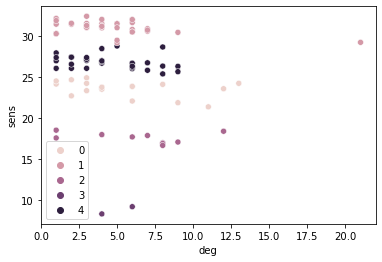

In [345]:
idx =0.45
plot_kmeans(pcc_dfs[idx], 'deg','sens')

# Sensor change in different thresholds

In [364]:
all_df = pd.read_csv('../data/raw/Data File S3. Genetic interaction profile similarity matrices/cc_ALL.txt','\t',index_col=[0,1], header=[0,1])

In [367]:
df_long_renamed = all_df.melt(ignore_index=False, col_level=0).reset_index(inplace=False).rename(columns = {'level_0':'gene1','level_1':'Systematic gene name', 'variable':'gene2','value':'pcc'})

In [405]:
print("PCC threshold","Sensors in the higher threshold network","Sensors in the higher threshold GC","Number of sensors")
for i in range(1,len(thr_list)):
    prev = thr_list[i-1]
    curr = thr_list[i]
    
    sensor_names = sensor_dfs[prev].orf_name
    all_edges = df_long_renamed.loc[(df_long_renamed.pcc>=curr)]
    all_nodes = np.unique([*all_edges.gene1, *all_edges.gene2])
    
    print(prev, sum(sensor_names.isin(all_nodes)), sum(sensor_names.isin(pcc_dfs[curr].orf_name)) , len(sensor_names))

PCC threshold Sensors in the higher threshold network Sensors in the higher threshold GC Number of sensors
0.05 63 63 63
0.1 9 5 63
0.2 28 3 52
0.25 12 1 40
0.3 21 19 27
0.35 15 0 17
0.4 1 0 3
0.45 1 0 1


0.05 0.06096 6230
0.1 0.109875 6230
0.2 0.23868 5272
0.25 0.26991 4209
0.3 0.35452 3285
0.35 0.39382 2606
0.4 0.43577 1967
0.45 0.48646999999999996 1390
0.5 0.50576 924


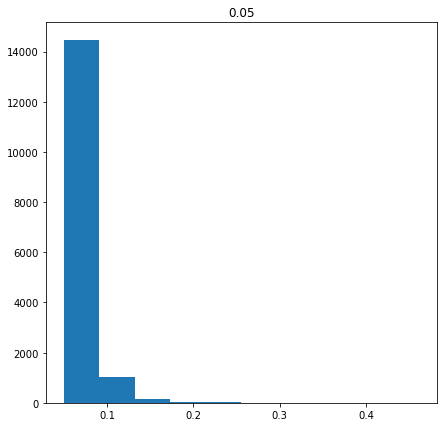

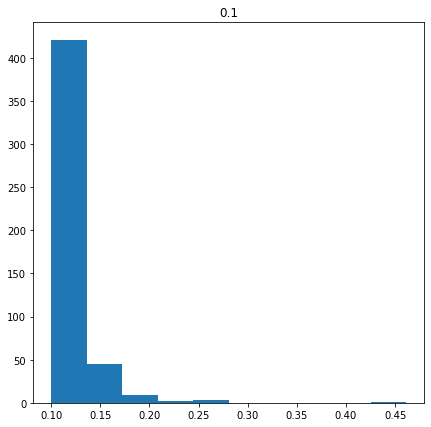

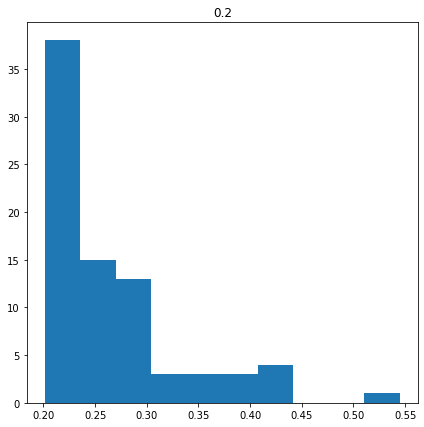

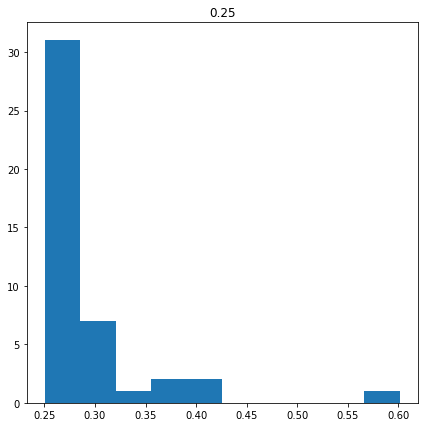

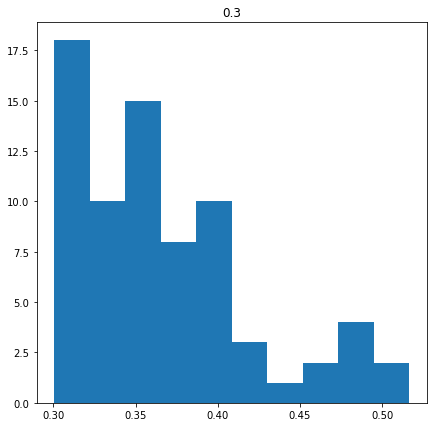

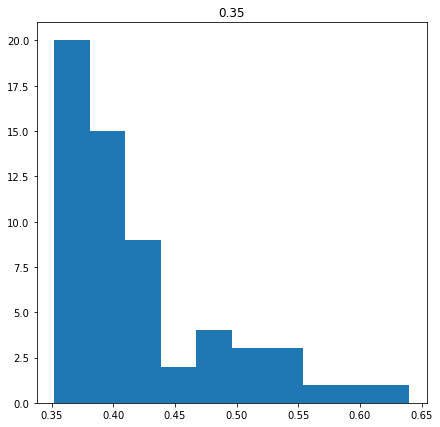

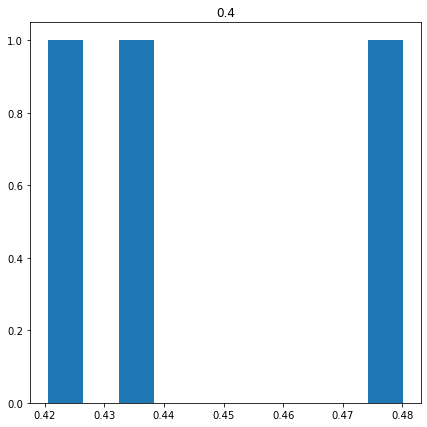

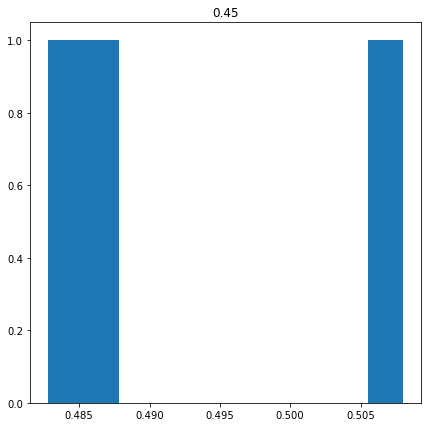

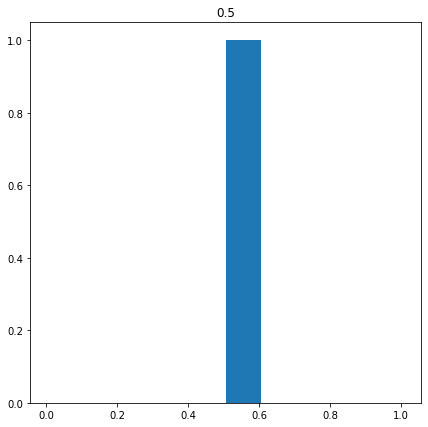

In [409]:
for i in thr_list:
    sensor_names = sensor_dfs[i].orf_name
    all_edges = df_long_renamed.loc[df_long_renamed.pcc>=i]
    g = nx.from_pandas_edgelist(all_edges,source='gene1',target='gene2',edge_attr='pcc')
    fig, ax = plt.subplots(figsize=(7,7))
    data = [val for u,v,val in g.edges(sensor_names.tolist(), data='pcc')]
    ax.hist(data)
    ax.set_title(i)
    print(i , np.median(data), len(g.nodes))

In [518]:
exn = pd.read_csv('../../pgsNetwork/analysis/data/derived_data/SGA_data_combined.csv','\t')

In [521]:
aa = exn.loc[exn['Query allele name'].isin(effector_dfs[0.2].orf_name) & exn['Array allele name'].isin(effector_dfs[0.2].orf_name) ]

In [527]:
exe_names = np.unique([*aa.loc[aa.data_source=='ExE']['Query allele name'],*aa.loc[aa.data_source=='ExE']['Array allele name']])
nxe_names = np.unique(aa.loc[aa.data_source=='ExN_NxE']['Array allele name'])

In [537]:
strain_ids = pd.read_csv('../../pgsNetwork/trymake/pgsNetwork//analysis/data/derived_data/strain_ids_with_experiment_count_all.csv')

In [538]:
strain_ids

,Systematic gene name,Allele Gene name,num,cat,maincat,bin
0,YAL002W,vps8,8910,na.nq.nxes,nonessential,90
1,YAL007C,erp2,8114,na.nq,nonessential,82
2,YAL008W,fun14,8158,na.nq,nonessential,82
3,YAL009W,spo7,4181,nq.nxes,nonessential,42
4,YAL010C,mdm10,8849,na.nq.nxes,nonessential,89
...,...,...,...,...,...,...
6013,YPR161C,sgv1-5001,3219,NaN,essential,33
6014,YPR183W,dpm1-6,3236,NaN,essential,33
6015,YAR019C,cdc15-2,3265,NaN,essential,33
6016,YAR007C,rfa1-m2,3299,NaN,essential,33


In [553]:
ii = 0.2
effector_dfs[ii].loc[effector_dfs[ii].orf_name.isin(strain_ids.loc[strain_ids.maincat=='essential']['Allele Gene name'])].shape[0]/effector_dfs[ii].shape[0]

0.28846153846153844